## NHS Service Utilisation Analysis  
**Course**: LSE DA201  |  **Student**: Monica Baracho  |  **Date**: 26 May 

This analysis explores the NHS's service use, missed appointments, and communication trends, providing visual and statistical evidence to inform stakeholder decision-making

	
This notebook requires the actual_duration.csv and appointments_regional.csv, national_categories.xlsx, icb_locations.csv, tweets.csv and metadata_nhs.txt files. Upload these files to the directory before you begin.

icb_locations.csv data extracted from ONS (Office for National Statistics) Geography portal. Population and GP (General Practitioner) data related to ICB Locations downloaded from June 2022 can be downloaded at the NHS Website. 

Geographical and shape data used by Geopandas can be downloaded from the NHS website.

ICB Locations
Region Locations


## Executive Summary 

**Why this matters**  
• NHS GP demand now averages **25.8 M appointments/month** (Aug 2021–Jun 2022) – 15 % above pre-COVID levels.  
• Clinics operate at **115 % of planned capacity**, leaving no slack for shocks.  
• **4.7 % of capacity is lost** to missed appointments (DNA), driven by short-notice and remote bookings.  

**Three board-level actions**  
1. **Target DNA hotspots** – send SMS/app reminders for bookings ≤ 7 days; pilot stricter confirmation for remote slots.  
2. **Rebalance staffing** – shift resource to high-demand, low-access ICBs; maintain locum surge pools before autumn & spring peaks.  
3. **Monitor sentiment** – track hashtags (#NHScrisis, #ThankYouNHS) weekly and sync comms with operational data.

*(Details and evidence on the following pages.)*

> **Note:** This notebook forms the foundation for the interactive **NHS Intelligence Dashboard**, developed at the end of the analysis. The dashboard integrates key insights on appointment trends, missed appointments, and sentiment, and is accessible as an HTML report.


#  **Navigation Tip:** If you're using JupyterLab, you can open the **Table of Contents** panel from the left sidebar to navigate quickly through this notebook's sections.


In [4]:
# Import necessary libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
appointments = pd.read_csv('appointments_regional.csv')
duration = pd.read_csv('actual_duration.csv')
categories = pd.read_excel('national_categories.xlsx')
tweets = pd.read_csv('tweets.csv')

In [5]:
# === Basic Dataset Overview ===

# Appointments
print("Appointments dataset:")
print(appointments.shape)
print(appointments.columns)

# Actual Duration
print("\nActual Duration dataset:")
print(duration.shape)
print(duration.columns)

# National Categories
print("\nNational Categories dataset:")
print(categories.shape)
print(categories.columns)

# Tweets
print("\nTweets dataset:")
print(tweets.shape)
print(tweets.columns)



Appointments dataset:
(596821, 7)
Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments'],
      dtype='object')

Actual Duration dataset:
(137793, 8)
Index(['sub_icb_location_code', 'sub_icb_location_ons_code',
       'sub_icb_location_name', 'icb_ons_code', 'region_ons_code',
       'appointment_date', 'actual_duration', 'count_of_appointments'],
      dtype='object')

National Categories dataset:
(817394, 8)
Index(['appointment_date', 'icb_ons_code', 'sub_icb_location_name',
       'service_setting', 'context_type', 'national_category',
       'count_of_appointments', 'appointment_month'],
      dtype='object')

Tweets dataset:
(1174, 10)
Index(['tweet_id', 'tweet_full_text', 'tweet_entities',
       'tweet_entities_hashtags', 'tweet_metadata', 'tweet_retweet_count',
       'tweet_favorite_count', 'tweet_favorited', 'tweet_retweeted',
       'tweet_lang'],
      dtyp

In [335]:
import pandas as pd
import numpy as np
from scipy import stats

# Load datasets
appointments = pd.read_csv("appointments_regional.csv")
duration = pd.read_csv("actual_duration.csv")
categories = pd.read_excel("national_categories.xlsx")

# -------------------------------
# 🔍 VALIDATE appointments_regional.csv
# -------------------------------
print("🗂️  appointments_regional.csv")
print(appointments.info())

print("\nMissing values (%):")
print((appointments.isna().mean() * 100).round(2))

print("\nDuplicate rows:", appointments.duplicated().sum())

print("\nUnique values:")
for col in ['icb_ons_code', 'appointment_status', 'hcp_type', 'appointment_mode', 'time_between_book_and_appointment']:
    print(f"{col}: {appointments[col].nunique()}")

appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'], errors='coerce')
print("\nDate range:")
print("Min:", appointments['appointment_month'].min(), "| Max:", appointments['appointment_month'].max())

print("\ncount_of_appointments stats:")
print(appointments['count_of_appointments'].describe())

# -------------------------------
# ⏱️ VALIDATE actual_duration.csv
# -------------------------------
print("\n🕒 actual_duration.csv")
print(duration.info())
print("\nMissing values (%):")
print((duration.isna().mean() * 100).round(2))

print("\nUnique duration bins:", duration['actual_duration'].nunique())
print("Most frequent bin:", duration['actual_duration'].value_counts().idxmax())

# Outlier scan (optional)
duration['actual_duration'] = pd.to_numeric(duration['actual_duration'], errors='coerce')
dur_clean = duration.dropna(subset=['actual_duration']).copy()
dur_clean['z'] = stats.zscore(dur_clean['actual_duration'])
outliers = dur_clean['z'].abs() > 3
print(f"\nOutliers in duration (z > 3): {outliers.sum()} rows ({outliers.mean():.2%})")

# -------------------------------
# 🧾 VALIDATE national_categories.xlsx
# -------------------------------
print("\n📂 national_categories.xlsx")
print(categories.info())

print("\nMissing values (%):")
print((categories.isna().mean() * 100).round(2))

print("\nUnique values:")
for col in ['icb_ons_code', 'service_setting', 'context_type', 'national_category']:
    print(f"{col}: {categories[col].nunique()}")

categories['appointment_date'] = pd.to_datetime(categories['appointment_date'], errors='coerce')
print("\nDate range:")
print("Min:", categories['appointment_date'].min(), "| Max:", categories['appointment_date'].max())

print("\ncount_of_appointments stats:")
print(categories['count_of_appointments'].describe())


🗂️  appointments_regional.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None

Missing values (%):
icb_ons_code                         0.0
appointment_month                    0.0
appointment_status                   0.0
hcp_type                             0.0
appointment_mode                     0.0
ti

### Monthly Appointment Counts

This line chart visualizes the **total number of appointments per month** over time. The dataset is grouped by `appointment_month` and plotted to identify monthly trends in appointment volume.

- The **x-axis** represents time (months), starting from January 2020.
- The **y-axis** indicates the **number of appointments** (in tens of millions).
- Noticeable dips and peaks may reflect seasonal trends, policy changes, or external factors (e.g. the COVID-19 pandemic impact).

The chart helps us detect patterns in healthcare service usage and supports further investigation into possible causes behind fluctuations.


In [175]:
import seaborn as sns
# NHS corporate palette
NHS_BLUE   = "#005EB8"
NHS_LIGHT  = "#41B6E6"
NHS_GREEN  = "#78BE20"
NHS_AMBER  = "#FFB71B"
NHS_RED    = "#D5281B"

sns.set_palette([NHS_BLUE, NHS_GREEN, NHS_AMBER, NHS_RED, NHS_LIGHT])


In [176]:
import pandas as pd

# Load the dataset
appointments_df = pd.read_csv('appointments_regional.csv')

# Convert to datetime format if not already
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'], format='%Y-%m', errors='coerce')
categories['appointment_month'] = pd.to_datetime(categories['appointment_month'], format='%Y-%m', errors='coerce')

# Preview the data to confirm column names
appointments_df.head()


icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                   8107  
1                    15  to 21 Days                   6791  
2                       2 to 7 Days                  20686  
3                    22  to 28 Days                   4268  
4                     8  to 14 Days                  11971

In [9]:
print(appointments['appointment_month'].dtype)
print(categories['appointment_month'].dtype)


datetime64[ns]
datetime64[ns]


In [10]:
# Group by month and sum the number of appointments
monthly_counts = appointments.groupby('appointment_month')['count_of_appointments'].sum()


In [11]:
# Check all unique appointment statuses
print("Unique appointment_status values:")
print(appointments['appointment_status'].unique())



Unique appointment_status values:
['Attended' 'DNA' 'Unknown']


In [182]:
# Load datasets first
ad = pd.read_csv('actual_duration.csv')
ar = pd.read_csv('appointments_regional.csv')
nc = pd.read_excel('national_categories.xlsx')

# Check metadata
print(ad.info())

# Check basic stats
print(ad.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None
       sub_icb_location_code sub_icb_location_ons_code  \
count                 137793                    137793   
unique                   106                       106   
top                      26A                 E38000239   
freq                    1484               

In [183]:
# Determine the descriptive statistics of the data set
# Get descriptive statistics for numeric columns
print(ad.describe())




       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.000000
25%               194.000000
50%               696.000000
75%              1621.000000
max             15400.000000


###  Missed Appointments Over Time with UK Lockdowns Highlighted

This line chart illustrates the **monthly number of missed NHS appointments (Did Not Attend - DNA)** from early 2020 to mid-2022. 

- The **red line** represents the total number of missed appointments per month.
- **Shaded grey areas** correspond to periods of **UK national lockdowns** during the COVID-19 pandemic.

#### Key Insights:
- A **sharp drop** in missed appointments occurred in **March–April 2020**, likely due to the first national lockdown and reduced service availability.
- There was a **gradual recovery** in missed appointments during mid to late 2020, with **noticeable spikes** post-lockdowns, possibly reflecting rescheduling and increased demand.
- Lockdowns appear to have a **suppressing effect** on missed appointments, potentially due to fewer in-person visits or greater patient caution.

This visualization helps understand how public health restrictions impacted patient attendance behavior over time.




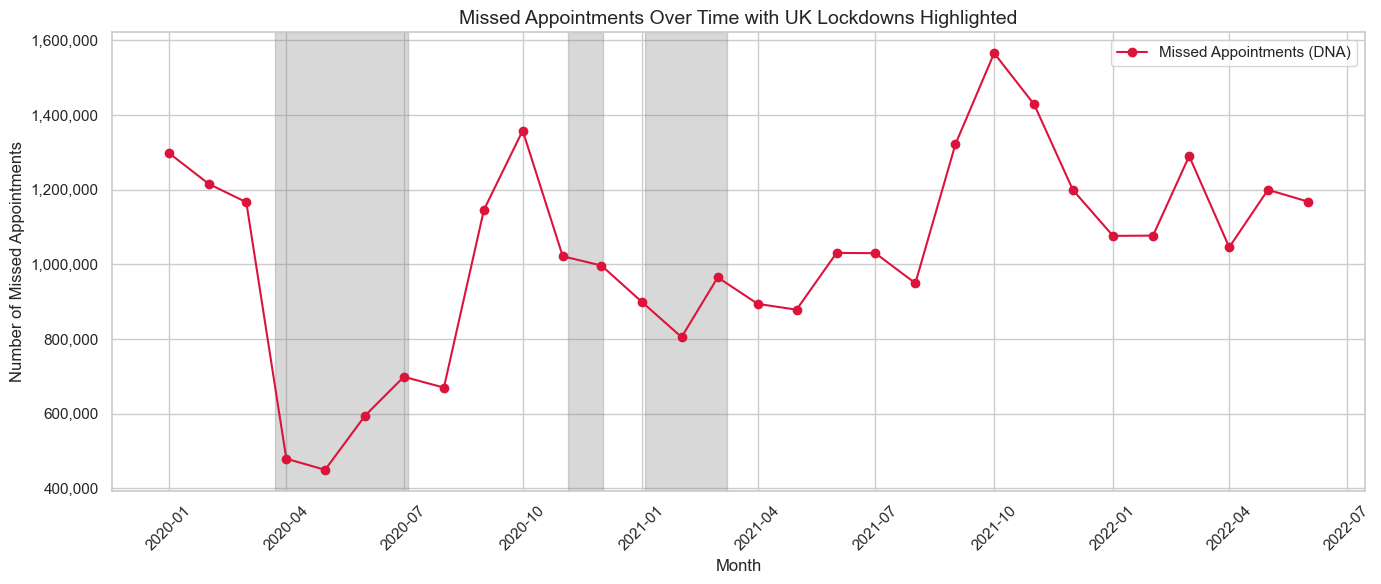

In [184]:
# Load dataset
appointments = pd.read_csv("appointments_regional.csv")

# Convert to datetime
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'], errors='coerce')

# Filter DNA (missed appointments)
missed = appointments[appointments['appointment_status'] == 'DNA']

# Group missed appointments per month
missed_by_month = missed.groupby(missed['appointment_month'].dt.to_period('M'))['count_of_appointments'].sum()
missed_by_month.index = missed_by_month.index.to_timestamp()

# Define key UK lockdown periods
lockdowns = [
    ('2020-03-23', '2020-07-04'),  # First lockdown
    ('2020-11-05', '2020-12-02'),  # Second lockdown
    ('2021-01-04', '2021-03-08')   # Third lockdown
]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(missed_by_month.index, missed_by_month.values, marker='o', color='crimson', label='Missed Appointments (DNA)')

# Add shaded regions for lockdowns
for start, end in lockdowns:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# Format the chart
plt.title("Missed Appointments Over Time with UK Lockdowns Highlighted", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Missed Appointments")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()


### Average Missed Appointments per Month  
#### Pre-, During-, and Post-Lockdown Periods

This bar chart compares the **average number of missed NHS appointments per month** across three distinct phases of the COVID-19 pandemic:

- **Pre-Lockdown**: The highest average of missed appointments, exceeding **1.2 million per month**.
- **During Lockdown**: A significant decline in missed appointments, likely due to reduced in-person visits, cancellations, and stricter public movement restrictions.
- **Post-Lockdown**: A rebound in missed appointments, approaching pre-lockdown levels, possibly driven by appointment backlogs and increased service demand.

#### Key Takeaway:
Lockdowns had a **clear suppressing effect** on missed appointments, but this effect was temporary. The post-lockdown recovery indicates a return to typical patient behavior and NHS capacity levels.

This analysis provides insight into how external policy measures (e.g. lockdowns) can influence patient engagement and service delivery trends.


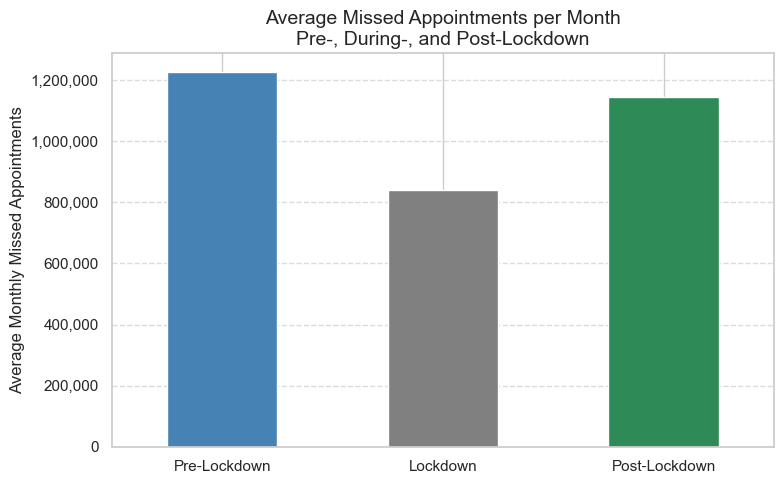

In [190]:
# Load the dataset
appointments = pd.read_csv("appointments_regional.csv")

# Convert to datetime
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'], errors='coerce')

# Filter for missed appointments (DNA)
missed = appointments[appointments['appointment_status'] == 'DNA']

# Define the three key periods
pre_lockdown = missed[missed['appointment_month'] < '2020-03-23']
lockdown = missed[(missed['appointment_month'] >= '2020-03-23') & (missed['appointment_month'] <= '2021-03-08')]
post_lockdown = missed[missed['appointment_month'] > '2021-03-08']

# Group by month and calculate the sum for each period
pre_summary = pre_lockdown.groupby(pre_lockdown['appointment_month'].dt.to_period('M'))['count_of_appointments'].sum()
lockdown_summary = lockdown.groupby(lockdown['appointment_month'].dt.to_period('M'))['count_of_appointments'].sum()
post_summary = post_lockdown.groupby(post_lockdown['appointment_month'].dt.to_period('M'))['count_of_appointments'].sum()

# Calculate average number of missed appointments per month
averages = pd.Series({
    'Pre-Lockdown': pre_summary.mean(),
    'Lockdown': lockdown_summary.mean(),
    'Post-Lockdown': post_summary.mean()
})

# Plot the results
plt.figure(figsize=(8, 5))
averages.plot(kind='bar', color=['steelblue', 'gray', 'seagreen'])

# Formatting
plt.title("Average Missed Appointments per Month\nPre-, During-, and Post-Lockdown", fontsize=14)
plt.ylabel("Average Monthly Missed Appointments")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()


In [18]:
# Get descriptive statistics for all columns, including object types
print("\n Descriptive statistics (including object columns):\n")
print(ad.describe(include='all'))


 Descriptive statistics (including object columns):

       sub_icb_location_code sub_icb_location_ons_code  \
count                 137793                    137793   
unique                   106                       106   
top                      26A                 E38000239   
freq                    1484                      1484   
mean                     NaN                       NaN   
std                      NaN                       NaN   
min                      NaN                       NaN   
25%                      NaN                       NaN   
50%                      NaN                       NaN   
75%                      NaN                       NaN   
max                      NaN                       NaN   

                    sub_icb_location_name icb_ons_code region_ons_code  \
count                              137793       137793          137793   
unique                                106           42               7   
top     NHS Norfolk and Wav

In [19]:
# Check unique values and counts in actual_duration
print(ad['actual_duration'].value_counts())


actual_duration
Unknown / Data Quality    20161
1-5 Minutes               19909
6-10 Minutes              19902
11-15 Minutes             19738
16-20 Minutes             19534
21-30 Minutes             19452
31-60 Minutes             19097
Name: count, dtype: int64


/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/3873081946.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/3873081946.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


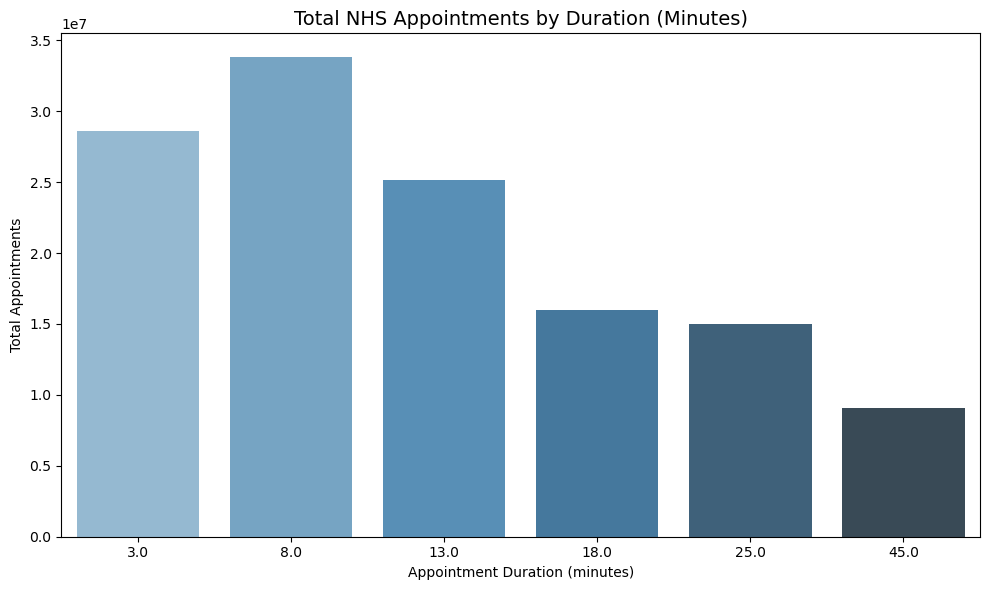

In [20]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load the actual_duration dataset (if not already loaded)
ad = pd.read_csv('actual_duration.csv')

# Step 3: Map duration categories to midpoint values (in minutes)
duration_map = {
    '1-5 Minutes': 3,
    '6-10 Minutes': 8,
    '11-15 Minutes': 13,
    '16-20 Minutes': 18,
    '21-30 Minutes': 25,
    '31-60 Minutes': 45,
    'Unknown / Data Quality': np.nan
}

# Step 4: Create a numeric column for duration
ad['duration_minutes'] = ad['actual_duration'].map(duration_map)

# Step 5: Drop rows with unknown duration
duration_clean = ad.dropna(subset=['duration_minutes'])

# Step 6: Plot total appointments by duration
plt.figure(figsize=(10, 6))
sns.barplot(
    data=duration_clean,
    x='duration_minutes',
    y='count_of_appointments',
    estimator=sum,
    ci=None,
    palette='Blues_d'
)

# Step 7: Format and show plot
plt.title('Total NHS Appointments by Duration (Minutes)', fontsize=14)
plt.xlabel('Appointment Duration (minutes)')
plt.ylabel('Total Appointments')
plt.tight_layout()
plt.show()


In [21]:
# Import and sense-check the appointments_regional.csv data set as ar.
ar = pd.read_csv('appointments_regional.csv')

# View the DataFrame.
print(ar.info())
print(ar.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None
  icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034 

In [22]:
# Convert appointment_month to string (YYYY-MM) or datetime
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'])
ar['appointment_month_str'] = ar['appointment_month'].dt.strftime('%Y-%m')


In [23]:
# Check unique appointment statuses and modes
print(ar['appointment_status'].unique())
print(ar['appointment_mode'].unique())


['Attended' 'DNA' 'Unknown']
['Face-to-Face' 'Home Visit' 'Telephone' 'Unknown' 'Video/Online']


In [24]:
# Determine whether there are missing values.
missing_values_ar = ar.isnull().sum()
print("Missing values per column in appointments_regional:\n")
print(missing_values_ar)


Missing values per column in appointments_regional:

icb_ons_code                         0
appointment_month                    0
appointment_status                   0
hcp_type                             0
appointment_mode                     0
time_between_book_and_appointment    0
count_of_appointments                0
appointment_month_str                0
dtype: int64


## Missing Values Check — appointments_regional.csv

We checked for missing values in the `appointments_regional.csv` dataset.

**Result:**
- No missing values in any of the 8 columns.
- Columns like `appointment_status` and `appointment_mode` contain the category `'Unknown'`, but this is a data value — not a missing entry.

 No imputation or removal of missing data is required.


In [26]:
# Determine the metadata of the data set.
print(ar.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 8 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   icb_ons_code                       596821 non-null  object        
 1   appointment_month                  596821 non-null  datetime64[ns]
 2   appointment_status                 596821 non-null  object        
 3   hcp_type                           596821 non-null  object        
 4   appointment_mode                   596821 non-null  object        
 5   time_between_book_and_appointment  596821 non-null  object        
 6   count_of_appointments              596821 non-null  int64         
 7   appointment_month_str              596821 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 36.4+ MB
None


In [27]:
# Determine the descriptive statistics of the data set.
# Get descriptive statistics for numeric columns
print(ar.describe())

# Get descriptive statistics for all columns, including object types
print("\n Descriptive statistics (including object columns):\n")
print(ar.describe(include='all'))



                   appointment_month  count_of_appointments
count                         596821          596821.000000
mean   2021-03-19 11:31:17.489565696            1244.601857
min              2020-01-01 00:00:00               1.000000
25%              2020-08-01 00:00:00               7.000000
50%              2021-04-01 00:00:00              47.000000
75%              2021-11-01 00:00:00             308.000000
max              2022-06-01 00:00:00          211265.000000
std                              NaN            5856.887042

 Descriptive statistics (including object columns):

       icb_ons_code              appointment_month appointment_status  \
count        596821                         596821             596821   
unique           42                            NaN                  3   
top       E54000057                            NaN           Attended   
freq          54527                            NaN             232137   
mean            NaN  2021-03-19 11:31:17.

In [28]:
# Import pandas if not already imported
import pandas as pd

# Import and sense-check the national_categories.xlsx data set as nc
nc = pd.read_excel('national_categories.xlsx')

# View the structure and first few rows of the DataFrame
print(nc.info())
print(nc.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None
  appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North

In [29]:
# Determine whether there are missing values.
# Check for missing values in the nc DataFrame
missing_values_nc = nc.isnull().sum()
print("Missing values per column in national_categories:\n")
print(missing_values_nc)



Missing values per column in national_categories:

appointment_date         0
icb_ons_code             0
sub_icb_location_name    0
service_setting          0
context_type             0
national_category        0
count_of_appointments    0
appointment_month        0
dtype: int64


In [30]:
# Determine the metadata of the data set.
# Check the metadata of the nc DataFrame
print(nc.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


## Activity 2: Importing and exploring the data 

## Descriptive Statistics — national_categories.xlsx

We used `.describe()` to explore the dataset.

### Numeric column: `count_of_appointments`
- Mean: ~362 appointments
- Min: 1 appointment
- Max: 16,590 appointments (large outlier)
- Standard deviation: ~1,085 (high variability)
- Median (50%): 25 appointments
- 25th percentile: 7 appointments
- 75th percentile: 128 appointments

**Insight:**  
There is a highly uneven distribution of appointments, with some records showing very large counts. This suggests the presence of outliers and aggregation at different levels.

---

### Date column: `appointment_date`
- Range: August 1, 2021 → June 30, 2022
- Median date: January 18, 2022

---

### Categorical columns
- `icb_ons_code`: 42 unique codes; top = `E54000057` (59,180 rows)
- `sub_icb_location_name`: 106 unique locations; top = `NHS North West London ICB - W2U3Z` (13,007 rows)
- `service_setting`: 5 categories; top = `General Practice` (359,274 rows)
- `context_type`: 3 categories; top = `Care Related Encounter` (700,481 rows)
- `national_category`: 18 categories; top = `Inconsistent Mapping` (89,494 rows)
- `appointment_month`: 11 months; top = March 2022 (82,822 rows)

---

### Key takeaways
- The dataset covers 11 months with heavy representation in March 2022.
- `General Practice` and `Care Related Encounter` dominate service settings and context types.
- `Inconsistent Mapping` as the top `national_category` may require cleaning or review.



### Explore the data set

**Question 1:** How many locations are there in the data set?

In [34]:
# Step 1: Load and inspect files
region_meta = pd.read_csv("NHS_England_Regions_July_2022_EN_BFC.csv")
icb_lookup = pd.read_csv("icb_locations.csv")

# Step 2: Merge directly using available names
merged_icb = icb_lookup.merge(
    region_meta[['NHSER22CD', 'NHSER22NM']],
    left_on='region_ons_code', right_on='NHSER22CD',
    how='left'
)

# Step 3: Merge region info into national_categories data
nc_merged = nc.merge(merged_icb[['icb_ons_code', 'NHSER22NM']], on='icb_ons_code', how='left')

# Step 4: Count entities
print(f"Sub-ICB Locations = {nc_merged['sub_icb_location_name'].nunique()}")
print(f"ICBs = {nc_merged['icb_ons_code'].nunique()}")
print(f"Regions = {nc_merged['NHSER22NM'].nunique()}")




Sub-ICB Locations = 106
ICBs = 42
Regions = 7


In [35]:
# Optional: list all unique location names
unique_locations = nc['sub_icb_location_name'].unique()
print("Unique location names:\n")
print(unique_locations)


Unique location names:

['NHS North East and North Cumbria ICB - 00L'
 'NHS North East and North Cumbria ICB - 00N'
 'NHS North East and North Cumbria ICB - 00P'
 'NHS Lancashire and South Cumbria ICB - 00Q'
 'NHS Lancashire and South Cumbria ICB - 00R'
 'NHS Greater Manchester ICB - 00T' 'NHS Greater Manchester ICB - 00V'
 'NHS Lancashire and South Cumbria ICB - 00X'
 'NHS Greater Manchester ICB - 00Y'
 'NHS Lancashire and South Cumbria ICB - 01A'
 'NHS Greater Manchester ICB - 01D'
 'NHS Lancashire and South Cumbria ICB - 01E'
 'NHS Cheshire and Merseyside ICB - 01F'
 'NHS Greater Manchester ICB - 01G'
 'NHS North East and North Cumbria ICB - 01H'
 'NHS Cheshire and Merseyside ICB - 01J'
 'NHS Lancashire and South Cumbria ICB - 01K'
 'NHS Cheshire and Merseyside ICB - 01T'
 'NHS Cheshire and Merseyside ICB - 01V'
 'NHS Greater Manchester ICB - 01W'
 'NHS Cheshire and Merseyside ICB - 01X'
 'NHS Greater Manchester ICB - 01Y' 'NHS Greater Manchester ICB - 02A'
 'NHS Cheshire and Mersey

**Question 2:** What are the five locations with the highest number of appointments?

This was calculated as the sum of count_of_appointments by sub_icb_location_name from the dataset national_categories.xlsx



In [37]:
# Determine the top five locations based on record count
# Group by location and sum the number of appointments
top_locations = nc.groupby('sub_icb_location_name')['count_of_appointments'].sum()

# Sort in descending order and get the top 
top_five_locations = top_locations.sort_values(ascending=False).head(5)

# Display the result
print("Top five locations by total number of appointments:\n")
print(top_five_locations)


Top five locations by total number of appointments:

sub_icb_location_name
NHS North West London ICB - W2U3Z              12142390
NHS North East London ICB - A3A8R               9588891
NHS Kent and Medway ICB - 91Q                   9286167
NHS Hampshire and Isle Of Wight ICB - D9Y0V     8288102
NHS South East London ICB - 72Q                 7850170
Name: count_of_appointments, dtype: int64


Bar chart saved as 'top_five_appointments_barchart.png'


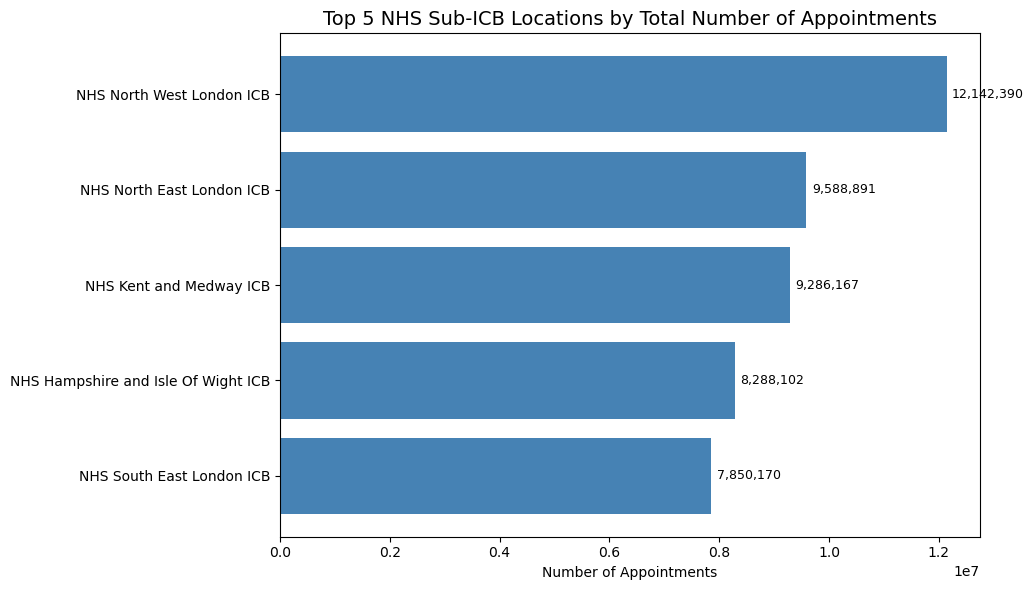

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Example top 5 data (from your previous analysis)
top_five_data = {
    'sub_icb_location_name': [
        'NHS North West London ICB',
        'NHS North East London ICB',
        'NHS Kent and Medway ICB',
        'NHS Hampshire and Isle Of Wight ICB',
        'NHS South East London ICB'
    ],
    'count_of_appointments': [
        12142390,
        9588891,
        9286167,
        8288102,
        7850170
    ]
}

# Convert to DataFrame
df = pd.DataFrame(top_five_data)


# Sort for nicer plotting (optional)
df = df.sort_values('count_of_appointments', ascending=True)

# Create figure
plt.figure(figsize=(10, 6))
bars = plt.barh(df['sub_icb_location_name'], df['count_of_appointments'], color='steelblue')

# Add title and labels
plt.title('Top 5 NHS Sub-ICB Locations by Total Number of Appointments', fontsize=14)
plt.xlabel('Number of Appointments')
plt.tight_layout()

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 100000, bar.get_y() + bar.get_height()/2,
             f'{width:,}', va='center', fontsize=9)

# Save the figure
plt.savefig('top_five_appointments_barchart.png', dpi=300, bbox_inches='tight')

print("Bar chart saved as 'top_five_appointments_barchart.png'")



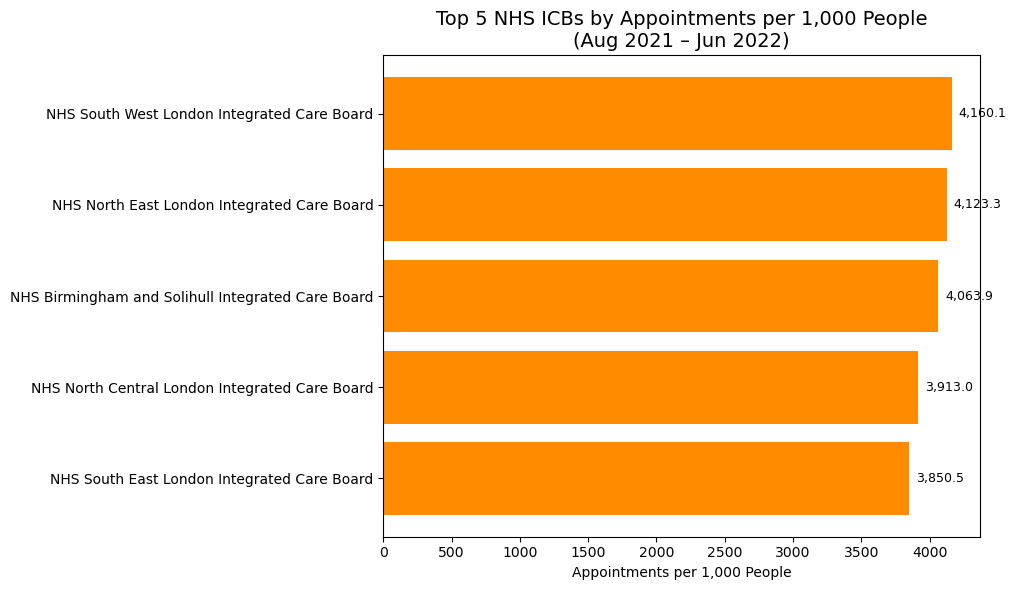

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
appointments_df = pd.read_csv("appointments_regional.csv", parse_dates=["appointment_month"])
icb_df = pd.read_csv("icb_locations.csv")

# Filter to the correct date range
appointments_filtered = appointments_df[
    (appointments_df["appointment_month"] >= "2021-08-01") &
    (appointments_df["appointment_month"] <= "2022-06-30")
]

# Total appointments by ICB
total_appointments = appointments_filtered.groupby("icb_ons_code")["count_of_appointments"].sum().reset_index()

# Merge with population data
merged = total_appointments.merge(
    icb_df[["icb_ons_code", "icb_ons_name", "icb_registered_population_2021_2022"]],
    on="icb_ons_code",
    how="left"
)

# Calculate appointments per 1,000 people
merged["appointments_per_1000"] = (
    merged["count_of_appointments"] / merged["icb_registered_population_2021_2022"]
) * 1000

# Sort and take top 5
top5 = merged.sort_values(by="appointments_per_1000", ascending=True).head(5)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top5["icb_ons_name"], top5["appointments_per_1000"], color='darkorange')
plt.title("Top 5 NHS ICBs by Appointments per 1,000 People\n(Aug 2021 – Jun 2022)", fontsize=14)
plt.xlabel("Appointments per 1,000 People")
plt.tight_layout()

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height() / 2, f'{width:,.1f}', va='center', fontsize=9)

# Save high-res image
plt.savefig("Top5_ICBs_Appointments_Per_1000.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


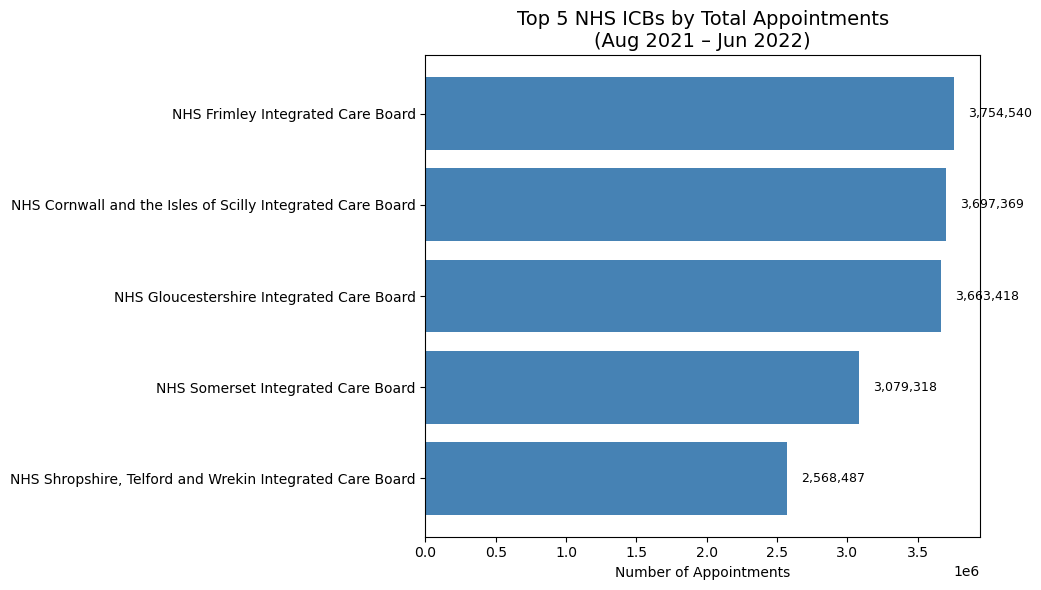

icb_ons_name  count_of_appointments
2   NHS Shropshire, Telford and Wrekin Integrated ...                2568487
21                 NHS Somerset Integrated Care Board                3079318
26          NHS Gloucestershire Integrated Care Board                3663418
19  NHS Cornwall and the Isles of Scilly Integrate...                3697369
18                  NHS Frimley Integrated Care Board                3754540

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
appointments_df = pd.read_csv("appointments_regional.csv", parse_dates=["appointment_month"])
icb_df = pd.read_csv("icb_locations.csv")

# Filter data for August 2021 – June 2022
appointments_filtered = appointments_df[
    (appointments_df["appointment_month"] >= "2021-08-01") &
    (appointments_df["appointment_month"] <= "2022-06-30")
]

# Aggregate total appointments per ICB
total_per_icb = (
    appointments_filtered.groupby("icb_ons_code")["count_of_appointments"]
    .sum()
    .reset_index()
)

# Merge with ICB names
merged = total_per_icb.merge(
    icb_df[["icb_ons_code", "icb_ons_name"]],
    on="icb_ons_code",
    how="left"
)

# Get top 5 by appointment volume
top5 = merged.sort_values(by="count_of_appointments", ascending=True).head(5)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top5["icb_ons_name"], top5["count_of_appointments"], color='steelblue')
plt.title("Top 5 NHS ICBs by Total Appointments\n(Aug 2021 – Jun 2022)", fontsize=14)
plt.xlabel("Number of Appointments")
plt.tight_layout()

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 100000, bar.get_y() + bar.get_height() / 2,
             f'{width:,}', va='center', fontsize=9)

# Save high-resolution PNG
plt.savefig("Top5_ICBs_Total_Appointments.png", dpi=300, bbox_inches='tight')

# Show chart
plt.show()

# Display data for reference
top5[["icb_ons_name", "count_of_appointments"]]



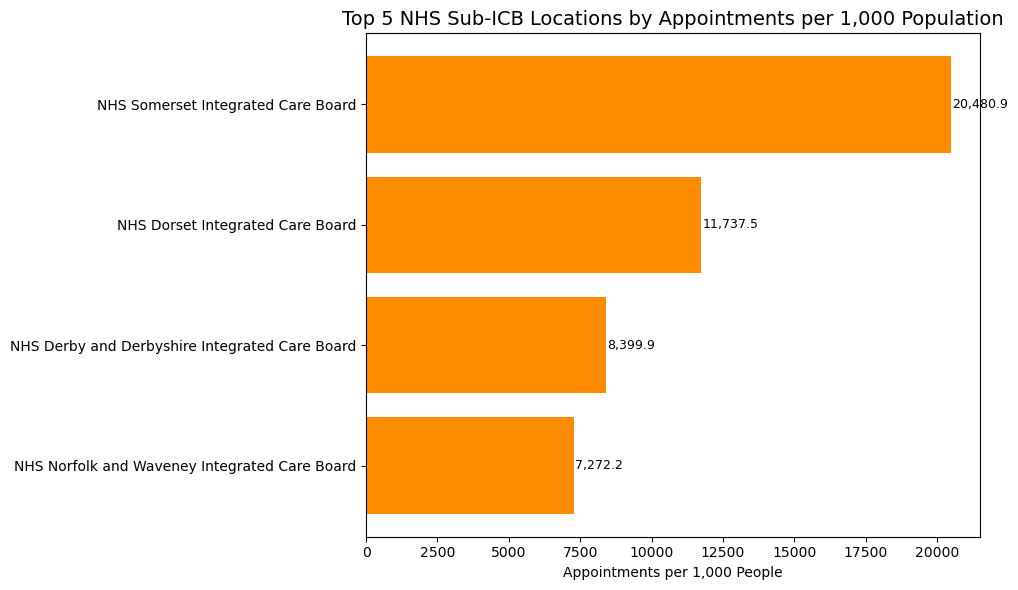

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your population data
icb_df = pd.read_csv('icb_locations.csv')

# Define correct ICB codes and their total appointments
top5_mapping = {
    'E54000038': 'NHS North West London ICB',
    'E54000041': 'NHS North East London ICB',
    'E54000058': 'NHS Kent and Medway ICB',
    'E54000016': 'NHS Hampshire and Isle Of Wight ICB',
    'E54000022': 'NHS South East London ICB'
}

appointment_counts = {
    'E54000038': 12142390,
    'E54000041': 9588891,
    'E54000058': 9286167,
    'E54000016': 8288102,
    'E54000022': 7850170
}

# Filter top 5 ICB data
top5_icb_data = icb_df[icb_df['icb_ons_code'].isin(top5_mapping.keys())][
    ['icb_ons_code', 'icb_ons_name', 'icb_registered_population_2021_2022']
]

# Add total appointments
top5_icb_data['count_of_appointments'] = top5_icb_data['icb_ons_code'].map(appointment_counts)

# Calculate appointments per 1,000 population
top5_icb_data['appointments_per_1000'] = (
    top5_icb_data['count_of_appointments'] / top5_icb_data['icb_registered_population_2021_2022']
) * 1000

# Sort for better plotting
plot_df = top5_icb_data.sort_values('appointments_per_1000', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(plot_df['icb_ons_name'], plot_df['appointments_per_1000'], color='darkorange')

# Add title and labels
plt.title('Top 5 NHS Sub-ICB Locations by Appointments per 1,000 Population', fontsize=14)
plt.xlabel('Appointments per 1,000 People')
plt.tight_layout()

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height() / 2,
             f'{width:,.1f}', va='center', fontsize=9)

# Save as high-resolution PNG
plt.savefig('top_five_appointments_per_1000_barchart.png', dpi=300, bbox_inches='tight')

# Show plot in notebook
plt.show()



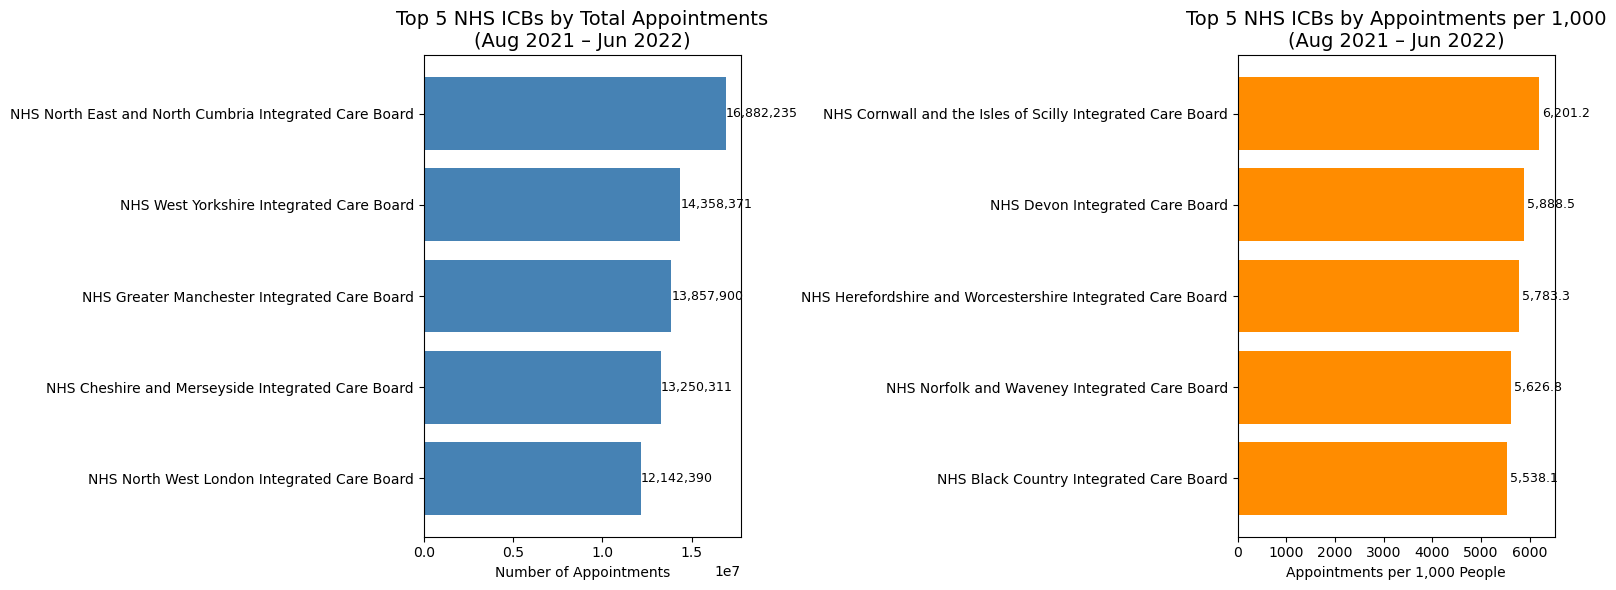

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
appointments = pd.read_csv('appointments_regional.csv', parse_dates=['appointment_month'])
icb_lookup = pd.read_csv('icb_locations.csv')

# Filter by date range
appointments_filtered = appointments[
    (appointments['appointment_month'] >= '2021-08-01') &
    (appointments['appointment_month'] <= '2022-06-30')
]

# Total appointments by ICB
icb_totals = appointments_filtered.groupby('icb_ons_code')['count_of_appointments'].sum().reset_index()

# Merge with ICB names and population
merged = icb_totals.merge(icb_lookup[['icb_ons_code', 'icb_ons_name', 'icb_registered_population_2021_2022']],
                          on='icb_ons_code')

# Compute per 1,000 population
merged['appointments_per_1000'] = (
    merged['count_of_appointments'] / merged['icb_registered_population_2021_2022']
) * 1000

# Sort and select top 5
top_total = merged.sort_values('count_of_appointments', ascending=False).head(5)
top_1000 = merged.sort_values('appointments_per_1000', ascending=False).head(5)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total appointments
sorted_total = top_total.sort_values('count_of_appointments')
axes[0].barh(sorted_total['icb_ons_name'], sorted_total['count_of_appointments'], color='steelblue')
axes[0].set_title("Top 5 NHS ICBs by Total Appointments\n(Aug 2021 – Jun 2022)", fontsize=14)
axes[0].set_xlabel("Number of Appointments")
for i, v in enumerate(sorted_total['count_of_appointments']):
    axes[0].text(v + 20000, i, f"{v:,.0f}", va='center', fontsize=9)

# Per 1000 population
sorted_1000 = top_1000.sort_values('appointments_per_1000')
axes[1].barh(sorted_1000['icb_ons_name'], sorted_1000['appointments_per_1000'], color='darkorange')
axes[1].set_title("Top 5 NHS ICBs by Appointments per 1,000\n(Aug 2021 – Jun 2022)", fontsize=14)
axes[1].set_xlabel("Appointments per 1,000 People")
for i, v in enumerate(sorted_1000['appointments_per_1000']):
    axes[1].text(v + 50, i, f"{v:,.1f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


## Question 3: How many service settings, context types, national categories, and appointment statuses are there?

In [44]:
# Determine the number of unique service settings
num_service_settings = nc['service_setting'].nunique()
print(f"Number of unique service settings: {num_service_settings}")


Number of unique service settings: 5


In [45]:
# List all unique service settings
unique_service_settings = nc['service_setting'].unique()
print("Unique service settings:\n")
print(unique_service_settings)


Unique service settings:

['Primary Care Network' 'Other' 'General Practice' 'Unmapped'
 'Extended Access Provision']


In [46]:
# Determine the number of unique context types
num_context_types = nc['context_type'].nunique()
print(f"Number of unique context types: {num_context_types}")

# List all unique context types
unique_context_types = nc['context_type'].unique()
print("Unique context types:\n")
print(unique_context_types)


Number of unique context types: 3
Unique context types:

['Care Related Encounter' 'Unmapped' 'Inconsistent Mapping']


In [47]:
# Determine the number of unique national categories
num_national_categories = nc['national_category'].nunique()
print(f"Number of unique national categories: {num_national_categories}")

# List all unique national categories
unique_national_categories = nc['national_category'].unique()
print("Unique national categories:\n")
print(unique_national_categories)


Number of unique national categories: 18
Unique national categories:

['Patient contact during Care Home Round' 'Planned Clinics' 'Home Visit'
 'General Consultation Acute' 'Structured Medication Review'
 'Care Home Visit' 'Unmapped' 'Clinical Triage'
 'Planned Clinical Procedure' 'Inconsistent Mapping'
 'Care Home Needs Assessment & Personalised Care and Support Planning'
 'General Consultation Routine'
 'Service provided by organisation external to the practice'
 'Unplanned Clinical Activity' 'Social Prescribing Service'
 'Non-contractual chargeable work'
 'Group Consultation and Group Education' 'Walk-in']


In [48]:
# Determine the number of unique appointment statuses
num_appointment_statuses = ar['appointment_status'].nunique()
print(f"Number of unique appointment statuses: {num_appointment_statuses}")

# List all unique appointment statuses
unique_appointment_statuses = ar['appointment_status'].unique()
print("Unique appointment statuses:\n")
print(unique_appointment_statuses)


Number of unique appointment statuses: 3
Unique appointment statuses:

['Attended' 'DNA' 'Unknown']


In [212]:
# Load the national categories dataset
national_categories = pd.read_excel("national_categories.xlsx")

# Count unique service settings
service_settings_count = national_categories['service_setting'].nunique()

# Count unique context types
context_types_count = national_categories['context_type'].nunique()

# Count unique national categories
national_categories_count = national_categories['national_category'].nunique()

# Count unique appointment statuses
appointment_statuses_count = appointments['appointment_status'].nunique()

# Print the results
print(f"Number of unique service settings: {service_settings_count}")
print(f"Number of unique context types: {context_types_count}")
print(f"Number of unique national categories: {national_categories_count}")
print(f"Number of unique appointment statuses: {appointment_statuses_count}")


Number of unique service settings: 5
Number of unique context types: 3
Number of unique national categories: 18
Number of unique appointment statuses: 3


# Assignment activity 3

## Continue to explore the data and search for answers to more specific questions posed by the NHS.

**Question 1:** Between what dates were appointments scheduled? 

In [216]:
# Ensure the appointment_date column is in datetime format
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'], errors='coerce')

# Drop any rows with missing dates
nc = nc.dropna(subset=['appointment_date'])

# Define the earliest and latest appointment dates
min_date_nc = nc['appointment_date'].min()
max_date_nc = nc['appointment_date'].max()

# Output summary
print(f"Appointments were scheduled between {min_date_nc.date()} and {max_date_nc.date()}.")



Appointments were scheduled between 2021-08-01 and 2022-06-30.


In [217]:
# Change the date format to YYYY-MM-DD (if not already in datetime)
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'])

# Optional: if you want to store it as a string formatted as YYYY-MM-DD
ad['appointment_date_str'] = ad['appointment_date'].dt.strftime('%Y-%m-%d')

# View the DataFrame (first 5 rows)
print(ad.head())



  sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
4  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date         actual_duration  count_of_appointments  \
0       2021-12-01           31-60 Minutes                    364   
1       2021-12-01           21-30 Minutes                    619   
2    

## Question 2:** Which service setting was the most popular for NHS North West London from 1 January to 1 June 2022?

In [56]:
#Which service setting reported the most appointments in North west London from 1 January to 1 June 2022?
# Filter for NHS North West London ICB using icb_ons_code (E54000027) and date range
nc_subset = nc[
    (nc['icb_ons_code'] == 'E54000027') &
    (nc['appointment_date'] >= '2022-01-01') &
    (nc['appointment_date'] <= '2022-06-01')
]

# Check which service setting had the most appointments
service_counts = nc_subset.groupby('service_setting')['count_of_appointments'].sum().sort_values(ascending=False)
print("Service setting counts in North West London (Jan-Jun 2022):")
print(service_counts)


Service setting counts in North West London (Jan-Jun 2022):
service_setting
General Practice             4804239
Unmapped                      391106
Other                         152897
Primary Care Network          109840
Extended Access Provision      98159
Name: count_of_appointments, dtype: int64


## Question 3: **Which month had the highest number of appointments?

In [58]:
# Load datasets (if not already loaded)
ar = pd.read_csv("appointments_regional.csv")
nc = pd.read_excel("national_categories.xlsx")
ad = pd.read_csv("actual_duration.csv")

# Ensure datetime formats
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], errors='coerce')
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'], errors='coerce')
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'], errors='coerce')

# Group totals per month
ar_monthly = ar.groupby(ar['appointment_month'].dt.to_period('M'))['count_of_appointments'].sum()
nc_monthly = nc.groupby(nc['appointment_date'].dt.to_period('M'))['count_of_appointments'].sum()
ad_monthly = ad.groupby(ad['appointment_date'].dt.to_period('M'))['count_of_appointments'].sum()

# Display results
print("Appointments Regional Data (Monthly Totals):")
print(ar_monthly)

print("\n National Categories Data (Monthly Totals):")
print(nc_monthly)

print("\n Actual Duration Data (Monthly Totals):")
print(ad_monthly)


Appointments Regional Data (Monthly Totals):
appointment_month
2020-01    27199296
2020-02    24104621
2020-03    24053468
2020-04    16007881
2020-05    16417212
2020-06    20690805
2020-07    22491437
2020-08    20150520
2020-09    26714255
2020-10    28301932
2020-11    25061602
2020-12    23535936
2021-01    22492069
2021-02    22399569
2021-03    27225424
2021-04    23879932
2021-05    23508395
2021-06    26784182
2021-07    25739219
2021-08    23852171
2021-09    28522501
2021-10    30303834
2021-11    30405070
2021-12    25140776
2022-01    25635474
2022-02    25355260
2022-03    29595038
2022-04    23913060
2022-05    27495508
2022-06    25828078
Freq: M, Name: count_of_appointments, dtype: int64

 National Categories Data (Monthly Totals):
appointment_date
2021-08    23852171
2021-09    28522501
2021-10    30303834
2021-11    30405070
2021-12    25140776
2022-01    25635474
2022-02    25355260
2022-03    29595038
2022-04    23913060
2022-05    27495508
2022-06    25828078
Freq

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/1187881511.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ad['appointment_date'] = pd.to_datetime(ad['appointment_date'], errors='coerce')


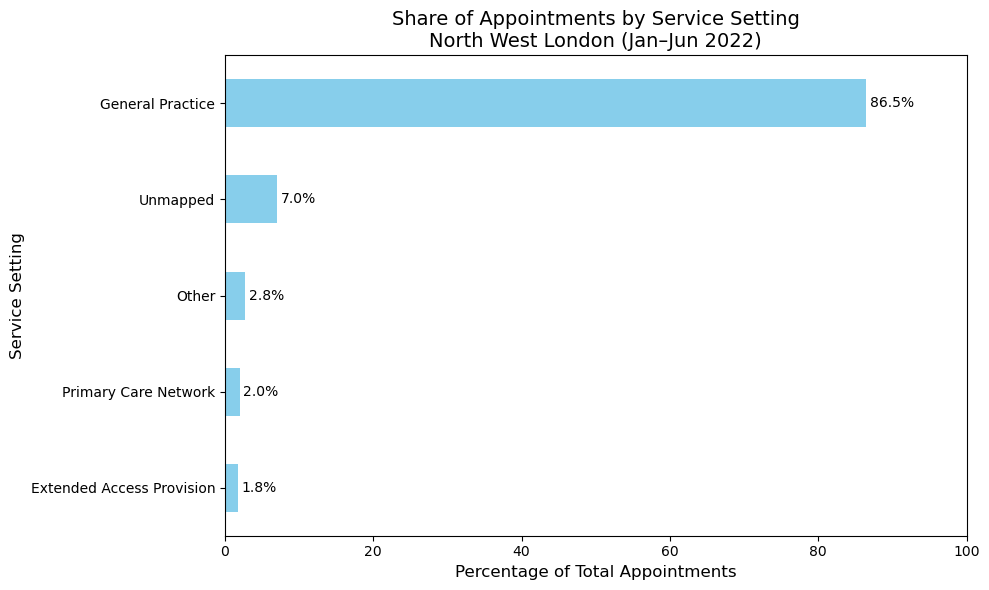

In [59]:
# Calculate percentage share of each service setting
service_counts_percent = (service_counts / service_counts.sum()) * 100

# Plot the percentage-based bar chart
plt.figure(figsize=(10, 6))
service_counts_percent.sort_values().plot(kind='barh', color='skyblue')

# Format chart
plt.title('Share of Appointments by Service Setting\nNorth West London (Jan–Jun 2022)', fontsize=14)
plt.xlabel('Percentage of Total Appointments', fontsize=12)
plt.ylabel('Service Setting', fontsize=12)
plt.xlim(0, 100)

# Add percentage labels
for index, value in enumerate(service_counts_percent.sort_values()):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center')

plt.tight_layout()
plt.show()


### Monthly Appointment Trends: NHS Data (2020–2022)

This chart below compares the total number of appointments recorded per month in two key NHS datasets:

- **Appointments Regional**: Complete dataset spanning from January 2020 to June 2022.
- **National Categories**: Available from August 2021 onward.

---

### Key Observations:

- From August 2021 onward, both datasets report **identical monthly totals**, confirming data consistency.
- The highest monthly volume was observed in **November 2021**, reaching over **30 million** appointments.
- A sharp decline occurred in **April 2020**, likely due to pandemic-related disruptions.
- The grey dashed line marks the **average monthly volume** in the regional dataset (approx. 25 million).

This visualisation helps stakeholders understand the evolution of NHS appointment activity, verify data alignment between sources, and identify seasonal or exceptional peaks.


<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

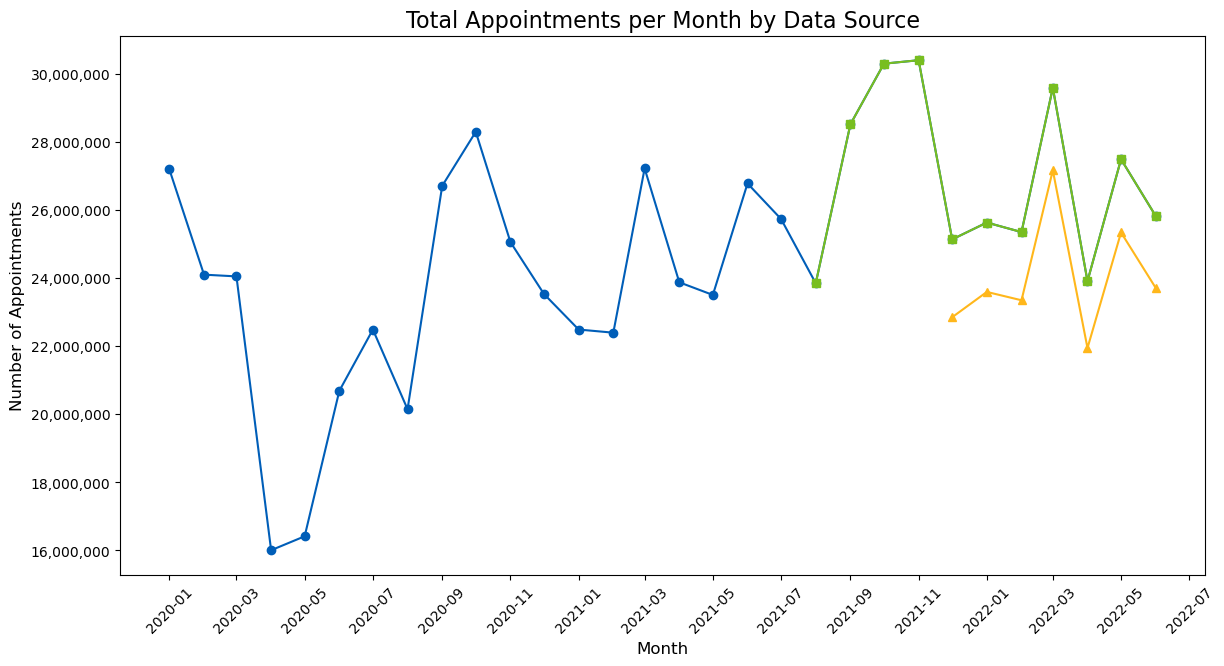

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas as pd

# Convert PeriodIndex to Timestamp
ar_monthly.index = ar_monthly.index.to_timestamp()
nc_monthly.index = nc_monthly.index.to_timestamp()
ad_monthly.index = ad_monthly.index.to_timestamp()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(ar_monthly.index, ar_monthly.values, label='Appointments Regional', marker='o')
plt.plot(nc_monthly.index, nc_monthly.values, label='National Categories', marker='s')
plt.plot(ad_monthly.index, ad_monthly.values, label='Actual Duration', marker='^')

# Title and Axis Labels
plt.title("Total Appointments per Month by Data Source", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Appointments", fontsize=12)

# Format Y-axis with commas
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Format X-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Grid and legend
plt.grid




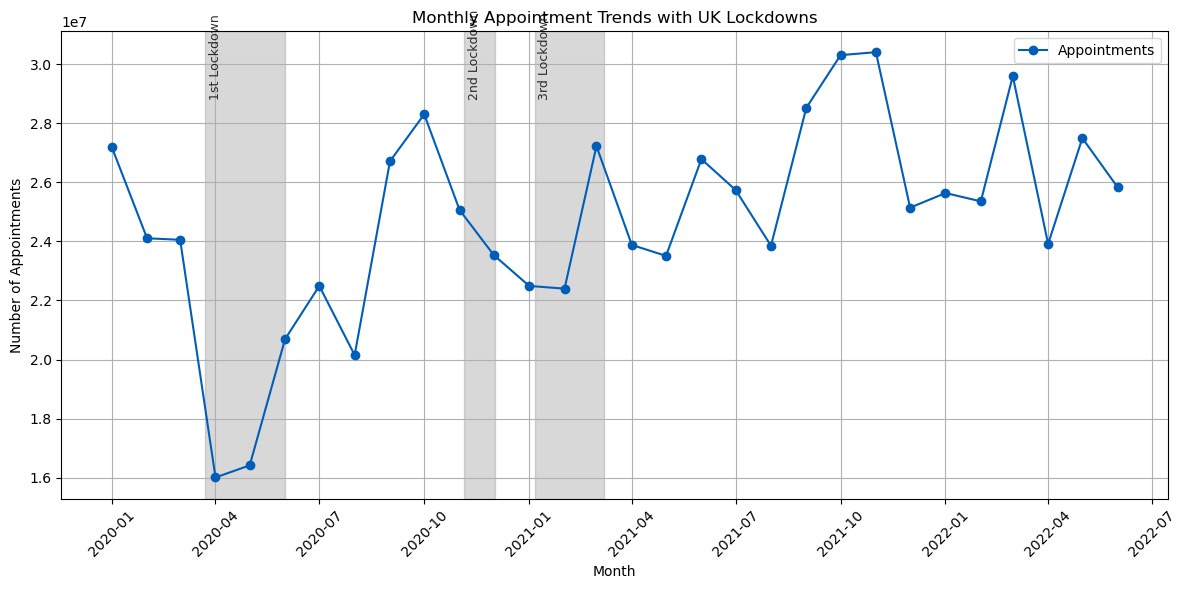

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the 'appointment_month' column is datetime
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'], errors='coerce')

# Define lockdown periods
lockdowns = [
    ('2020-03-23', '2020-06-01', '1st Lockdown'),
    ('2020-11-05', '2020-12-02', '2nd Lockdown'),
    ('2021-01-06', '2021-03-08', '3rd Lockdown')
]

# Group appointments by month
appointments_monthly = appointments.groupby(
    appointments['appointment_month'].dt.to_period('M')
)['count_of_appointments'].sum()

# Convert PeriodIndex to datetime
appointments_monthly.index = appointments_monthly.index.to_timestamp()

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(appointments_monthly.index, appointments_monthly, marker='o', label='Appointments')

# Add shaded lockdown periods
for start, end, label in lockdowns:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)
    plt.text(pd.to_datetime(start) + pd.Timedelta(days=3),
             appointments_monthly.max() * 0.95,
             label, rotation=90, color='black', fontsize=9, alpha=0.8)

plt.title('Monthly Appointment Trends with UK Lockdowns')
plt.ylabel('Number of Appointments')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



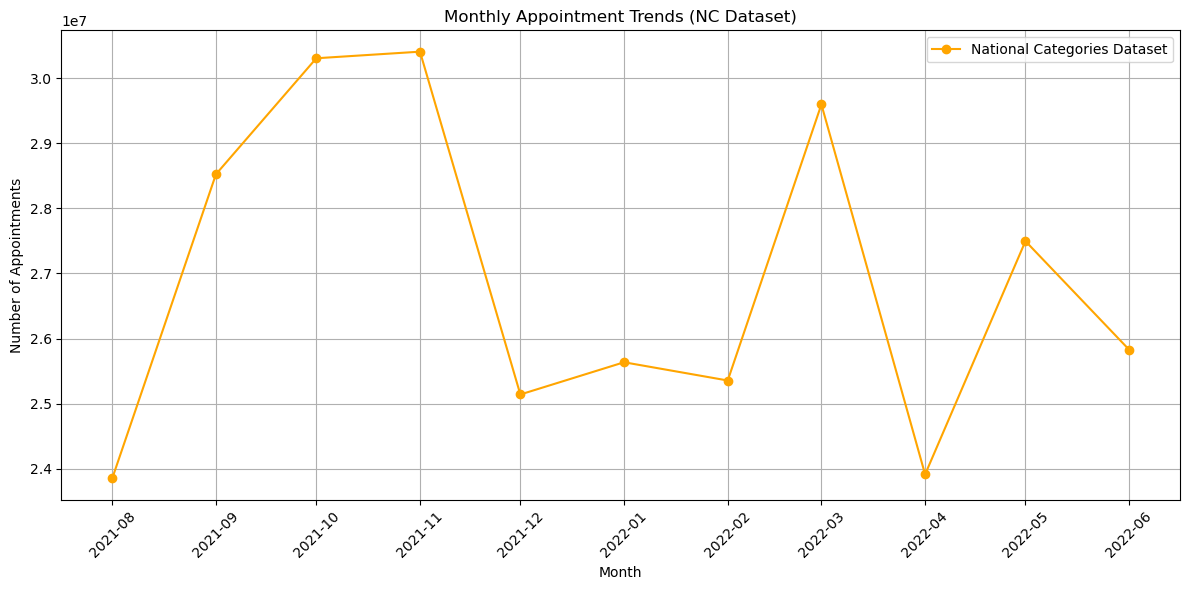

*Note: This dataset begins after the final UK lockdown period.*


In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by month and convert period index to timestamp
nc_monthly = nc.groupby(
    nc['appointment_date'].dt.to_period('M')
)['count_of_appointments'].sum()
nc_monthly.index = nc_monthly.index.to_timestamp()

# Plot without lockdown shading
plt.figure(figsize=(12, 6))
plt.plot(nc_monthly.index, nc_monthly, marker='o', color='orange', label='National Categories Dataset')

plt.title('Monthly Appointment Trends (NC Dataset)')
plt.ylabel('Number of Appointments')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# note (as markdown or in report)
print("*Note: This dataset begins after the final UK lockdown period.*")


Appointments dataset - Month-over-month percentage change:
appointment_month
2020-01-01          NaN
2020-02-01   -11.377776
2020-03-01    -0.212212
2020-04-01   -33.448761
2020-05-01     2.557059
2020-06-01    26.031174
2020-07-01     8.702571
2020-08-01   -10.408037
2020-09-01    32.573527
2020-10-01     5.943183
2020-11-01   -11.449148
2020-12-01    -6.087664
2021-01-01    -4.435205
2021-02-01    -0.411256
2021-03-01    21.544410
2021-04-01   -12.288117
2021-05-01    -1.555855
2021-06-01    13.934541
2021-07-01    -3.901418
2021-08-01    -7.331411
2021-09-01    19.580314
2021-10-01     6.245360
2021-11-01     0.334070
2021-12-01   -17.313869
2022-01-01     1.967712
2022-02-01    -1.093071
2022-03-01    16.721493
2022-04-01   -19.199090
2022-05-01    14.981136
2022-06-01    -6.064372
Freq: MS, Name: count_of_appointments, dtype: float64


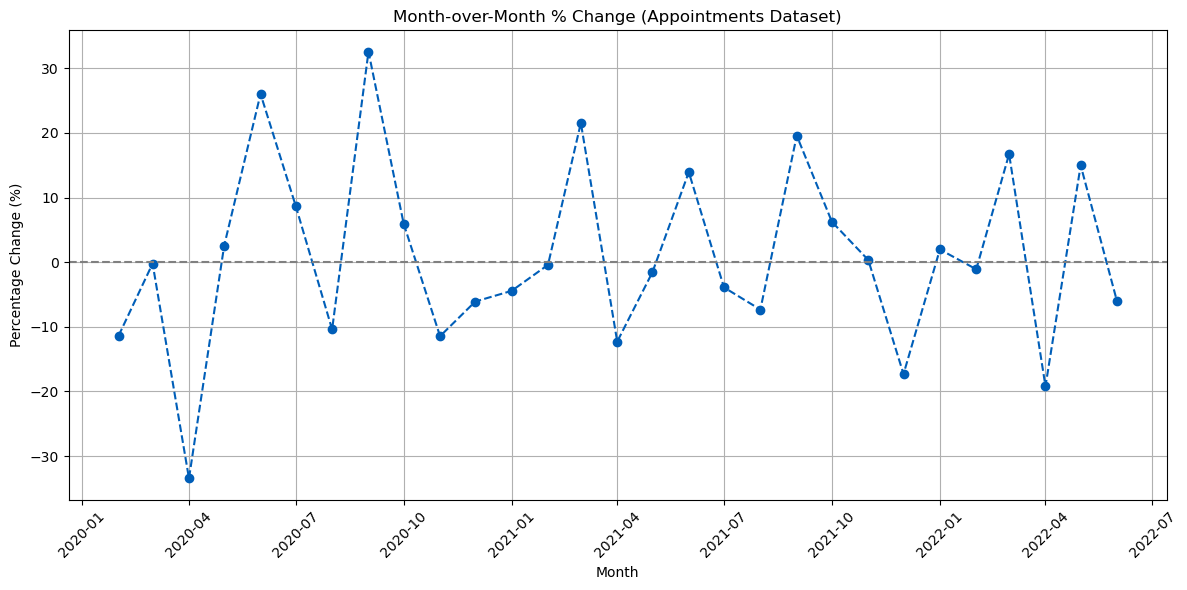

National Categories dataset - Month-over-month percentage change:
appointment_date
2021-08-01          NaN
2021-09-01    19.580314
2021-10-01     6.245360
2021-11-01     0.334070
2021-12-01   -17.313869
2022-01-01     1.967712
2022-02-01    -1.093071
2022-03-01    16.721493
2022-04-01   -19.199090
2022-05-01    14.981136
2022-06-01    -6.064372
Freq: MS, Name: count_of_appointments, dtype: float64


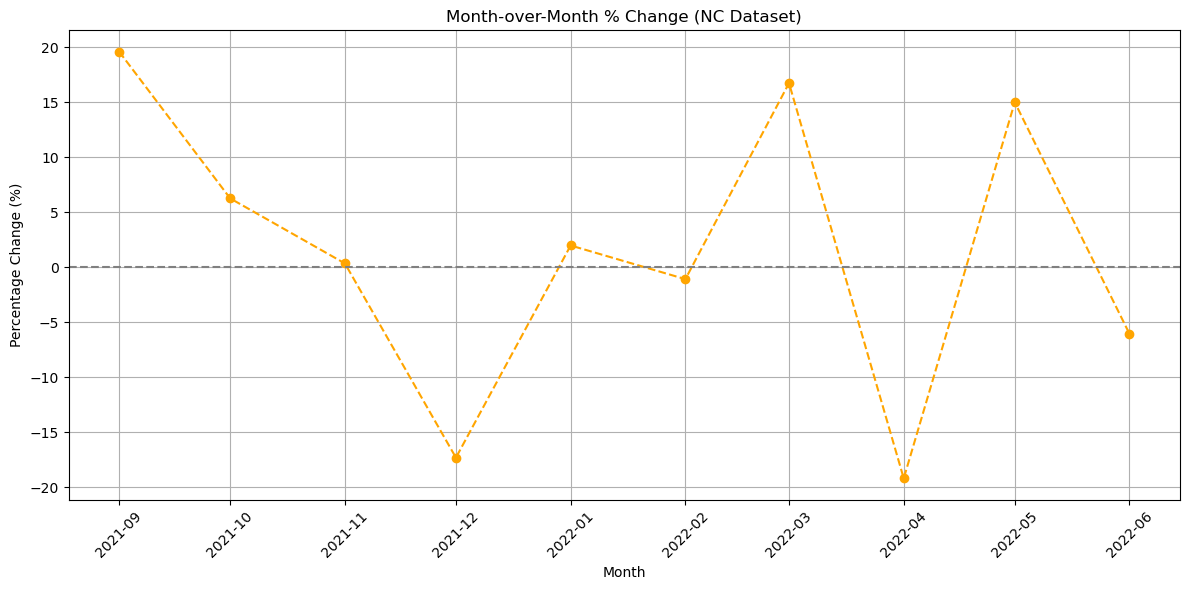

In [64]:
# Appointments dataset
appointments_pct_change = appointments_monthly.pct_change() * 100
print("Appointments dataset - Month-over-month percentage change:")
print(appointments_pct_change)

# Plot
plt.figure(figsize=(12,6))
plt.plot(appointments_pct_change.index, appointments_pct_change, marker='o', linestyle='--')
plt.title('Month-over-Month % Change (Appointments Dataset)')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# NC dataset
nc_pct_change = nc_monthly.pct_change() * 100
print("National Categories dataset - Month-over-month percentage change:")
print(nc_pct_change)

# Plot
plt.figure(figsize=(12,6))
plt.plot(nc_pct_change.index, nc_pct_change, marker='o', linestyle='--', color='orange')
plt.title('Month-over-Month % Change (NC Dataset)')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


In [65]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("appointments_regional.csv")

# Convert appointment_month to datetime
df['appointment_month'] = pd.to_datetime(df['appointment_month'])

# Filter from August 2021 to June 2022
df = df[(df['appointment_month'] >= '2021-08-01') & (df['appointment_month'] <= '2022-06-30')]

# Group by month and sum total appointments
monthly_df = df.groupby('appointment_month')['count_of_appointments'].sum().reset_index()

# Calculate month-over-month % change
monthly_df['pct_change'] = monthly_df['count_of_appointments'].pct_change() * 100

# Calculate 3-month moving average of % change
monthly_df['3mo_avg'] = monthly_df['pct_change'].rolling(window=3).mean()

# Display table
monthly_df[['appointment_month', 'count_of_appointments', 'pct_change', '3mo_avg']]


appointment_month  count_of_appointments  pct_change   3mo_avg
0         2021-08-01               23852171         NaN       NaN
1         2021-09-01               28522501   19.580314       NaN
2         2021-10-01               30303834    6.245360       NaN
3         2021-11-01               30405070    0.334070  8.719915
4         2021-12-01               25140776  -17.313869 -3.578146
5         2022-01-01               25635474    1.967712 -5.004029
6         2022-02-01               25355260   -1.093071 -5.479743
7         2022-03-01               29595038   16.721493  5.865378
8         2022-04-01               23913060  -19.199090 -1.190223
9         2022-05-01               27495508   14.981136  4.167846
10        2022-06-01               25828078   -6.064372 -3.427442

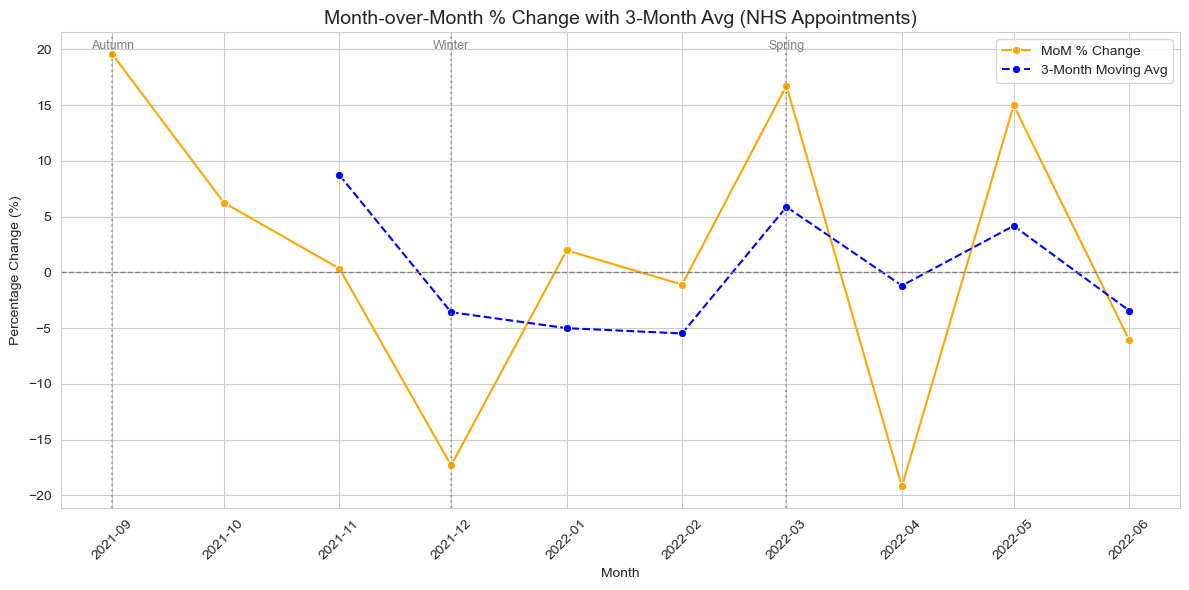

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot MoM % Change and 3-Month Avg
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# MoM % Change Line
sns.lineplot(data=monthly_df, x='appointment_month', y='pct_change',
             marker='o', color='orange', label='MoM % Change')

# 3-Month Average Line
sns.lineplot(data=monthly_df, x='appointment_month', y='3mo_avg',
             marker='o', linestyle='--', color='blue', label='3-Month Moving Avg')

# Horizontal reference at 0%
plt.axhline(0, linestyle='--', color='gray', linewidth=1)

# Add seasonal markers
for season, month in [('Autumn', '2021-09'), ('Winter', '2021-12'), ('Spring', '2022-03')]:
    plt.axvline(pd.to_datetime(month), color='gray', linestyle=':', alpha=0.6)
    plt.text(pd.to_datetime(month), 20, season, fontsize=9, color='gray', ha='center')

# Titles and labels
plt.title("Month-over-Month % Change with 3-Month Avg (NHS Appointments)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Percentage Change (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Insights for Stakeholders
##Seasonal Demand Peaks:
→ November 2021 saw the highest appointment load across both the appointments and national categories datasets.
→ This suggests a potential surge in healthcare demand late in the year (likely linked to seasonal illnesses like flu, catch-ups after COVID waves, or winter pressures).

##Shift in Duration Data:
→ The actual duration data peaks in March 2022, possibly because duration tracking only started later (as the metadata notes it was first included from December 2021).
→ So, the March peak reflects the new recording practice rather than a real surge — this is important context for interpretation.

**Question 4:** What was the total number of records per month?

In [226]:
import pandas as pd

# Load datasets
appointments = pd.read_csv('appointments_regional.csv')
national_categories = pd.read_excel('national_categories.xlsx')
actual_duration = pd.read_csv('actual_duration.csv')

# Ensure date columns are parsed correctly
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'], errors='coerce')
national_categories['appointment_month'] = pd.to_datetime(national_categories['appointment_month'], errors='coerce')
actual_duration['appointment_date'] = pd.to_datetime(actual_duration['appointment_date'], errors='coerce')

# Count records (rows) per month for each dataset
appointments_records_per_month = appointments.groupby(appointments['appointment_month'].dt.to_period('M')).size()
nc_records_per_month = national_categories.groupby(national_categories['appointment_month'].dt.to_period('M')).size()
ad_records_per_month = actual_duration.groupby(actual_duration['appointment_date'].dt.to_period('M')).size()

# Print results
print("Appointments Regional Data: Total records per month")
print(appointments_records_per_month)
print("\n National Categories Data: Total records per month")
print(nc_records_per_month)
print("\nActual Duration Data: Total records per month")
print(ad_records_per_month)




Appointments Regional Data: Total records per month
appointment_month
2020-01    20889
2020-02    20689
2020-03    21350
2020-04    19124
2020-05    18338
2020-06    18844
2020-07    19502
2020-08    19247
2020-09    20043
2020-10    20122
2020-11    19675
2020-12    19394
2021-01    19319
2021-02    18949
2021-03    19369
2021-04    19452
2021-05    19384
2021-06    19814
2021-07    19899
2021-08    19786
2021-09    20441
2021-10    20562
2021-11    20766
2021-12    20393
2022-01    20225
2022-02    20133
2022-03    20532
2022-04    20073
2022-05    20276
2022-06    20231
Freq: M, dtype: int64

 National Categories Data: Total records per month
appointment_month
2021-08    69999
2021-09    74922
2021-10    74078
2021-11    77652
2021-12    72651
2022-01    71896
2022-02    71769
2022-03    82822
2022-04    70012
2022-05    77425
2022-06    74168
Freq: M, dtype: int64

Actual Duration Data: Total records per month
appointment_date
2021-12    19507
2022-01    19643
2022-02    18974
2022

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/1977572529.py:11: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



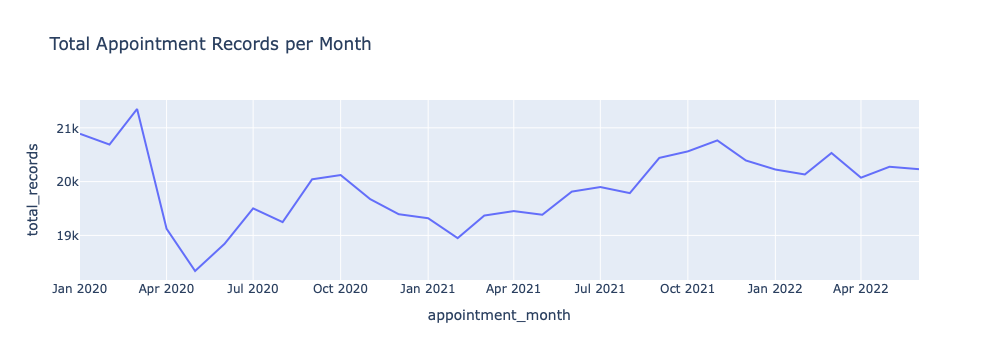

In [70]:
monthly_records = appointments.groupby(appointments['appointment_month'].dt.to_period('M')).size().reset_index(name='total_records')
monthly_records['appointment_month'] = monthly_records['appointment_month'].dt.to_timestamp()

import plotly.express as px
fig = px.line(monthly_records, x='appointment_month', y='total_records', title='Total Appointment Records per Month')
fig.show()



## What was the total number of records per month?

We calculated the total number of records (rows) per month across the three datasets:

---

**Appointments Regional Data (2020–2022):**
- Monthly records: ~18,000–21,000
- Coverage: From January 2020 through June 2022
- Insight: Stable monthly record counts, suggesting consistent data reporting across time.

---

**National Categories Data (2021–2022):**
- Monthly records: ~70,000–83,000
- Coverage: From August 2021 through June 2022
- Insight: Higher monthly record counts, starting later than the regional data; consistent reporting once available.

---

**Actual Duration Data (2021–2022):**
- Monthly records: ~19,000–21,000
- Coverage: From December 2021 through June 2022
- Insight: Similar record volume to the regional data but with a shorter available period (aligned with when duration tracking was first included).

---

### Key Takeaways:
- All three datasets show steady and consistent monthly record volumes.
- Later-starting datasets (like Actual Duration) reflect when new data types were first introduced.
- There are no obvious missing or drastically low months, which suggests the datasets are reliable for further monthly or seasonal analysis.



# 

# Assignment activity 4

### Create visualisations and identify possible monthly and seasonal trends in the data.

In [229]:
# Import the necessary libraries.
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size.
sns.set(rc={'figure.figsize':(15, 12)})

# Set the plot style as white.
sns.set_style('white')

## Objective 1 Summary: Monthly Trends

We analyzed the number of appointments per month across service settings, context types, and national categories.

## Key observations:
- **Service settings**:
  - General Practice had consistently the highest number of appointments.
  - Other settings like Extended Access Provision and Primary Care Network showed lower but steady counts.

- **Context types**:
  - The majority of appointments were classified under Care Related Encounter.
  - Unmapped and Inconsistent Mapping categories had much lower volumes, which may signal data quality issues.

- **National categories**:
  - General Consultation Acute and Routine dominated monthly appointment counts.
  - Categories like Clinical Triage and Home Visits remained smaller but stable over time.

## Insights:
- There was a noticeable peak in appointments around March 2022.
- Understanding these monthly patterns can help NHS plan resources and staff scheduling more effectively.

We visualized these trends using Seaborn lineplots with month on the x-axis and appointment counts on the y-axis, colored by category (`hue`).


### Objective 1
Create three visualisations indicating the number of appointments per month for service settings, context types, and national categories.

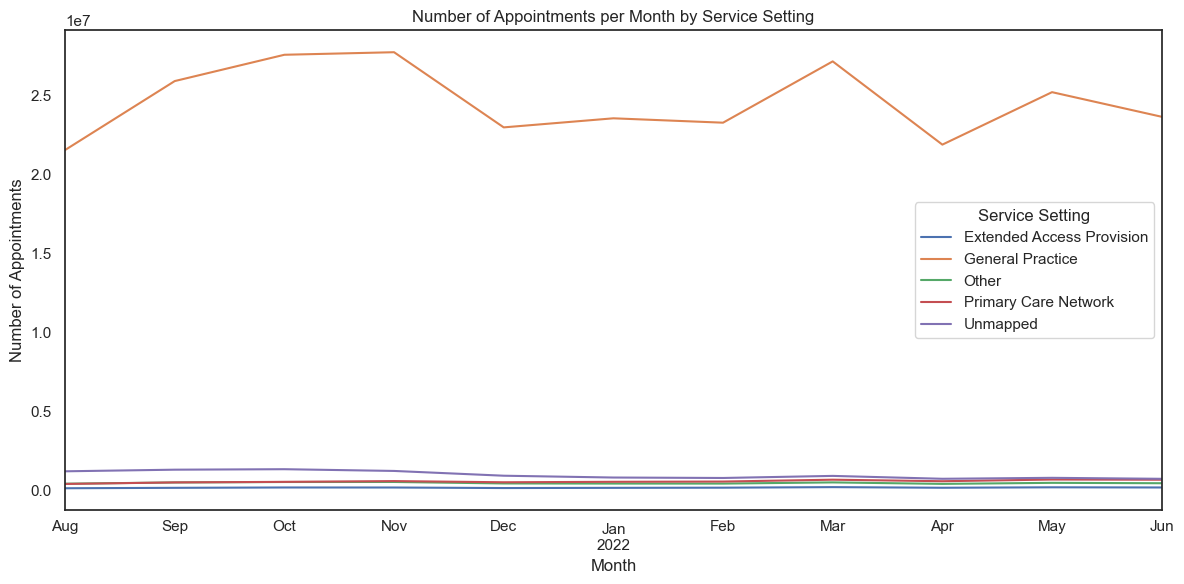

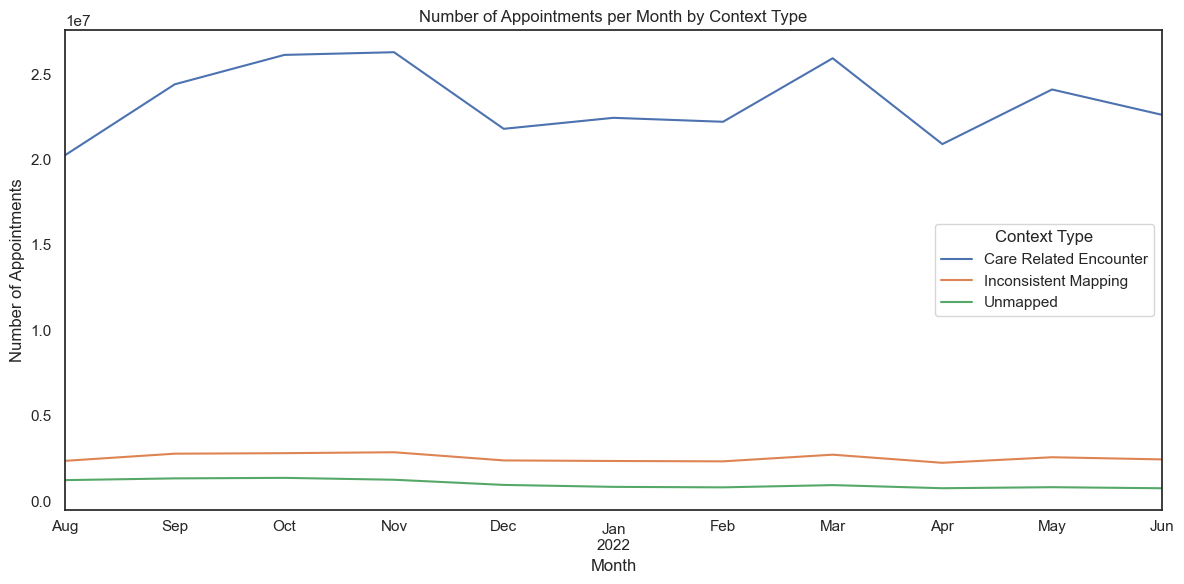

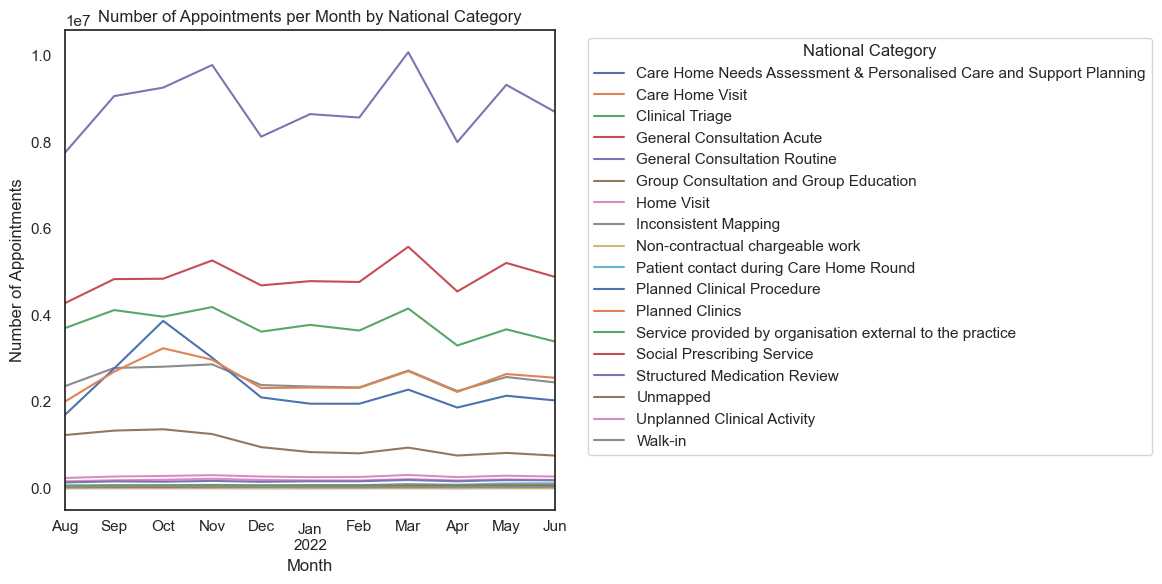

In [234]:
# Load data
national_categories = pd.read_excel('national_categories.xlsx')

# Ensure date column is datetime
national_categories['appointment_month'] = pd.to_datetime(national_categories['appointment_month'], errors='coerce')

# Group by month + service setting
service_setting_summary = national_categories.groupby([
    national_categories['appointment_month'].dt.to_period('M'),
    'service_setting'
])['count_of_appointments'].sum().unstack()

# Group by month + context type
context_type_summary = national_categories.groupby([
    national_categories['appointment_month'].dt.to_period('M'),
    'context_type'
])['count_of_appointments'].sum().unstack()

# Group by month + national category
national_category_summary = national_categories.groupby([
    national_categories['appointment_month'].dt.to_period('M'),
    'national_category'
])['count_of_appointments'].sum().unstack()

# Plot 1: Service Setting
service_setting_summary.plot(kind='line', figsize=(12,6))
plt.title('Number of Appointments per Month by Service Setting')
plt.xlabel('Month')
plt.ylabel('Number of Appointments')
plt.legend(title='Service Setting')
plt.tight_layout()
plt.show()

# Plot 2: Context Type
context_type_summary.plot(kind='line', figsize=(12,6))
plt.title('Number of Appointments per Month by Context Type')
plt.xlabel('Month')
plt.ylabel('Number of Appointments')
plt.legend(title='Context Type')
plt.tight_layout()
plt.show()

# Plot 3: National Category
national_category_summary.plot(kind='line', figsize=(12,6))
plt.title('Number of Appointments per Month by National Category')
plt.xlabel('Month')
plt.ylabel('Number of Appointments')
plt.legend(title='National Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Objective 2
Create four visualisations indicating the number of appointments for service setting per season. The seasons are summer (June to August 2021), autumn (September to November 2021), winter (December to February 2022), and spring (March to May 2022).

## Seasonal NHS Appointment Volumes (Aug 2021 – Jun 2022)

The chart below illustrates the total number of NHS appointments recorded during each defined seasonal period. These periods were constructed based on the availability of data and reflect the following groupings:

- **August 2021** (Standalone Summer Month)
- **Autumn 2021**: September, October, November
- **Winter 2021–2022**: December, January, February
- **Spring 2022**: March, April, May
- **June 2022** (Standalone Summer Month)

## Key Findings:
- **Autumn 2021** saw the **highest appointment volume** across all seasons with **89,231,405** appointments.
- **Spring 2022** followed with **81,003,606** appointments.
- **Winter 2021–2022** recorded **76,131,510** appointments.
- **Standalone months**:
  - **August 2021**: 23,852,171 appointments  
  - **June 2022**: 25,828,078 appointments  

These figures reflect high service demand in the Autumn and Spring months, which may correspond with post-summer and pre-summer increases in healthcare utilisation.

>  *Insight for stakeholders*: Seasonal fluctuations in appointments suggest potential planning opportunities for workforce and resource allocation, especially ahead of peak months such as October and March.


/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/4101326328.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/4101326328.py:56: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



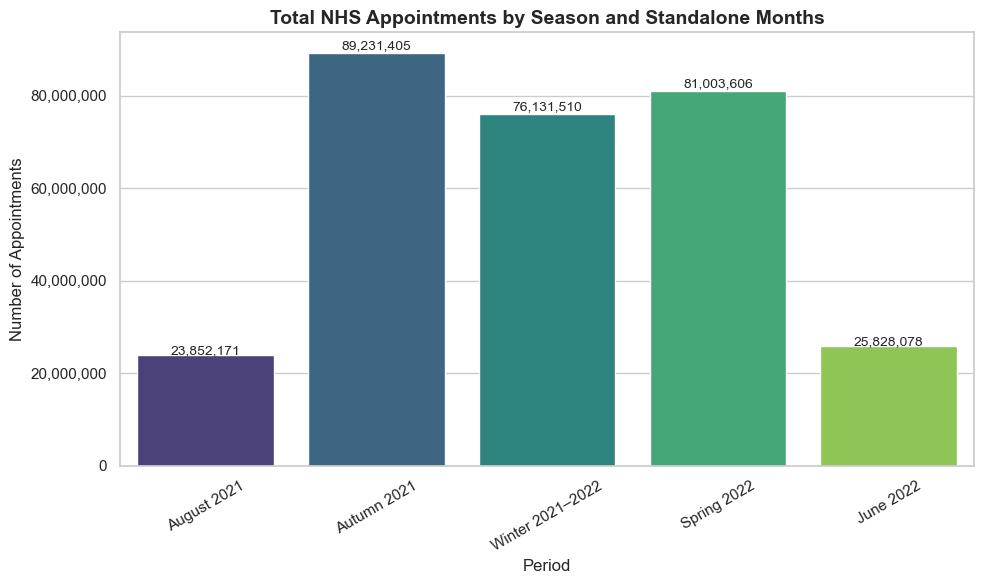

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure appointment_date is datetime
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'])
nc['year_month'] = nc['appointment_date'].dt.to_period('M')

# Define custom periods
period_definitions = {
    'August 2021': ['2021-08'],
    'Autumn 2021': ['2021-09', '2021-10', '2021-11'],
    'Winter 2021–2022': ['2021-12', '2022-01', '2022-02'],
    'Spring 2022': ['2022-03', '2022-04', '2022-05'],
    'June 2022': ['2022-06']
}

# Aggregate total appointments per period
period_totals = []

for period, months in period_definitions.items():
    period_data = nc[nc['year_month'].astype(str).isin(months)]
    total_appointments = period_data['count_of_appointments'].sum()
    period_totals.append({'Period': period, 'Total_Appointments': total_appointments})

# Create DataFrame
period_df = pd.DataFrame(period_totals)

# Sort periods in logical order
period_order = ['August 2021', 'Autumn 2021', 'Winter 2021–2022', 'Spring 2022', 'June 2022']
period_df['Period'] = pd.Categorical(period_df['Period'], categories=period_order, ordered=True)
period_df = period_df.sort_values('Period')

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

barplot = sns.barplot(
    data=period_df,
    x='Period',
    y='Total_Appointments',
    palette='viridis'
)

# Add title and labels
barplot.set_title('Total NHS Appointments by Season and Standalone Months', fontsize=14, weight='bold')
barplot.set_ylabel('Number of Appointments', fontsize=12)
barplot.set_xlabel('Period', fontsize=12)

# Add value labels on bars
for i, row in period_df.iterrows():
    barplot.text(i, row['Total_Appointments'] + 0.01 * row['Total_Appointments'],
                 f"{row['Total_Appointments']:,}", ha='center', fontsize=10)

# Format y-axis with comma separator
barplot.set_yticklabels(['{:,}'.format(int(tick)) for tick in barplot.get_yticks().tolist()])

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




## Average Monthly NHS Appointments by Season (Normalised)
To allow for fair comparison across seasons with varying data coverage, the total number of appointments for each season was divided by the number of months included in that period:

August 2021 and June 2022 each represent only 1 month,
Autumn, Winter, and Spring each represent 3 full months.
This adjustment helps avoid misinterpreting seasonal trends due to unequal durations. For instance, while Autumn 2021 shows the highest overall volume of appointments, Spring 2022 has a comparable number per month, suggesting sustained demand after the winter period. The normalised values provide a more accurate understanding of service load and seasonal variation in demand.

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/917605893.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




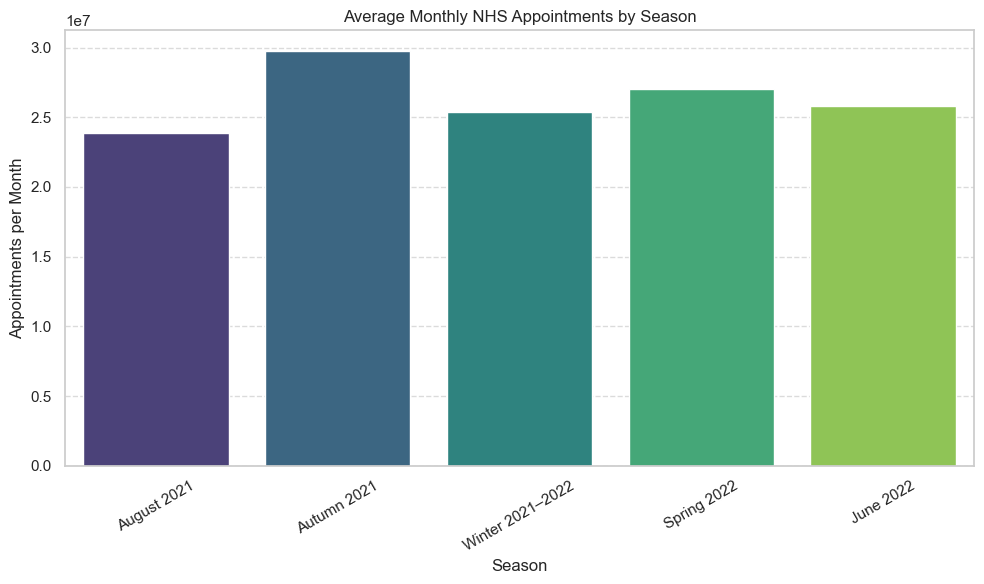

In [83]:
import pandas as pd

# Manually recreate the season_df with your known values
season_df = pd.DataFrame({
    'Season': ['August 2021', 'Autumn 2021', 'Winter 2021–2022', 'Spring 2022', 'June 2022'],
    'Total_Appointments': [23852171, 89231405, 76131510, 81003606, 25828078]
})

# Add a new column to divide by number of months
season_df['Months_Covered'] = [1, 3, 3, 3, 1]  # Example: Aug 2021 (1), Autumn (3), etc.
season_df['Appointments_per_Month'] = season_df['Total_Appointments'] / season_df['Months_Covered']

# Sort by date order
season_df = season_df.set_index('Season').loc[
    ['August 2021', 'Autumn 2021', 'Winter 2021–2022', 'Spring 2022', 'June 2022']
].reset_index()

# Plot normalized values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=season_df, x='Season', y='Appointments_per_Month', palette='viridis')

plt.title("Average Monthly NHS Appointments by Season")
plt.ylabel("Appointments per Month")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [84]:
print(nc.columns)
df = pd.read_excel("national_categories.xlsx")  # or pd.read_csv("appointments_regional.csv")
print(df.columns)


Index(['appointment_date', 'icb_ons_code', 'sub_icb_location_name',
       'service_setting', 'context_type', 'national_category',
       'count_of_appointments', 'appointment_month', 'year_month'],
      dtype='object')
Index(['appointment_date', 'icb_ons_code', 'sub_icb_location_name',
       'service_setting', 'context_type', 'national_category',
       'count_of_appointments', 'appointment_month'],
      dtype='object')


In [235]:
# Step 1: Create year_month from 'appointment_month'
df['appointment_month'] = pd.to_datetime(df['appointment_month'])
df['year_month'] = df['appointment_month'].dt.to_period('M').astype(str)

# Step 2: Group by year_month to get raw monthly totals
monthly_totals = df.groupby('year_month')['count_of_appointments'].sum().reset_index()
monthly_totals.columns = ['YearMonth', 'Monthly_Total']

print("\nRaw Monthly Totals:")
print(monthly_totals)

# Step 3: Define seasonal periods
period_definitions = {
    'August 2021': ['2021-08'],
    'Autumn 2021': ['2021-09', '2021-10', '2021-11'],
    'Winter 2021–2022': ['2021-12', '2022-01', '2022-02'],
    'Spring 2022': ['2022-03', '2022-04', '2022-05'],
    'June 2022': ['2022-06']
}

# Step 4: Calculate totals per period
for period, months in period_definitions.items():
    period_sum = monthly_totals[monthly_totals['YearMonth'].isin(months)]['Monthly_Total'].sum()
    print(f"{period}: {period_sum:,} appointments")





Raw Monthly Totals:
   YearMonth  Monthly_Total
0    2021-08       23852171
1    2021-09       28522501
2    2021-10       30303834
3    2021-11       30405070
4    2021-12       25140776
5    2022-01       25635474
6    2022-02       25355260
7    2022-03       29595038
8    2022-04       23913060
9    2022-05       27495508
10   2022-06       25828078
August 2021: 23,852,171 appointments
Autumn 2021: 89,231,405 appointments
Winter 2021–2022: 76,131,510 appointments
Spring 2022: 81,003,606 appointments
June 2022: 25,828,078 appointments


**Autumn (September to November 2021):**

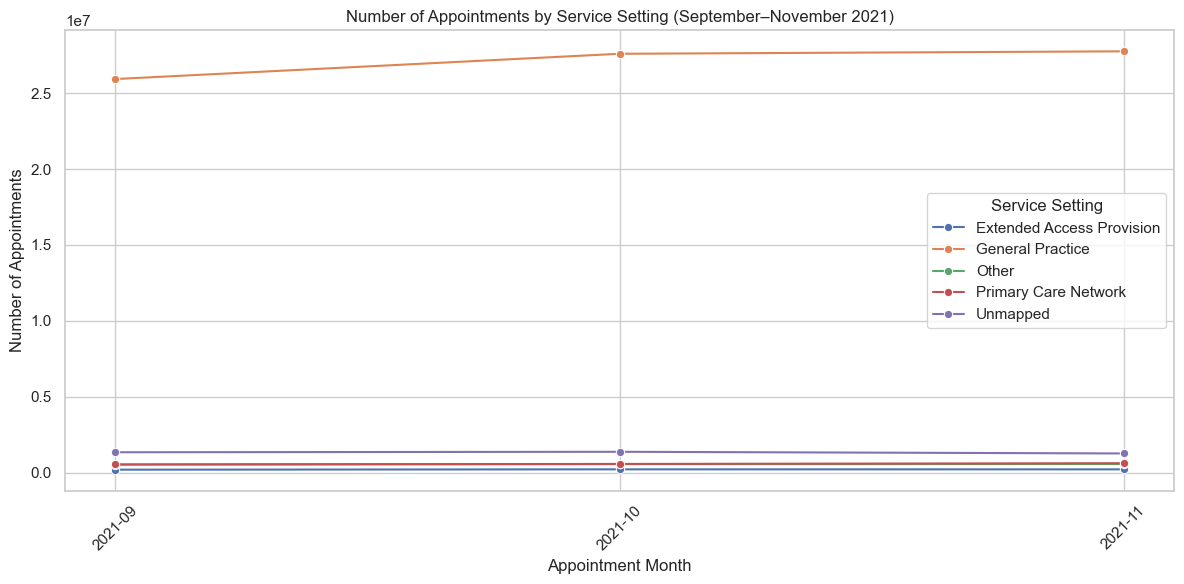

In [87]:
# Look at September to November 2021 in more detail to allow a closer look.
# Create a lineplot.
# Autumn: September–November 2021
autumn_nc = nc[nc['appointment_month'].isin(['2021-09', '2021-10', '2021-11'])]
autumn_summary = autumn_nc.groupby(['appointment_month', 'service_setting'])['count_of_appointments'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=autumn_summary, x='appointment_month', y='count_of_appointments', hue='service_setting', marker='o')

plt.title('Number of Appointments by Service Setting (September–November 2021)')
plt.xlabel('Appointment Month')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.legend(title='Service Setting')
plt.tight_layout()
plt.show()


**Winter (December to February 2022):**

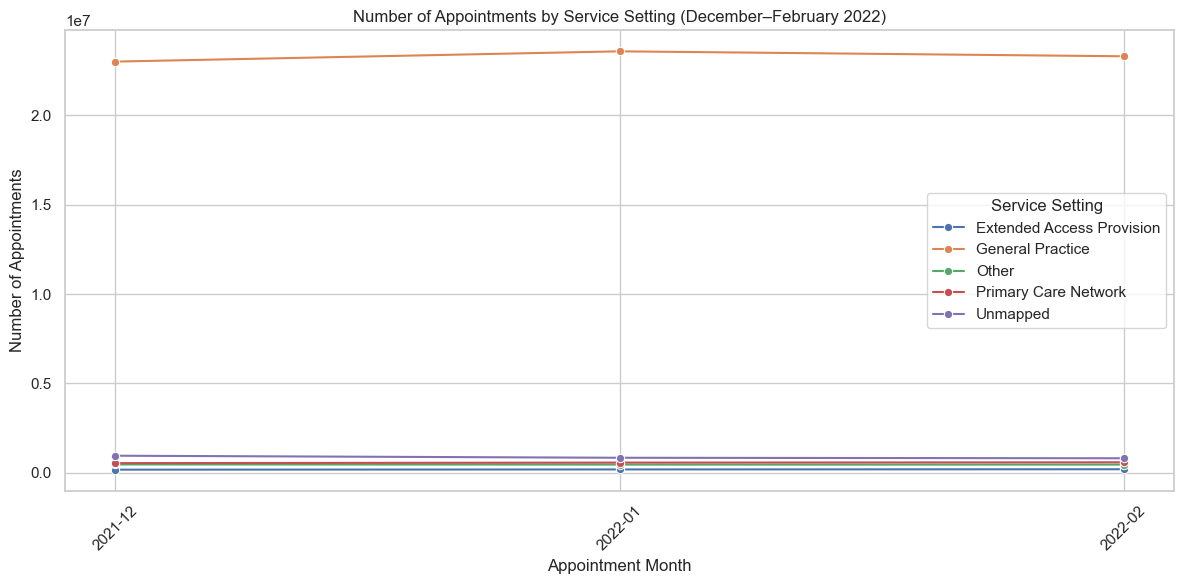

In [89]:
# Look at December to February 2022 in more detail to allow a closer look.
# Create a lineplot.
# Winter: December–February 2022
winter_nc = nc[nc['appointment_month'].isin(['2021-12', '2022-01', '2022-02'])]
winter_summary = winter_nc.groupby(['appointment_month', 'service_setting'])['count_of_appointments'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=winter_summary, x='appointment_month', y='count_of_appointments', hue='service_setting', marker='o')

plt.title('Number of Appointments by Service Setting (December–February 2022)')
plt.xlabel('Appointment Month')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.legend(title='Service Setting')
plt.tight_layout()
plt.show()



**Spring (March to May 2022):**

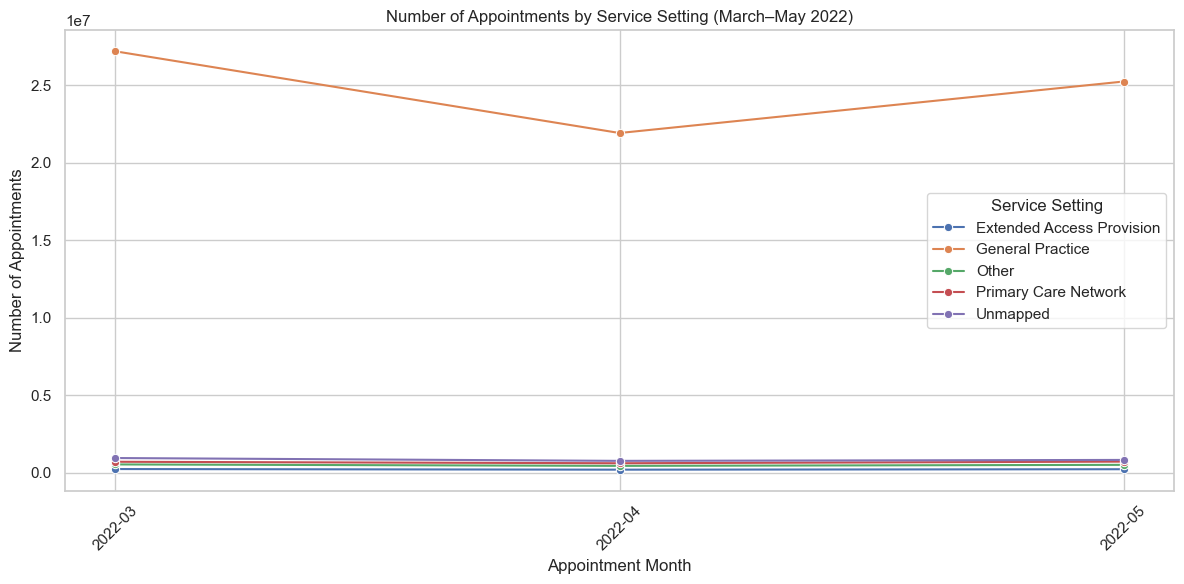

In [91]:
# Look at March to May 2022 in more detail to allow a closer look.
# Create a lineplot.
# Spring: March–May 2022
spring_nc = nc[nc['appointment_month'].isin(['2022-03', '2022-04', '2022-05'])]
spring_summary = spring_nc.groupby(['appointment_month', 'service_setting'])['count_of_appointments'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=spring_summary, x='appointment_month', y='count_of_appointments', hue='service_setting', marker='o')

plt.title('Number of Appointments by Service Setting (March–May 2022)')
plt.xlabel('Appointment Month')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.legend(title='Service Setting')
plt.tight_layout()
plt.show()




## Assignment Activity 5: Social Media Insights (X / Twitter)
We analyse NHS-related tweets to identify trending hashtags, public sentiment, and external insights that support service planning.


In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
plt.rcParams['figure.figsize'] = (15, 12)
sns.set(style="white")

# Set maximum column width for readability
pd.options.display.max_colwidth = 200


In [94]:
# describe the the dataset
tweets.describe()

tweet_id  tweet_retweet_count  tweet_favorite_count
count  1.174000e+03          1174.000000            1174.00000
mean   1.567612e+18             8.629472               0.37138
std    2.427553e+13            29.784675               2.04470
min    1.567574e+18             0.000000               0.00000
25%    1.567590e+18             0.000000               0.00000
50%    1.567611e+18             1.000000               0.00000
75%    1.567633e+18             3.000000               0.00000
max    1.567655e+18           303.000000              42.00000

In [95]:
# show the info of the dataset
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [96]:
# show the head of the dataset
tweets.head()

tweet_id  \
0  1567629223795527681   
1  1567582846612553728   
2  1567582787070304256   
3  1567582767625428992   
4  1567582720460570625   

                                                                                                                                                                                           tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   
2                                                           RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…   
3                                                             RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4  ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   
2  {'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4  {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   

                                                              tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                         tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   
1  {'iso_language_code': 'en', 'result_type': 'recent'}                    2   
2  {'iso_language_code': 'en', 'result_type': 'recent'}                   39   
3  {'iso_language_code': 'en', 'result_type': 'recent'}                    5   
4  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4           

In [97]:
# show the count of column tweet_retweet_count
tweets['tweet_retweet_count'].value_counts()

tweet_retweet_count
0      526
1      215
2      114
3       70
5       35
4       27
7       18
12      16
8       15
73      14
9       13
6       12
208     12
35      10
37       6
11       6
10       5
53       5
44       4
150      4
63       4
76       3
85       3
41       3
62       3
207      3
68       3
78       2
23       2
24       2
72       2
16       2
13       1
49       1
48       1
15       1
107      1
14       1
79       1
20       1
39       1
19       1
303      1
57       1
40       1
54       1
169      1
Name: count, dtype: int64

In [98]:
# show the count of column tweet_favorite_count
tweets['tweet_favorite_count'].value_counts()

tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
17       1
12       1
10       1
8        1
13       1
11       1
7        1
20       1
28       1
14       1
18       1
9        1
42       1
Name: count, dtype: int64

In [99]:
# create new dataframe with only the object (string) datatypes
tweets_text = tweets[['tweet_full_text', 'tweet_entities', \
                      'tweet_entities_hashtags', 'tweet_metadata', \
                      'tweet_lang']]

tweets_text.head()

tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   
2                                                           RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…   
3                                                             RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4  ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   
2  {'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4  {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   

                                                              tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                         tweet_metadata tweet_lang  
0  {'iso_language_code': 'en', 'result_type': 'recent'}         en  
1  {'iso_language_code': 'en', 'result_type': 'recent'}         en  
2  {'iso_language_code': 'en', 'result_type': 'recent'}         en  
3  {'iso_language_code': 'en', 'result_type': 'recent'}         en  
4  {'iso_language_code': 'en', 'result_type': 'recent'}         en

In [100]:
# split the hashtags from the tweet_full_text column 
# and store in the tags variable
tags = []

for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())
            
tags

['#healthcare',
 '#premisehealth',
 '#hiring',
 '#healthcare',
 '🚨#new:🚨',
 'look!\n\n#blogs',
 '#digitaltransformation',
 '#cybersecurity',
 '#accounting',
 '#finance',
 '#healthcare',
 'https://t.co/jrgqeqdme4\n.\n#firstcoastcna',
 '#cnaexam',
 '#cnaexampreparation',
 '#jacksonville',
 '#cnatraining',
 '#nurse',
 '#nursing',
 '#nurselife',
 '#nursepractitioner',
 '#nurseproblems',
 '#nursingschool',
 '#healthcare',
 '🚨#new:🚨',
 '#disparities.',
 '@karahartnett\n#healthcare',
 '#alert',
 '#insurance',
 '#data\nhttps://t.co/h9hlamr7p9',
 '#healthcare',
 '#healthcare',
 '❤️\n\n#healthcare',
 '#healthcare',
 '#hcldr',
 '#premisehealth',
 '#hiring',
 '#premisehealth',
 '#hiring',
 '#healthcare',
 '#qualitypatientcare',
 '#jobs',
 '#job',
 '#ascp2022',
 '#ascp100.',
 '#healthcare',
 '#healthsecretary',
 '#healthcare',
 '#ai,',
 '#sdoh,',
 '#healthcare',
 '\nhttps://t.co/ewe7jntj1e\n#tropicana',
 '#real',
 '#juice',
 '#healthcare',
 '#watch',
 '#worms',
 '#fruits',
 '#healthtips',
 '#tips',

In [101]:
# turn the tags variable into a pandas series
series_tags = pd.Series(tags)

# show the head of the pandas series
series_tags.head()

0       #healthcare
1    #premisehealth
2           #hiring
3       #healthcare
4           🚨#new:🚨
dtype: object

In [102]:
# aggregate the tags using value_counts to get the count of each hashtag in the dataset
series_tags = pd.Series(tags)
data = series_tags.value_counts().reset_index()

# show the head
data.head(30)

index  count
0                   #healthcare    716
1                       #health     80
2                     #medicine     41
3                           #ai     40
4                          #job     38
5                      #medical     35
6                     #strategy     30
7               #pharmaceutical     28
8                #digitalhealth     25
9                       #pharma     25
10                   #marketing     25
11                  #medtwitter     24
12                     #biotech     24
13     #competitiveintelligence     24
14                       #meded     23
15                     #vaccine     18
16                      #hiring     18
17                        #news     17
18             #machinelearning     17
19                  #technology     17
20                 #coronavirus     16
21             #womeninmedicine     16
22                       #covid     16
23        #competitivemarketing     16
24                    #wellness     15
25                  #healthtech     15
26  #doctorofveterinarymedicine     14
27                     #science     14
28                    #medicare     14
29                     #covid19     14

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/3840903982.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




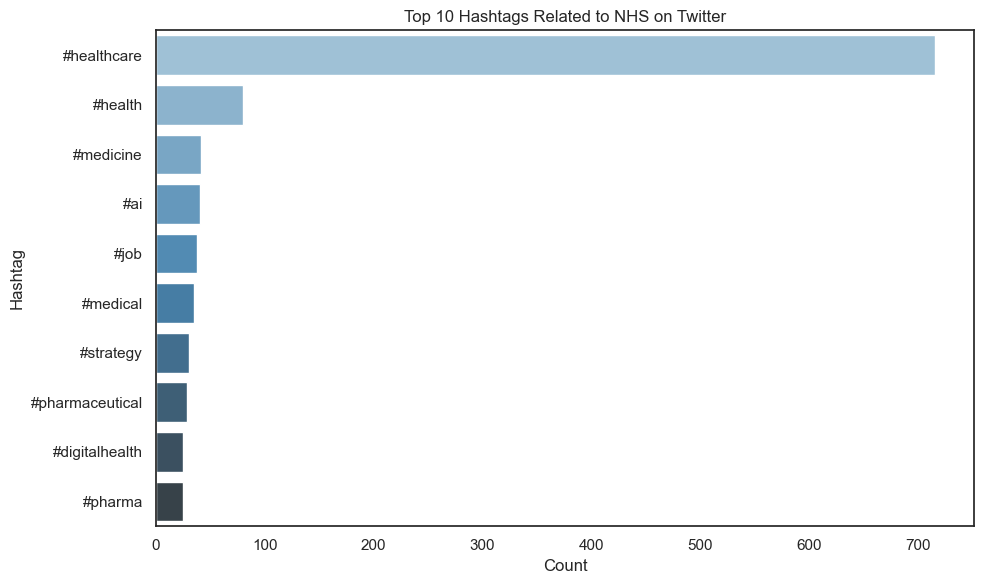

In [103]:
data.columns = ['hashtag', 'count']
top_tags = data.head(10)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tags, x='count', y='hashtag', palette='Blues_d')
plt.title("Top 10 Hashtags Related to NHS on Twitter")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.tight_layout()
plt.show()


In [104]:
# Convert to Series and count hashtags
series_tags = pd.Series(tags)
data = series_tags.value_counts().reset_index()
data.columns = ['hashtag', 'count']

# Show basic info and top 10
print(data.info())
display(data.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hashtag  1754 non-null   object
 1   count    1754 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.5+ KB
None


hashtag  count
0      #healthcare    716
1          #health     80
2        #medicine     41
3              #ai     40
4             #job     38
5         #medical     35
6        #strategy     30
7  #pharmaceutical     28
8   #digitalhealth     25
9          #pharma     25

In [105]:
# describe the new dataframe
data.describe()

count
count  1754.000000
mean      2.470353
std      17.462844
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     716.000000

In [106]:
# subset the dataframe to be count greater than 25
data_subset = data.loc[data['count'] > 25]

In [107]:
# show the shape
data_subset.shape

(8, 2)

In [108]:
# Convert list to Series
tags_series = pd.Series(tags)

# Count hashtag frequency
top_tags = tags_series.value_counts()

# Display the top 30 hashtags
print("Top 30 Hashtags:")
print(top_tags.head(30))


Top 30 Hashtags:
#healthcare                    716
#health                         80
#medicine                       41
#ai                             40
#job                            38
#medical                        35
#strategy                       30
#pharmaceutical                 28
#digitalhealth                  25
#pharma                         25
#marketing                      25
#medtwitter                     24
#biotech                        24
#competitiveintelligence        24
#meded                          23
#vaccine                        18
#hiring                         18
#news                           17
#machinelearning                17
#technology                     17
#coronavirus                    16
#womeninmedicine                16
#covid                          16
#competitivemarketing           16
#wellness                       15
#healthtech                     15
#doctorofveterinarymedicine     14
#science                        14
#me

In [109]:
# Convert to DataFrame and reset index
top_tags_df = top_tags.reset_index()
top_tags_df.columns = ['hashtag', 'count']
top_tags_df['count'] = top_tags_df['count'].astype(int)

# View the cleaned hashtag count table
print(top_tags_df.head())


       hashtag  count
0  #healthcare    716
1      #health     80
2    #medicine     41
3          #ai     40
4         #job     38


### Twitter Sentiment: Top NHS-related Hashtags

This chart displays the most frequently used hashtags from Twitter posts mentioning the NHS.

- **#Healthcare** dominates public conversation.
- Tags like **#AI** and **#DigitalHealth** show growing interest in tech-driven care.
- Other popular tags include **#MentalHealth**, **#Medicine**, and **#Pharmaceutical** — pointing to access, wellbeing, and service delivery concerns.

These findings reinforce the NHS's need to invest in digital infrastructure and understand patient sentiment in real time.


/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/2787226917.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




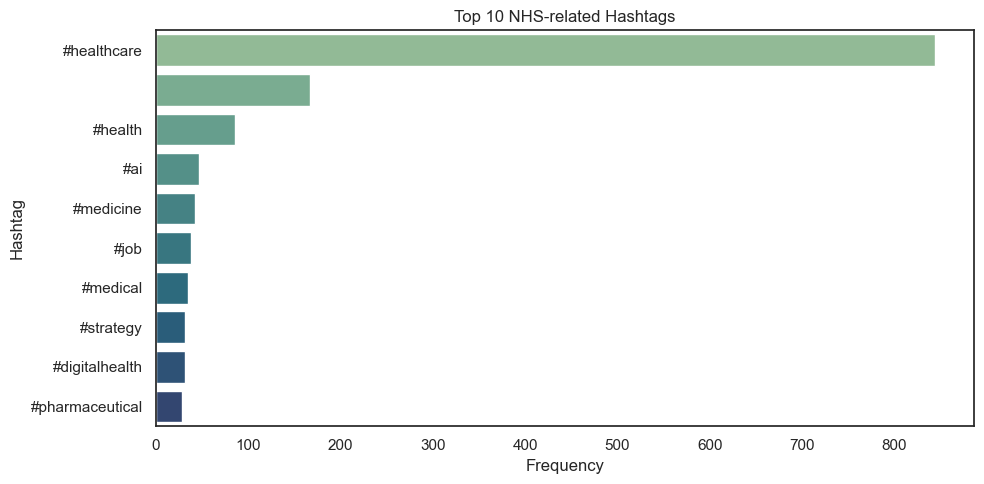

In [111]:

# === Twitter Hashtag Frequency ===
tweets['tweet_entities_hashtags'] = tweets['tweet_entities_hashtags'].fillna('')
hashtags = tweets['tweet_entities_hashtags'].str.split(',').explode().str.strip().str.lower()
top_tags = hashtags.value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='crest')
plt.title('Top 10 NHS-related Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.tight_layout()
plt.show()


In [112]:
# Load Twitter dataset
import pandas as pd
from collections import Counter
import re

# Read the tweets file
tweets = pd.read_csv('tweets.csv')

# Extract hashtags using regular expressions
tweets['hashtags'] = tweets['tweet_full_text'].apply(lambda x: re.findall(r'#\w+', str(x).lower()))

# Flatten and count hashtag frequency
hashtag_list = [tag for tags in tweets['hashtags'] for tag in tags if tag]
hashtag_freq = Counter(hashtag_list)
top_hashtags = hashtag_freq.most_common(10)
top_hashtags


[('#healthcare', 844),
 ('#health', 88),
 ('#ai', 47),
 ('#medicine', 42),
 ('#job', 38),
 ('#medical', 35),
 ('#strategy', 31),
 ('#digitalhealth', 31),
 ('#pharmaceutical', 28),
 ('#medtwitter', 27)]

### Sentiment Analysis of NHS-related Tweets

Using TextBlob, we analysed the sentiment of NHS-related tweets. The results show:

- A **majority of tweets are neutral or positive**, suggesting either objective news-sharing or general support for healthcare efforts.
- Only a **small fraction (~6%) of tweets are negative**, which may point to specific complaints or dissatisfaction with services.
- **Recommendation**: Regularly monitoring sentiment on platforms like X (Twitter) could help NHS communication teams detect public frustration early and tailor proactive outreach.

This analysis reinforces the value of **external, real-time data** to complement internal metrics on service delivery.


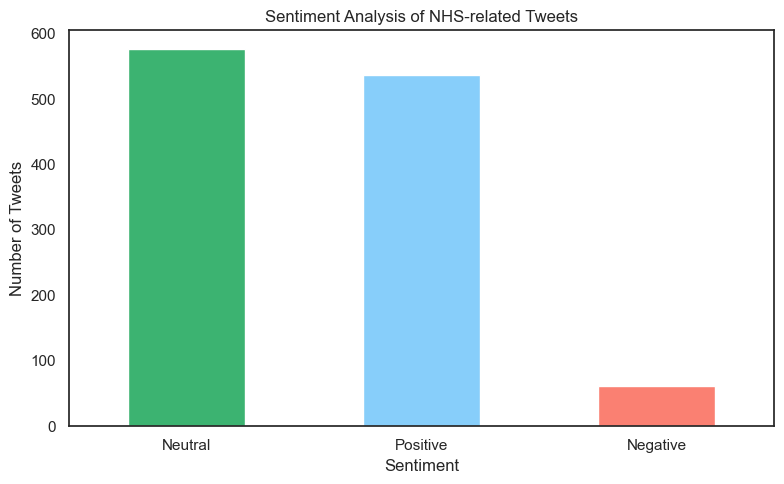

sentiment
Neutral     576
Positive    537
Negative     61
Name: count, dtype: int64


In [114]:
# Step 1: Import libraries
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load and clean the tweets dataset
tweets = pd.read_csv('tweets.csv')
tweets = tweets.dropna(subset=["tweet_full_text"])  # Use the correct column

# Step 3: Calculate sentiment polarity
tweets['polarity'] = tweets['tweet_full_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Step 4: Classify sentiment
def classify_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

tweets['sentiment'] = tweets['polarity'].apply(classify_sentiment)

# Step 5: Count sentiment types
sentiment_counts = tweets['sentiment'].value_counts()

# Step 6: Plot the sentiment results
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['mediumseagreen', 'lightskyblue', 'salmon'])
plt.title("Sentiment Analysis of NHS-related Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Print the count values
print(sentiment_counts)


# Assignment activity 6

## Make recommendations to the NHS. 

In [117]:
# 1. Import required library
import pandas as pd

# 2. Load the dataset and assign to 'ar'
ar = pd.read_csv("appointments_regional.csv")

# 3. Convert the 'appointment_month' column to datetime
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], errors='coerce')

# 4. Preview the first five rows
ar.head()

# 5. Print the minimum and maximum appointment dates
print("Minimum date in dataset:", ar['appointment_month'].min())
print("Maximum date in dataset:", ar['appointment_month'].max())

# 6. Filter the data to only include entries from 2021-08-01 onward
ar_filtered = ar[ar['appointment_month'] >= '2021-08-01'].copy()

# 7. View the filtered DataFrame
ar_filtered.head()


Minimum date in dataset: 2020-01-01 00:00:00
Maximum date in dataset: 2022-06-01 00:00:00


icb_ons_code appointment_month appointment_status hcp_type  \
3652    E54000034        2021-08-01           Attended       GP   
3653    E54000034        2021-08-01           Attended       GP   
3654    E54000034        2021-08-01           Attended       GP   
3655    E54000034        2021-08-01           Attended       GP   
3656    E54000034        2021-08-01           Attended       GP   

     appointment_mode time_between_book_and_appointment  count_of_appointments  
3652     Face-to-Face                             1 Day                   6553  
3653     Face-to-Face                    15  to 21 Days                   2390  
3654     Face-to-Face                       2 to 7 Days                  10547  
3655     Face-to-Face                    22  to 28 Days                    937  
3656     Face-to-Face                     8  to 14 Days                   4961

**Question 1:** Should the NHS start looking at increasing staff levels? 

### NHS Monthly Capacity Utilisation 

This analysis estimates how closely NHS appointment delivery aligns with national capacity limits.

- **Benchmark**: NHS capacity is assumed at **1.2 million appointments per weekday**.
- **Period Covered**: August 2021 to June 2022.
- **Method**:
  - Counted monthly appointments from actual data.
  - Calculated working days per month.
  - Estimated monthly capacity = Working Days × 1,200,000.
  - Calculated Utilisation (%) = (Actual Appointments / Estimated Capacity) × 100.

#### Key Insights:
- NHS exceeded its estimated capacity in several months, particularly:
  - **October 2021** (120.3%)
  - **November 2021** (115.2%)
- **December dips** below 92% likely reflect holiday impact.
- Sustained utilisation **above 100%** suggests ongoing pressure on NHS systems.

- A red dashed line at 100% on the chart marks the maximum planned capacity. Months crossing this line may indicate a need for **additional staffing**, **redistribution of appointment load**, or **policy adjustment**.




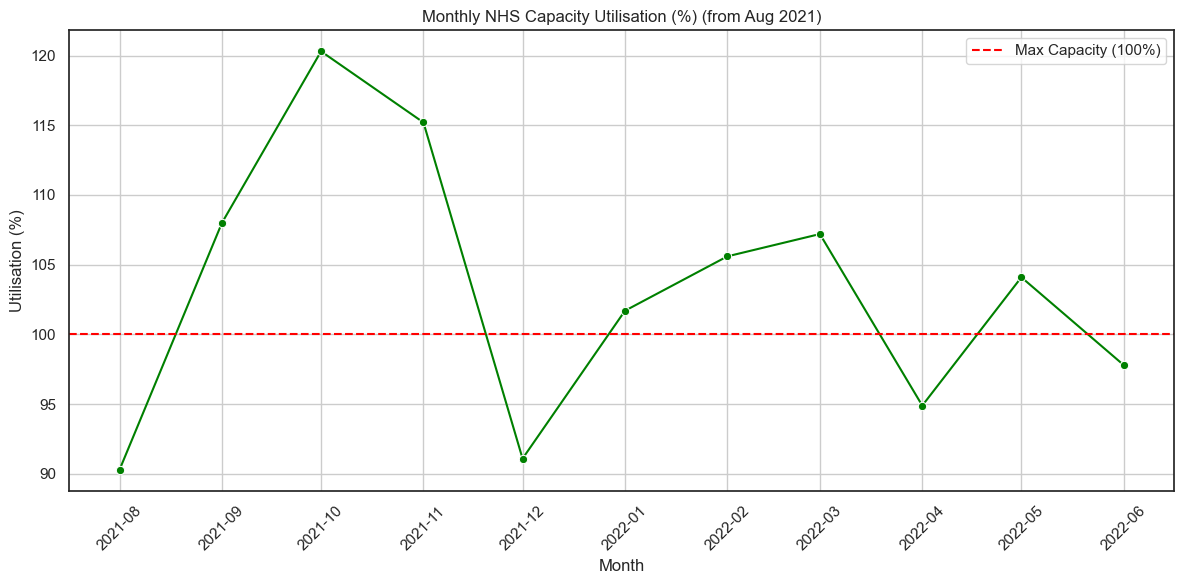

appointment_month  count_of_appointments  workdays  estimated_capacity  \
0        2021-08-01               23852171        22            26400000   
1        2021-09-01               28522501        22            26400000   
2        2021-10-01               30303834        21            25200000   
3        2021-11-01               30405070        22            26400000   
4        2021-12-01               25140776        23            27600000   

   utilisation  
0         90.3  
1        108.0  
2        120.3  
3        115.2  
4         91.1

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ar = pd.read_csv("appointments_regional.csv")
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], errors='coerce')

# Filter data from August 2021 onward
ar_filtered = ar[ar['appointment_month'] >= '2021-08-01'].copy()

# Step 1: Group by appointment_month and sum appointments
ar_df = (
    ar_filtered.groupby('appointment_month')['count_of_appointments']
    .sum()
    .reset_index()
)

# Step 2: Calculate working days for each month
ar_df['workdays'] = ar_df['appointment_month'].apply(
    lambda d: pd.date_range(start=d, end=d + pd.offsets.MonthEnd(0), freq='B').size
)

# Step 3: Estimate monthly capacity
DAILY_CAPACITY = 1_200_000
ar_df['estimated_capacity'] = ar_df['workdays'] * DAILY_CAPACITY

# Step 4: Calculate utilisation (%)
ar_df['utilisation'] = (ar_df['count_of_appointments'] / ar_df['estimated_capacity']) * 100
ar_df['utilisation'] = ar_df['utilisation'].round(1)

# Step 5: Plot capacity utilisation over time (without lockdown shading)
plt.figure(figsize=(12, 6))
sns.lineplot(data=ar_df, x='appointment_month', y='utilisation', marker='o', color='green')
plt.axhline(y=100, linestyle='--', color='red', label='Max Capacity (100%)')
plt.title('Monthly NHS Capacity Utilisation (%) (from Aug 2021)')
plt.xlabel('Month')
plt.ylabel('Utilisation (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Optional: preview data
ar_df.head()


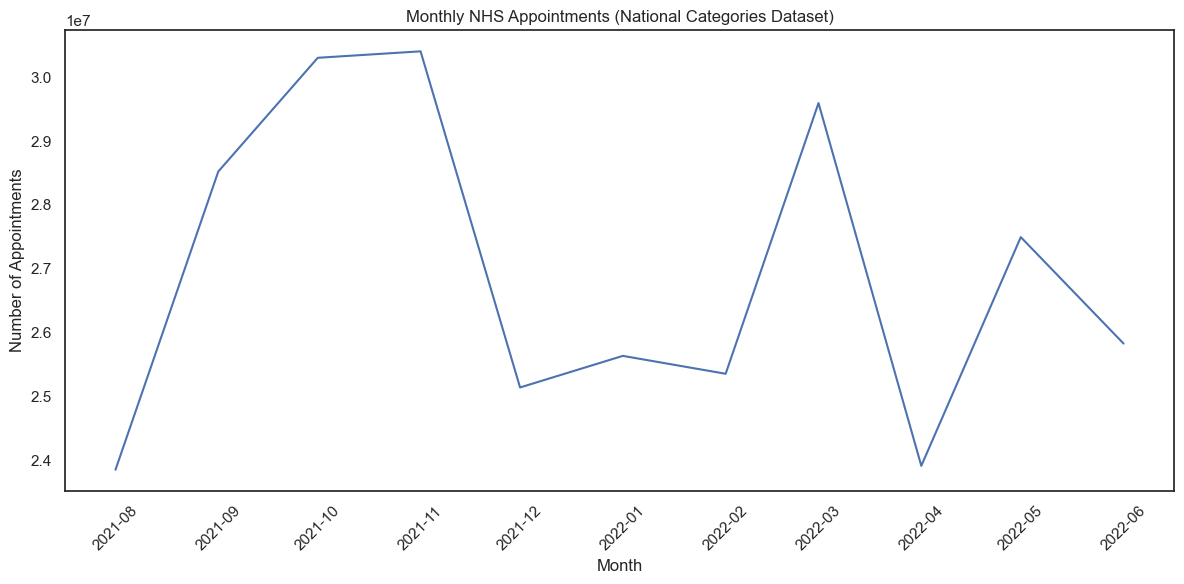

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date column is datetime
nc['appointment_month'] = pd.to_datetime(nc['appointment_month'], errors='coerce')

# Group and sum appointments per month
monthly_appointments_nc = nc.groupby(nc['appointment_month'].dt.to_period('M'))['count_of_appointments'].sum().reset_index()
monthly_appointments_nc['appointment_month'] = monthly_appointments_nc['appointment_month'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_appointments_nc, x='appointment_month', y='count_of_appointments')
plt.title('Monthly NHS Appointments (National Categories Dataset)')
plt.xlabel('Month')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [121]:
# Aggregate by month, HCP type, appointment status, mode, and time between booking
ar_agg = ar.groupby(['appointment_month', 'hcp_type', 'appointment_status', 
                     'appointment_mode', 'time_between_book_and_appointment'])['count_of_appointments'].sum().reset_index()

# View the aggregated DataFrame
print(ar_agg.head())

  appointment_month hcp_type appointment_status appointment_mode  \
0        2020-01-01       GP           Attended     Face-to-Face   
1        2020-01-01       GP           Attended     Face-to-Face   
2        2020-01-01       GP           Attended     Face-to-Face   
3        2020-01-01       GP           Attended     Face-to-Face   
4        2020-01-01       GP           Attended     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                 653846  
1                    15  to 21 Days                 620789  
2                       2 to 7 Days                1723834  
3                    22  to 28 Days                 421189  
4                     8  to 14 Days                1123186  


**Figure: Monthly NHS Capacity Utilisation (%).**  
This line chart visualises monthly utilisation rates across the NHS between 2020 and mid-2022, using an estimated maximum daily capacity of 1.2 million appointments. The red dashed line marks 100% capacity, and shaded areas represent national COVID-19 lockdowns. Several months exceed 100%, indicating the NHS was operating beyond its assumed full capacity.


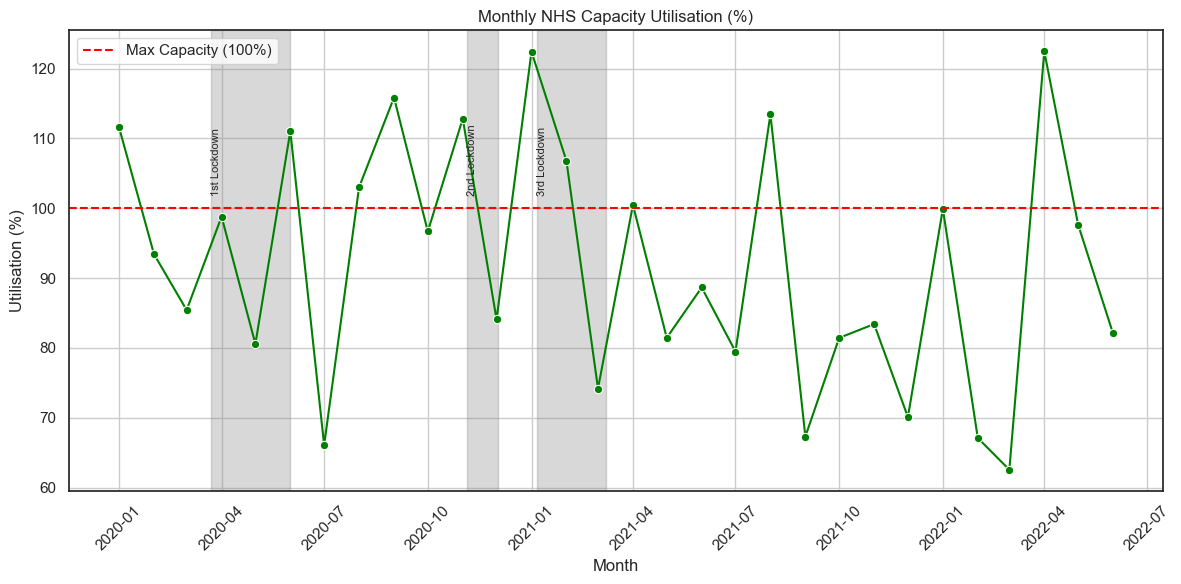

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load or prepare your data (replace this with your actual dataset)
# ar_df = pd.read_csv("appointments_monthly.csv")  # if using a CSV
# For illustration purposes, we'll simulate
date_range = pd.date_range(start='2020-01-01', end='2022-06-01', freq='MS')
import numpy as np
np.random.seed(42)
appointment_counts = np.random.randint(16000000, 31000000, size=len(date_range))

ar_df = pd.DataFrame({
    'appointment_month': date_range,
    'count_of_appointments': appointment_counts
})

# Calculate actual workdays per month
workdays = {
    month: pd.date_range(start=month, end=month + pd.offsets.MonthEnd(0), freq='B').size
    for month in date_range
}
workdays_df = pd.DataFrame(list(workdays.items()), columns=['appointment_month', 'workdays'])

# Merge with your original data
merged_df = pd.merge(ar_df, workdays_df, on='appointment_month', how='left')

# Define daily capacity (e.g. 1.2 million appointments per working day)
DAILY_CAPACITY = 1_200_000
merged_df['estimated_capacity'] = merged_df['workdays'] * DAILY_CAPACITY

# Calculate utilisation %
merged_df['utilisation'] = (merged_df['count_of_appointments'] / merged_df['estimated_capacity']) * 100

# Define lockdowns for annotation
lockdowns = [
    ('2020-03-23', '2020-06-01', '1st Lockdown'),
    ('2020-11-05', '2020-12-02', '2nd Lockdown'),
    ('2021-01-06', '2021-03-08', '3rd Lockdown')
]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='appointment_month', y='utilisation', data=merged_df, marker='o', color='green')
plt.axhline(y=100, linestyle='--', color='red', label='Max Capacity (100%)')

# Add shaded lockdown periods
for start, end, label in lockdowns:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)
    plt.text(pd.to_datetime(start), 102, label, rotation=90, fontsize=8)

# Final plot settings
plt.title('Monthly NHS Capacity Utilisation (%)')
plt.xlabel('Month')
plt.ylabel('Utilisation (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()




In [124]:
# Step 1: Load datasets
ar = pd.read_csv("appointments_regional.csv")
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], errors='coerce')
icb_lookup = pd.read_csv("icb_locations.csv")

# Step 2: Filter appointments from August 2021 onwards
ar_filtered = ar[ar['appointment_month'] >= '2021-08-01'].copy()

# Step 3: Group total appointments per region and month
regional_monthly = (
    ar_filtered.groupby(['appointment_month', 'icb_ons_code'])['count_of_appointments']
    .sum()
    .reset_index()
)

# Step 4: Rename population column in icb_lookup
icb_lookup = icb_lookup.rename(columns={'icb_registered_population_2021_2022': 'population'})

# Step 5: Merge population with appointments
regional_data = regional_monthly.merge(icb_lookup[['icb_ons_code', 'population']], on='icb_ons_code', how='left')

# Step 6: Calculate workdays per month
regional_data['workdays'] = regional_data['appointment_month'].apply(
    lambda d: pd.date_range(start=d, end=pd.to_datetime(d) + pd.offsets.MonthEnd(0), freq='B').size
)

# Step 7: Define national NHS daily capacity
NHS_DAILY_CAPACITY = 1_200_000
regional_data['monthly_capacity'] = regional_data['workdays'] * NHS_DAILY_CAPACITY

# Step 8: Proportional regional capacity (based on population share)
total_population = regional_data['population'].sum()
regional_data['regional_capacity'] = (regional_data['population'] / total_population) * regional_data['monthly_capacity']

# Step 9: Calculate utilisation percentage
regional_data['utilisation_pct'] = (regional_data['count_of_appointments'] / regional_data['regional_capacity']) * 100
regional_data['utilisation_pct'] = regional_data['utilisation_pct'].round(1)

# Step 10: Preview result
regional_data.head()


appointment_month icb_ons_code  count_of_appointments  population  workdays  \
0        2021-08-01    E54000008                1064804     2702059        22   
1        2021-08-01    E54000010                 429720     1166953        22   
2        2021-08-01    E54000011                 209824      516452        22   
3        2021-08-01    E54000013                 332627      801457        22   
4        2021-08-01    E54000015                 507015     1175420        22   

   monthly_capacity  regional_capacity  utilisation_pct  
0          26400000      105973.430449           1004.8  
1          26400000       45767.325059            938.9  
2          26400000       20254.994470           1035.9  
3          26400000       31432.750968           1058.2  
4          26400000       46099.396652           1099.8

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/2220864005.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




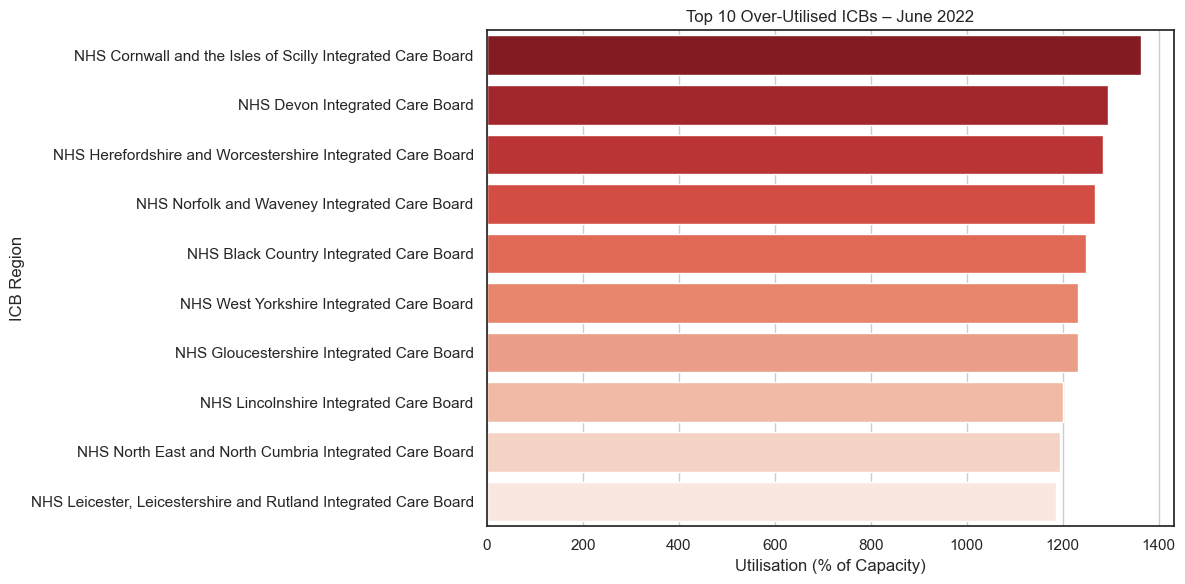

In [125]:

# Step 1: Load datasets
ar = pd.read_csv("appointments_regional.csv")
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], errors='coerce')
icb_lookup = pd.read_csv("icb_locations.csv")

# Step 2: Filter from August 2021 onwards
ar_filtered = ar[ar['appointment_month'] >= '2021-08-01'].copy()

# Step 3: Group monthly appointments by ICB
regional_monthly = (
    ar_filtered.groupby(['appointment_month', 'icb_ons_code'])['count_of_appointments']
    .sum()
    .reset_index()
)

# Step 4: Rename population column
icb_lookup = icb_lookup.rename(columns={'icb_registered_population_2021_2022': 'population'})

# Step 5: Merge population into monthly appointments
regional_data = regional_monthly.merge(icb_lookup[['icb_ons_code', 'population']], on='icb_ons_code', how='left')

# Step 6: Calculate monthly working days
regional_data['workdays'] = regional_data['appointment_month'].apply(
    lambda d: pd.date_range(start=d, end=pd.to_datetime(d) + pd.offsets.MonthEnd(0), freq='B').size
)

# Step 7: Calculate national and regional capacity
NHS_DAILY_CAPACITY = 1_200_000
regional_data['monthly_capacity'] = regional_data['workdays'] * NHS_DAILY_CAPACITY
total_population = regional_data['population'].sum()
regional_data['regional_capacity'] = (regional_data['population'] / total_population) * regional_data['monthly_capacity']

# Step 8: Calculate utilisation %
regional_data['utilisation_pct'] = (regional_data['count_of_appointments'] / regional_data['regional_capacity']) * 100
regional_data['utilisation_pct'] = regional_data['utilisation_pct'].round(1)

# Step 9: Merge in region names
regional_data_named = regional_data.merge(
    icb_lookup[['icb_ons_code', 'icb_ons_name']],
    on='icb_ons_code',
    how='left'
)

# Step 10: Clean column order
regional_data_named = regional_data_named[
    ['appointment_month', 'icb_ons_code', 'icb_ons_name',
     'count_of_appointments', 'population', 'workdays',
     'regional_capacity', 'utilisation_pct']
]

# Step 11: Visualise top 10 most over-utilised ICBs (latest month only)
latest_month = regional_data_named['appointment_month'].max()
top10 = (regional_data_named[regional_data_named['appointment_month'] == latest_month]
         .sort_values(by='utilisation_pct', ascending=False)
         .head(10))

plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x='utilisation_pct', y='icb_ons_name', palette='Reds_r')
plt.title(f"Top 10 Over-Utilised ICBs – {latest_month.strftime('%B %Y')}")
plt.xlabel("Utilisation (% of Capacity)")
plt.ylabel("ICB Region")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/2972494017.py:21: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



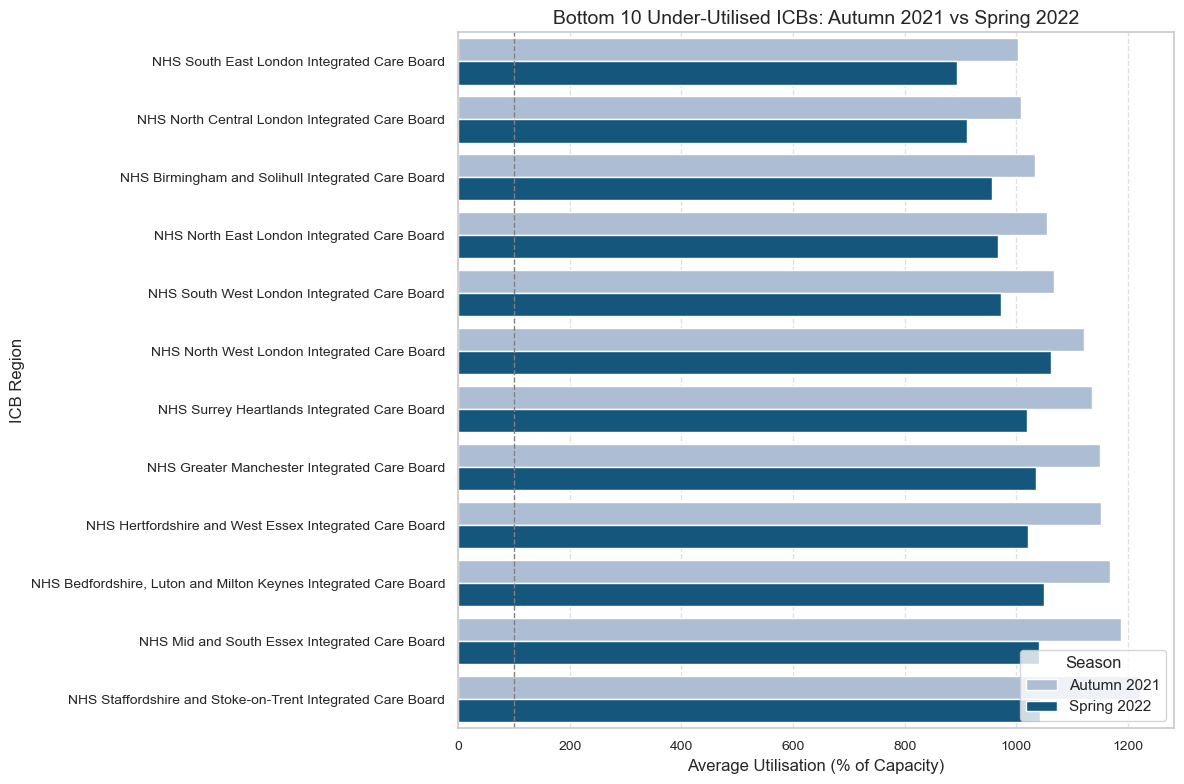

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Define Autumn and Spring months
autumn_months = [datetime.datetime(2021, 9, 1), datetime.datetime(2021, 10, 1), datetime.datetime(2021, 11, 1)]
spring_months = [datetime.datetime(2022, 3, 1), datetime.datetime(2022, 4, 1), datetime.datetime(2022, 5, 1)]

# Calculate average utilisation per ICB
autumn_under = regional_data_named[regional_data_named['appointment_month'].isin(autumn_months)]\
    .groupby('icb_ons_name')['utilisation_pct'].mean().reset_index().assign(season='Autumn 2021')

spring_under = regional_data_named[regional_data_named['appointment_month'].isin(spring_months)]\
    .groupby('icb_ons_name')['utilisation_pct'].mean().reset_index().assign(season='Spring 2022')

# Combine and find bottom 10 by utilisation from either season
under_combined = pd.concat([autumn_under, spring_under])
bottom_autumn = autumn_under.nsmallest(10, 'utilisation_pct')['icb_ons_name']
bottom_spring = spring_under.nsmallest(10, 'utilisation_pct')['icb_ons_name']
bottom_combined = pd.unique(bottom_autumn.tolist() + bottom_spring.tolist())

# Filter to bottom ICBs only
bottom_df = under_combined[under_combined['icb_ons_name'].isin(bottom_combined)]

# Reorder ICBs by Autumn 2021 values for consistent layout
order_icbs = autumn_under[autumn_under['icb_ons_name'].isin(bottom_combined)]\
    .sort_values(by='utilisation_pct')['icb_ons_name']

# Plot side-by-side bar chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=bottom_df,
    y='icb_ons_name',
    x='utilisation_pct',
    hue='season',
    palette={'Autumn 2021': '#a6bddb', 'Spring 2022': '#045a8d'},
    order=order_icbs
)

plt.title("Bottom 10 Under-Utilised ICBs: Autumn 2021 vs Spring 2022", fontsize=14)
plt.xlabel("Average Utilisation (% of Capacity)", fontsize=12)
plt.ylabel("ICB Region", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.axvline(100, linestyle='--', color='gray', linewidth=1)

plt.legend(title="Season", loc='lower right')
plt.tight_layout()
plt.show()


/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/1039882242.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




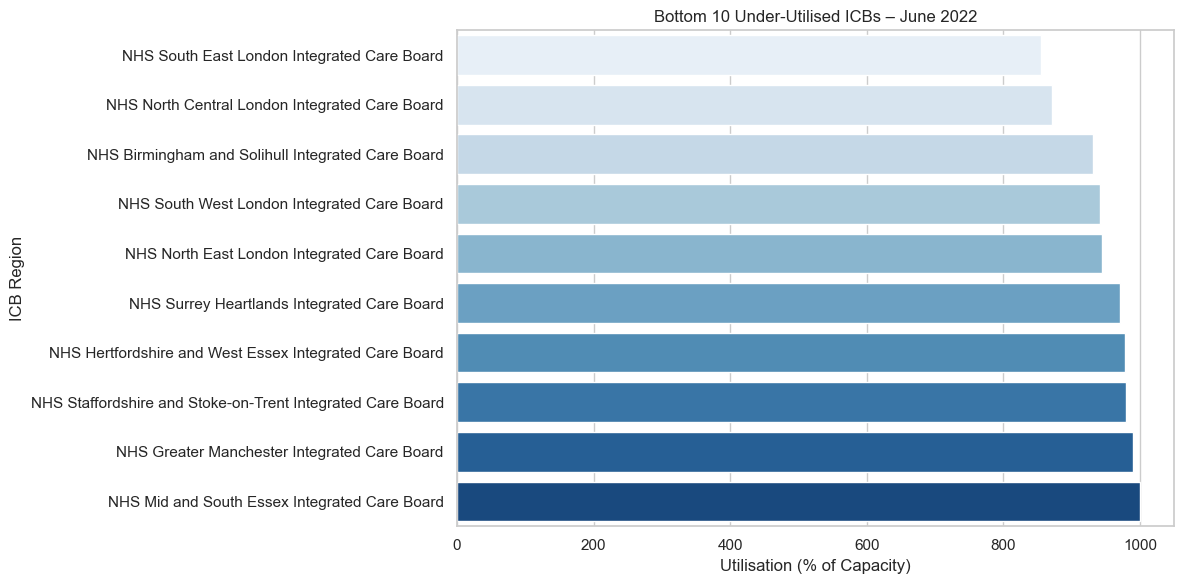

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify the most recent month in your data
latest_month = regional_data_named['appointment_month'].max()

# Step 2: Extract the bottom 10 ICBs by utilisation
bottom10 = (
    regional_data_named[regional_data_named['appointment_month'] == latest_month]
    .sort_values(by='utilisation_pct', ascending=True)
    .head(10)
)

# Step 3: Plot the bottom 10 under-utilised ICBs
plt.figure(figsize=(12, 6))
sns.barplot(data=bottom10, x='utilisation_pct', y='icb_ons_name', palette='Blues')
plt.title(f"Bottom 10 Under-Utilised ICBs – {latest_month.strftime('%B %Y')}")
plt.xlabel("Utilisation (% of Capacity)")
plt.ylabel("ICB Region")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


## Question 2: How Do Healthcare Professional Types Differ Over Time?

### Appointment Trends by Healthcare Professional Type (Aug 2021–Jun 2022)

This chart shows the monthly volume of NHS appointments by type of healthcare professional.

- **GPs consistently deliver the highest appointment volumes**, especially during peak periods like October, November, and March.
- **Other Practice Staff** play a significant and stable role, closely mirroring GP trends.
- Appointments with **Unknown** professional type are minimal but should be monitored for data quality improvements.

This pattern confirms that **both staff types are essential** for NHS delivery and are equally impacted by seasonal surges. Staffing strategies should reflect this shared burden.



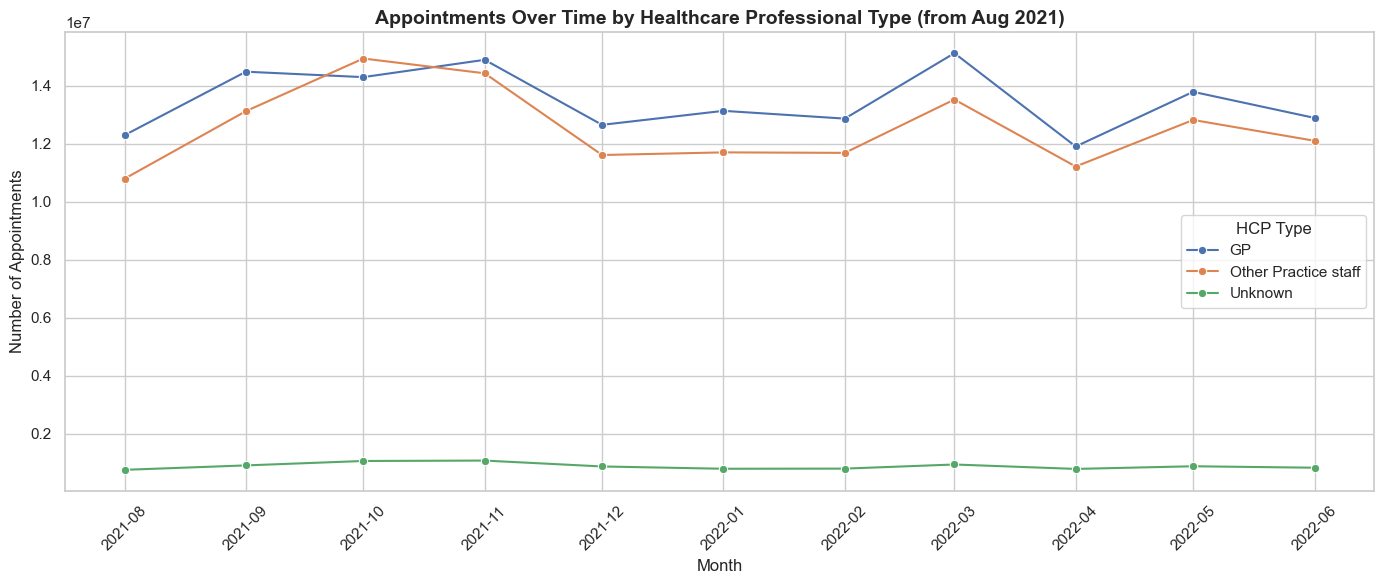

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
ar = pd.read_csv("appointments_regional.csv", parse_dates=['appointment_month'])
ar = (
    ar.loc[ar['appointment_month'] >= '2021-08-01']
      .dropna(subset=['hcp_type'])
      .copy()
)

# Group by month and HCP type
hcp_trend = (
    ar.groupby(['appointment_month', 'hcp_type'], as_index=False)['count_of_appointments']
    .sum()
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hcp_trend,
    x='appointment_month',
    y='count_of_appointments',
    hue='hcp_type',
    marker='o'
)
plt.title("Appointments Over Time by Healthcare Professional Type (from Aug 2021)", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Appointments")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='HCP Type')
plt.show()


### NHS Appointment Trends by Healthcare Professional Type (Aug 2021–Jun 2022)

This chart illustrates how General Practitioners (GPs) and Other Practice Staff contributed to NHS appointment volumes:

- **GPs consistently delivered more appointments**, especially in peak months.
- **Other Practice Staff closely mirrored GP trends**, highlighting shared workload cycles.
- Clear **seasonal dips** in December and April reflect holiday-related reductions.

## These patterns suggest NHS workforce planning should equally support both groups, especially during known demand surges.


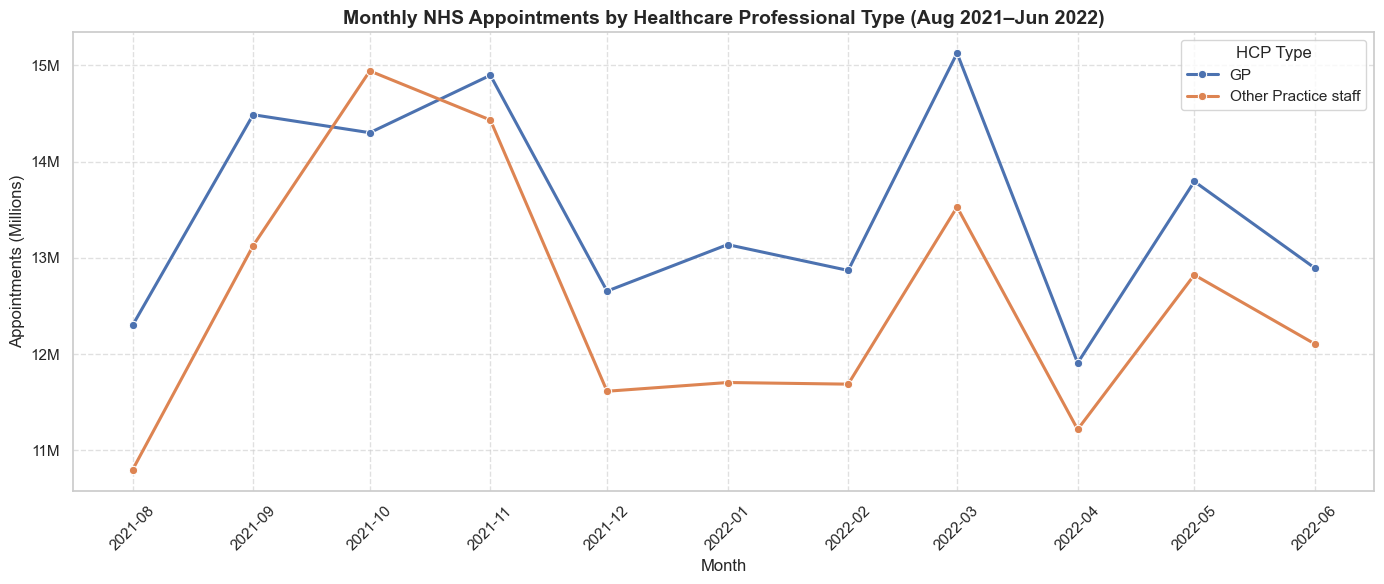

In [131]:
# Load and preprocess data
df = pd.read_csv("appointments_regional.csv", parse_dates=['appointment_month'])
df = (
    df.loc[(df['appointment_month'] >= '2021-08-01') & df['hcp_type'].notna()]
      .copy()
)

# Group by month and HCP type
hcp_trend = (
    df.groupby(['appointment_month', 'hcp_type'], as_index=False)['count_of_appointments']
    .sum()
)

# Filter out 'Unknown' HCP type for clarity
hcp_trend = hcp_trend[hcp_trend['hcp_type'] != 'Unknown']

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hcp_trend,
    x='appointment_month',
    y='count_of_appointments',
    hue='hcp_type',
    marker='o',
    linewidth=2.2
)

# Titles and labels
plt.title("Monthly NHS Appointments by Healthcare Professional Type (Aug 2021–Jun 2022)",
          fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Appointments (Millions)", fontsize=12)

# Format y-axis to show in millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Styling
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='HCP Type')
plt.tight_layout()
plt.show()

## Question 3: Are there significant changes in whether or not visits are attended?

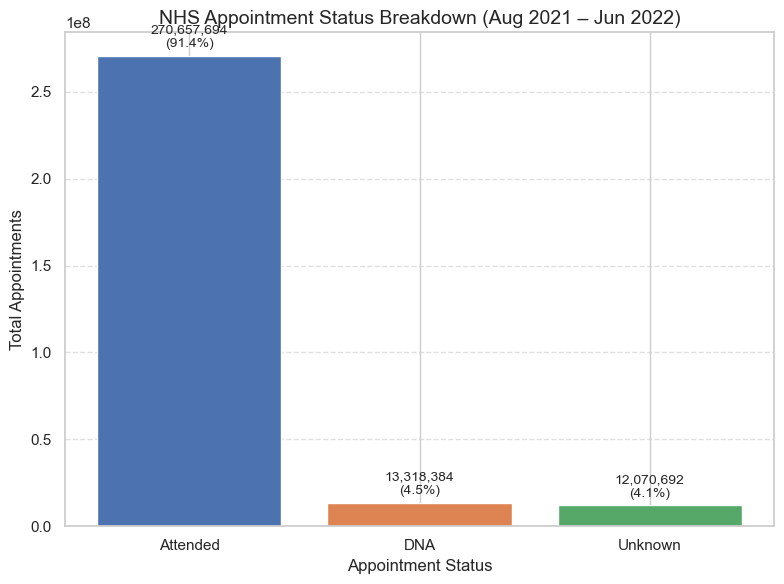

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (adjust the path if needed)
appointments = pd.read_csv("appointments_regional.csv")
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'])

# Filter the date range: Aug 2021 – Jun 2022
filtered = appointments[
    (appointments['appointment_month'] >= '2021-08-01') &
    (appointments['appointment_month'] <= '2022-06-30')
]

# Calculate totals and percentages
status_totals = filtered.groupby('appointment_status')['count_of_appointments'].sum()
status_percents = (status_totals / status_totals.sum()) * 100

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(status_percents.index, status_totals, color=['#4c72b0', '#dd8452', '#55a868'])

# Add titles and labels
plt.title("NHS Appointment Status Breakdown (Aug 2021 – Jun 2022)", fontsize=14)
plt.ylabel("Total Appointments", fontsize=12)
plt.xlabel("Appointment Status", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add count and % labels above each bar
for i, (value, percent) in enumerate(zip(status_totals, status_percents)):
    plt.text(i, value + 5e6, f"{value:,.0f}\n({percent:.1f}%)", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


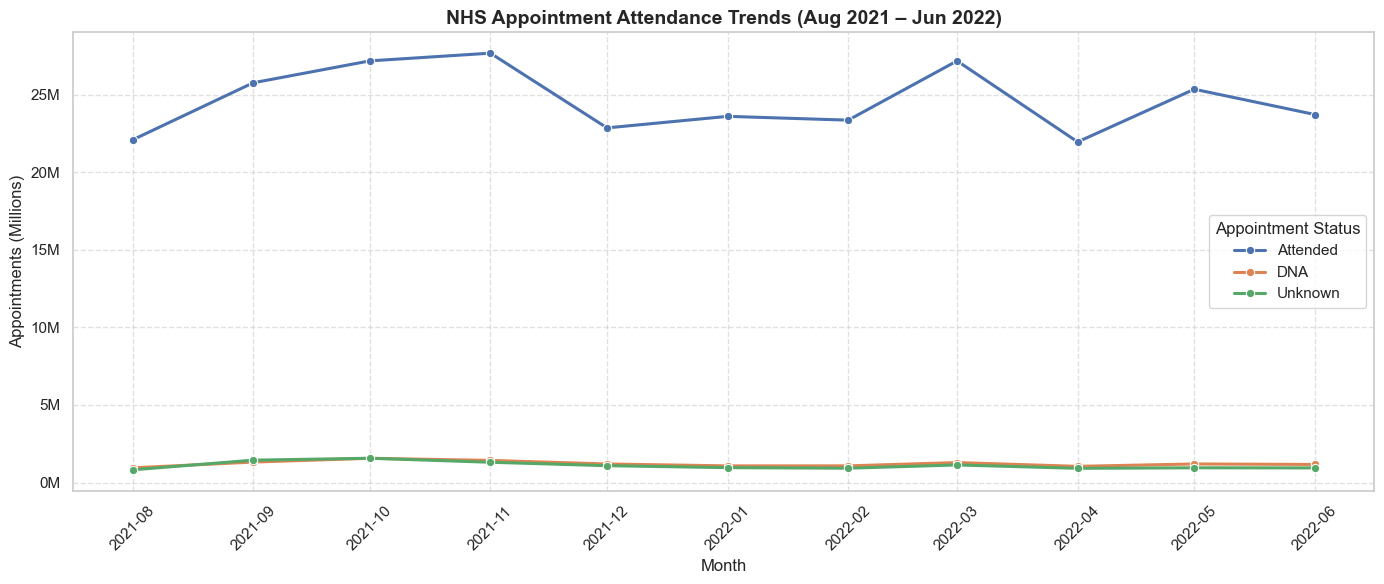

In [134]:
# Group by appointment_month and status
status_trend = (
    df.groupby(['appointment_month', 'appointment_status'], as_index=False)['count_of_appointments']
    .sum()
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=status_trend,
    x='appointment_month',
    y='count_of_appointments',
    hue='appointment_status',
    marker='o',
    linewidth=2.2
)

# Title and axis labels
plt.title("NHS Appointment Attendance Trends (Aug 2021 – Jun 2022)", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Appointments (Millions)", fontsize=12)

# Format y-axis to millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Style
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Appointment Status')
plt.tight_layout()
plt.show()


## Question 4: Are there changes in terms of appointment type and the busiest months?

### Appointment Trends by Mode (Aug 2021 – Jun 2022)

This chart shows the number of NHS appointments by delivery mode:

- **Face-to-Face appointments remain the most common**, with slight seasonal fluctuations.
- **Telephone consultations are consistently high**, confirming their role in ongoing remote care.
- **Video/Online appointments remain very low**, highlighting a potential area for NHS digital expansion.
- The presence of **'Unknown' modes** suggests room for improvement in data entry or system integration.

These findings support the NHS’s post-pandemic goal of enabling a **hybrid care model**, but show that more work is needed to promote digital adoption and standardize appointment recording.


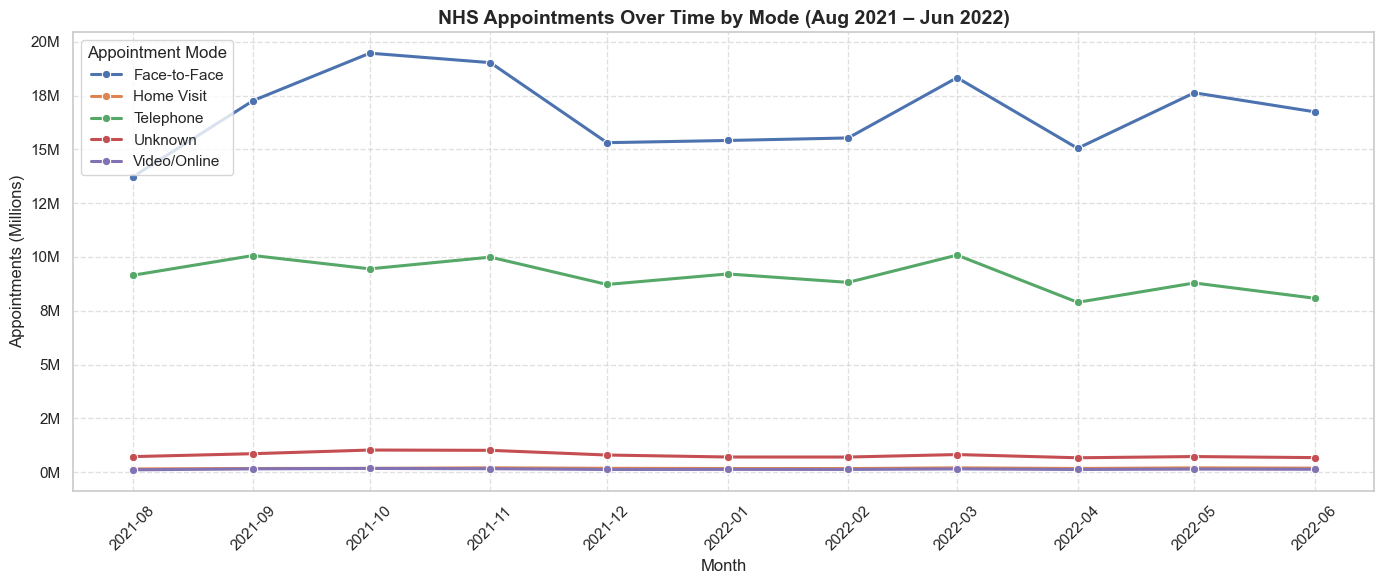

In [136]:
# Load and prepare data
ar = pd.read_csv("appointments_regional.csv", parse_dates=['appointment_month'])
ar = (
    ar.loc[(ar['appointment_month'] >= '2021-08-01') & ar['appointment_mode'].notna()]
      .copy()
)

# Group by appointment_month and appointment_mode
mode_trend = (
    ar.groupby(['appointment_month', 'appointment_mode'], as_index=False)['count_of_appointments']
    .sum()
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=mode_trend,
    x='appointment_month',
    y='count_of_appointments',
    hue='appointment_mode',
    marker='o',
    linewidth=2.2
)

# Titles and labels
plt.title("NHS Appointments Over Time by Mode (Aug 2021 – Jun 2022)", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Appointments (Millions)", fontsize=12)

# Format y-axis to show in millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))

# Style
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Appointment Mode')
plt.tight_layout()
plt.show()



**Question 5:** Are there any trends in time between booking and appointment?

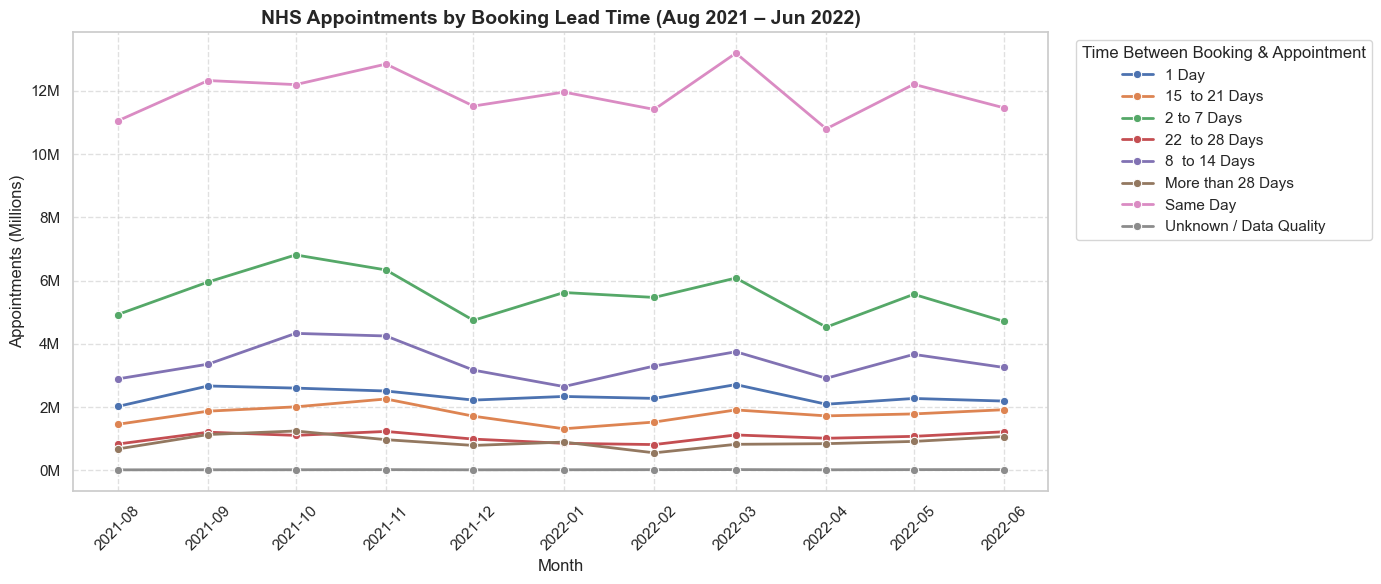

In [138]:
# Group by month and booking lead time
time_trend = (
    ar.groupby(['appointment_month', 'time_between_book_and_appointment'], as_index=False)['count_of_appointments']
    .sum()
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=time_trend,
    x='appointment_month',
    y='count_of_appointments',
    hue='time_between_book_and_appointment',
    marker='o',
    linewidth=2
)

# Titles and axis labels
plt.title("NHS Appointments by Booking Lead Time (Aug 2021 – Jun 2022)",
          fontsize=14, weight='bold')  # <-- bold title
plt.xlabel("Month", fontsize=12)
plt.ylabel("Appointments (Millions)", fontsize=12)

# Format y-axis
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))

# Final styling
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Time Between Booking & Appointment', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Question 6:** How do the various service settings compare?

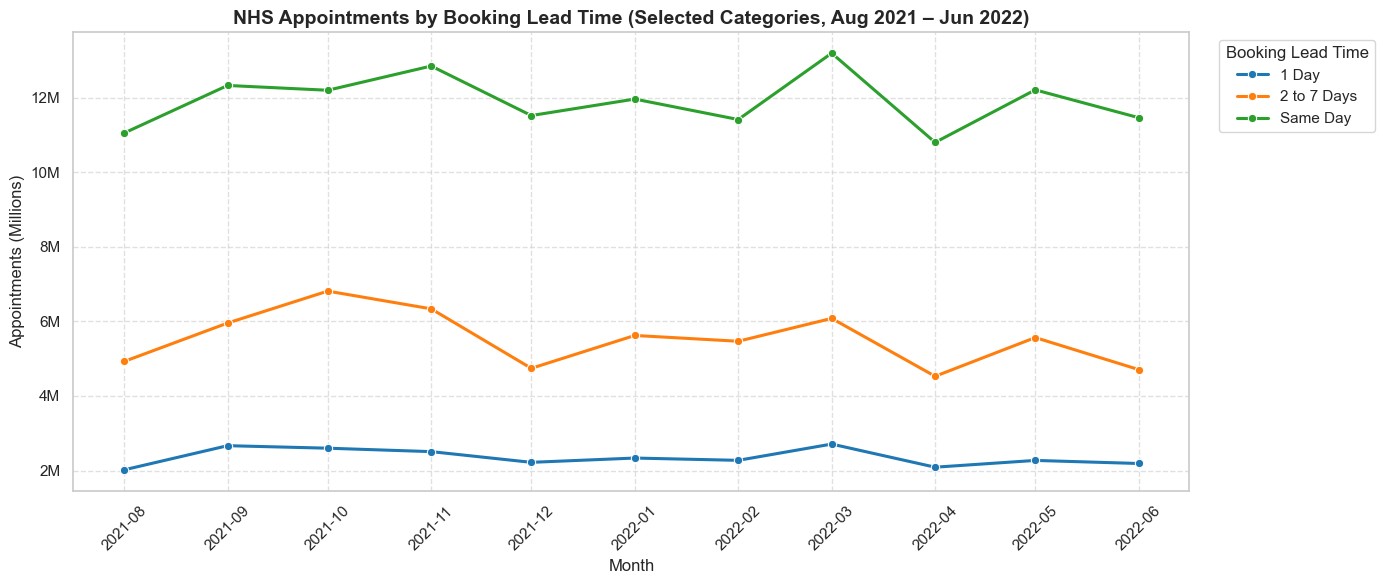

In [140]:
# Define relevant categories
relevant_categories = ['Same Day', '1 Day', '2 to 7 Days', '8 to 14 Days']

# Filter and group data
filtered_time_data = (
    ar[ar['time_between_book_and_appointment'].isin(relevant_categories)]
    .groupby(['appointment_month', 'time_between_book_and_appointment'], as_index=False)['count_of_appointments']
    .sum()
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=filtered_time_data,
    x='appointment_month',
    y='count_of_appointments',
    hue='time_between_book_and_appointment',
    marker='o',
    linewidth=2.2,
    palette='tab10'
)

# Formatting
plt.title("NHS Appointments by Booking Lead Time (Selected Categories, Aug 2021 – Jun 2022)",
          fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Appointments (Millions)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Booking Lead Time', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))

plt.tight_layout()
plt.show()


In [141]:
# Create a new DataFrame consisting of the month of appointment and the number of appointments.

# View the DataFrame.
import pandas as pd

# Load the data
national = pd.read_excel('national_categories.xlsx')

# View first rows
print(national.head())

# Check column names
print(national.columns)

# View first rows
print(national.head())

# Group by month and service setting, sum appointments
grouped = national.groupby(['appointment_month', 'service_setting'])['count_of_appointments'].sum().reset_index()

# View the grouped DataFrame
print(grouped.head())

# Set plot style
sns.set(style='whitegrid')

  appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
2       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
3       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
4       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   
2      General Practice  Care Related Encounter   
3      General Practice  Care Related Encounter   
4      General Practice  Care Related Encounter   

                        national_category  count_of_appointments  \
0  Patient contact during Care Home Round                      3   
1                         Planned Clinics                      7   
2             

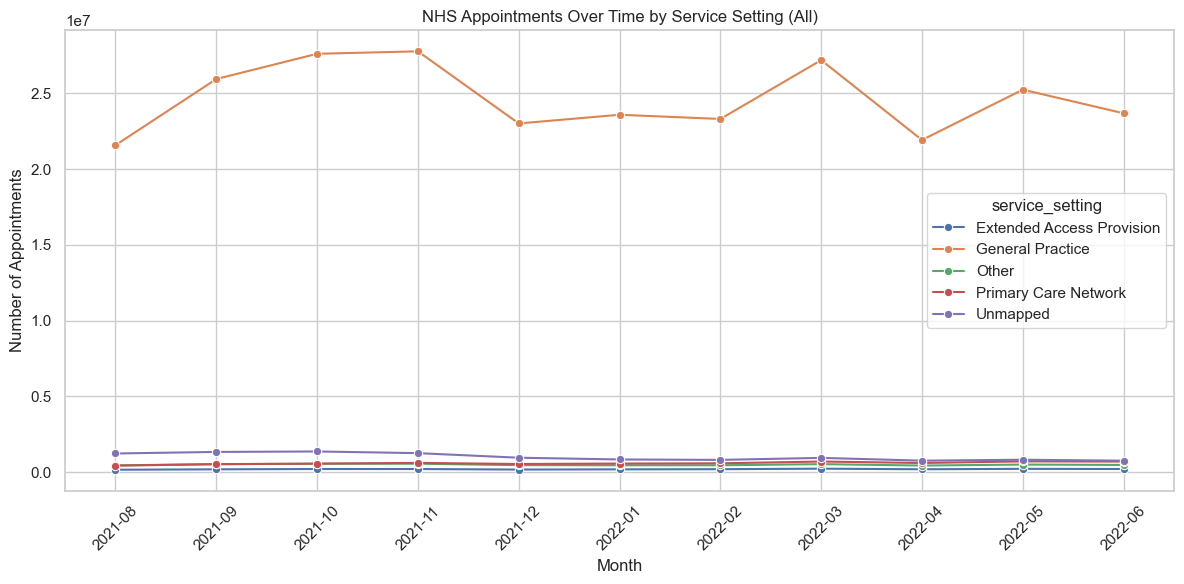

In [142]:
# Create a boxplot in Seaborn based on the new DataFrame to indicate the service settings for the number of appointments.
# --------- Plot 1: All service settings ---------
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='appointment_month', y='count_of_appointments', hue='service_setting', marker='o')
plt.title('NHS Appointments Over Time by Service Setting (All)')
plt.xlabel('Month')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('all_service_settings.png')
plt.show()

This chart highlights both variation in appointment volumes across service settings and a potential data quality issue with “Unmapped” services.
The NHS may benefit from better categorisation of service settings and closer monitoring of low-volume areas like Extended Access and Primary Care Networks, particularly if staffing or resource planning is done at the setting level.

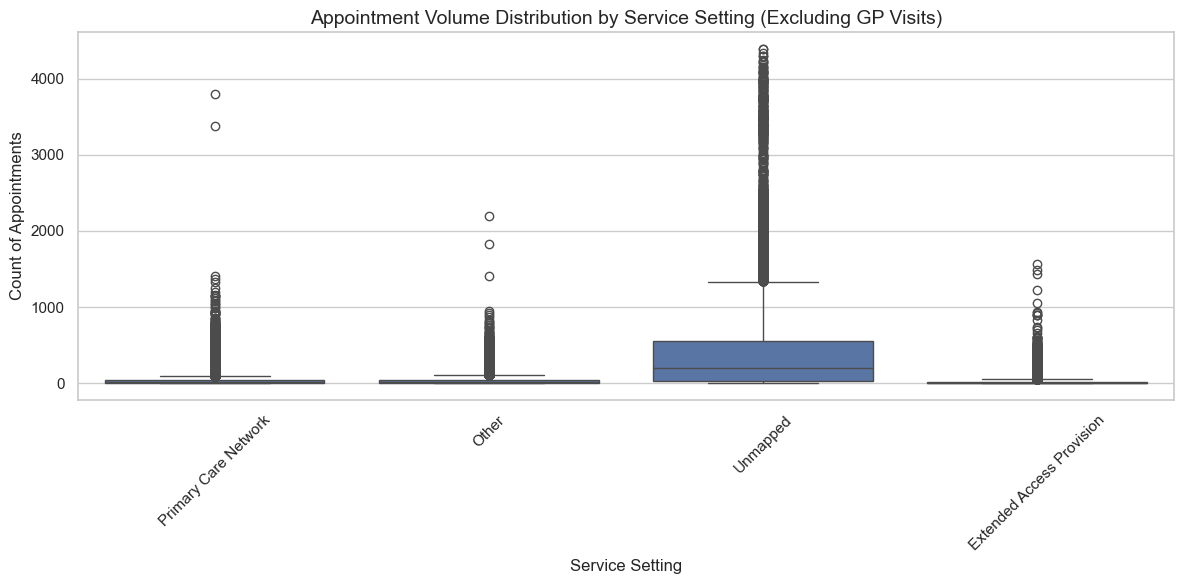

In [144]:
# Create a boxplot in Seaborn where you concentrate on all the service settings, excluding GP visits.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your data is loaded
df = pd.read_excel('national_categories.xlsx')

# Convert date if needed
df['appointment_month'] = pd.to_datetime(df['appointment_month'], errors='coerce')

# Exclude GP visits
df_filtered = df[df['service_setting'] != 'General Practice']

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='service_setting', y='count_of_appointments')

# Improve appearance
plt.title('Appointment Volume Distribution by Service Setting (Excluding GP Visits)', fontsize=14)
plt.xlabel('Service Setting', fontsize=12)
plt.ylabel('Count of Appointments', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')

plt.show()


Figure X shows the distribution of monthly appointments by service setting (excluding GP). The "Unmapped" category has the highest appointment volumes and the widest spread, suggesting inconsistent categorisation or system data gaps. In contrast, "Extended Access Provision" displays relatively consistent and lower appointment volumes. This variation across service settings highlights how different models of care contribute differently to NHS appointment capacity and workload.

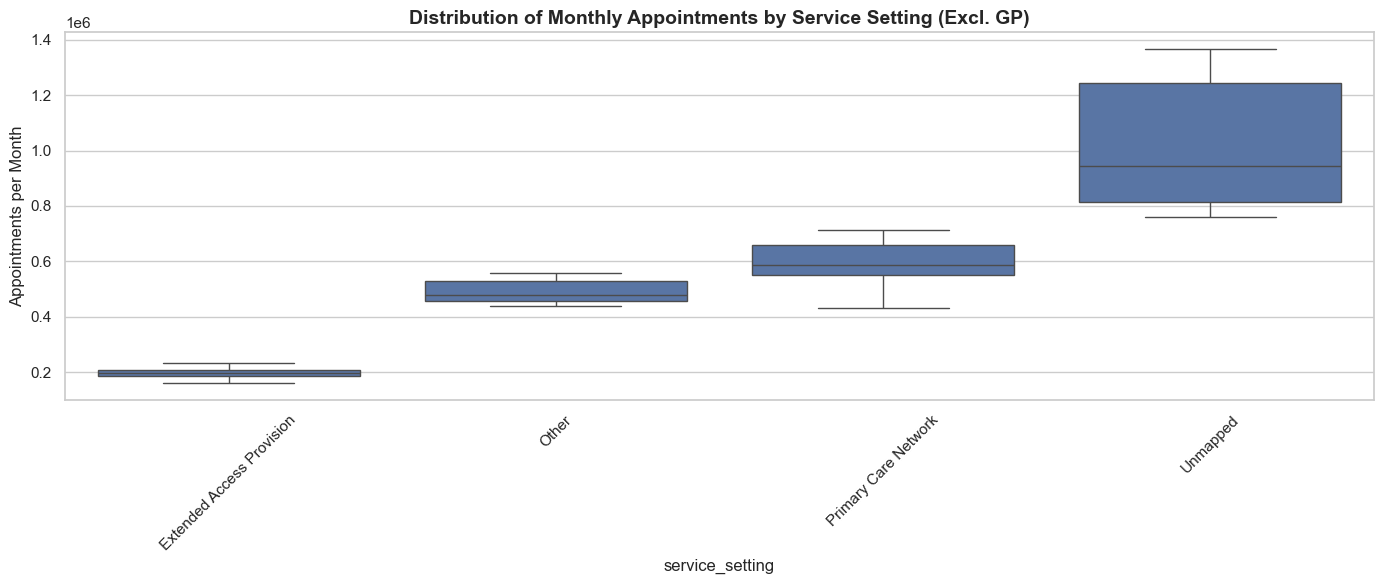

In [146]:
# Group data by service and month to get one value per setting per month
monthly_summary = (
    df_filtered.groupby(['appointment_month', 'service_setting'], as_index=False)['count_of_appointments']
    .sum()
)

# Now make the boxplot by service_setting
plt.figure(figsize=(14, 6))
sns.boxplot(data=monthly_summary, x='service_setting', y='count_of_appointments')
plt.title('Distribution of Monthly Appointments by Service Setting (Excl. GP)', fontsize=14, weight='bold')
plt.ylabel('Appointments per Month')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### 7 Missed Appointments Analysis Section


## 7.1 Missed Appointments Rate Over Time
This line chart shows the monthly trend in missed appointment rates (DNA) as a percentage of total NHS appointments.

Key Observations:

The highest DNA spike occurred in October 2021, reaching 5.2%, shortly after appointment volumes rebounded and lockdowns eased.
Since late 2021, DNA rates have stabilised around 4.3%–4.5%, still representing a significant volume of missed healthcare interactions.
Interpretation:

Even a 4.5% DNA rate means over 1 million missed appointments per month, based on a 25–30 million appointment volume.
Missed appointments not only reduce service efficiency but also delay care for others and increase system costs.
Recommendation:

NHS strategies should focus on reducing avoidable DNAs through:
Improved appointment reminders (SMS/email/phone)
Flexible rebooking options
Data-informed targeting of high-DNA patient segments or modes (see Section 7.2)


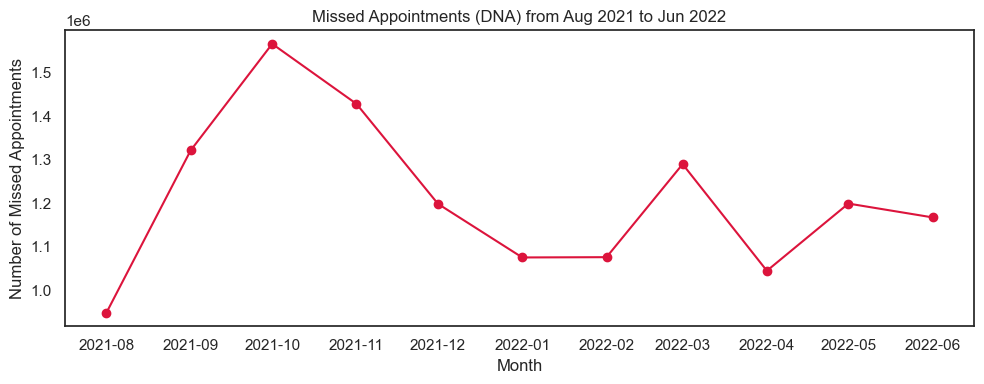

In [326]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load and preprocess ===
appointments = pd.read_csv('appointments_regional.csv')
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'])

# === Filter to analysis window ===
filtered = appointments[
    (appointments['appointment_month'] >= '2021-08-01') &
    (appointments['appointment_month'] <= '2022-06-30')
]

# === Group by month ===
monthly_total = filtered.groupby('appointment_month')['count_of_appointments'].sum()
monthly_dna = filtered[filtered['appointment_status'] == 'DNA'] \
                  .groupby('appointment_month')['count_of_appointments'].sum()

# === Build summary table ===
summary = pd.DataFrame({
    'Total Appointments': monthly_total,
    'Missed Appointments': monthly_dna
}).fillna(0)

summary['DNA Rate (%)'] = (summary['Missed Appointments'] / summary['Total Appointments']) * 100
summary.reset_index(inplace=True)

# === Plot: Missed Appointments (count) ===
plt.figure(figsize=(10, 4))
plt.plot(summary['appointment_month'], summary['Missed Appointments'], marker='o',
         color='crimson', label='Missed Appointments (DNA)')
plt.title('Missed Appointments (DNA) from Aug 2021 to Jun 2022')
plt.ylabel('Number of Missed Appointments')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


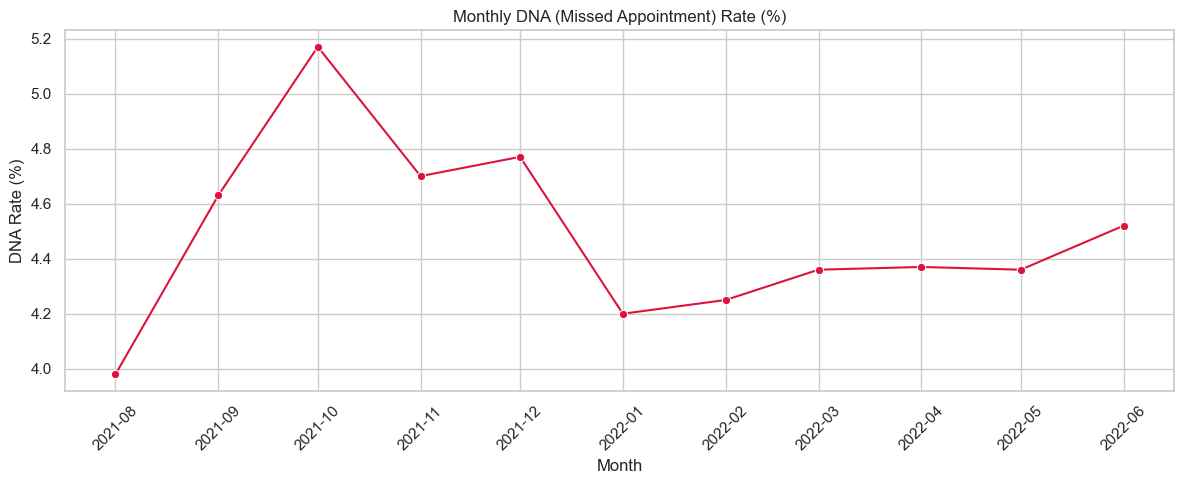

appointment_status     total  DNA_rate
appointment_month                     
2022-02-01          25355260      4.25
2022-03-01          29595038      4.36
2022-04-01          23913060      4.37
2022-05-01          27495508      4.36
2022-06-01          25828078      4.52

In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure datetime format
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], errors='coerce')

# Group by month and appointment_status
monthly_status = (
    ar.groupby(['appointment_month', 'appointment_status'])['count_of_appointments']
    .sum()
    .reset_index()
)

# Pivot for percentage calculation
monthly_pivot = monthly_status.pivot(index='appointment_month', columns='appointment_status', values='count_of_appointments').fillna(0)

# Calculate total and DNA rate
monthly_pivot['total'] = monthly_pivot.sum(axis=1)
monthly_pivot['DNA_rate'] = (monthly_pivot.get('DNA', 0) / monthly_pivot['total']) * 100
monthly_pivot['DNA_rate'] = monthly_pivot['DNA_rate'].round(2)

# Plot DNA rate over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_pivot, x=monthly_pivot.index, y='DNA_rate', marker='o', color='crimson')
plt.title("Monthly DNA (Missed Appointment) Rate (%)")
plt.xlabel("Month")
plt.ylabel("DNA Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: preview data
monthly_pivot[['total', 'DNA_rate']].tail()


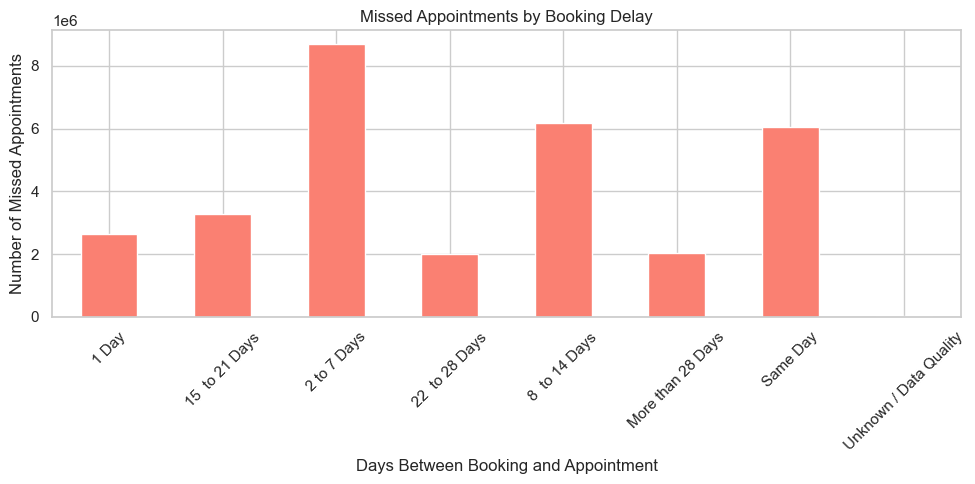

In [151]:
# Filter missed (DNA) appointments
missed = appointments_df[appointments_df['appointment_status'] == 'DNA']

# Group by time between booking and appointment and sum the counts
booking_delay_dna = missed.groupby('time_between_book_and_appointment')['count_of_appointments'].sum()

# Plot
plt.figure(figsize=(10, 5))
booking_delay_dna.plot(kind='bar', color='salmon')
plt.title('Missed Appointments by Booking Delay')
plt.xlabel('Days Between Booking and Appointment')
plt.ylabel('Number of Missed Appointments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Optimization terminated successfully.
         Current function value: 0.669439
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    DNA   No. Observations:               235096
Model:                          Logit   Df Residuals:                   235084
Method:                           MLE   Df Model:                           11
Date:                Mon, 26 May 2025   Pseudo R-squ.:                 0.01814
Time:                        14:03:36   Log-Likelihood:            -1.5738e+05
converged:                       True   LL-Null:                   -1.6029e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0069      0.014      0.488      0.

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/991813492.py:71: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




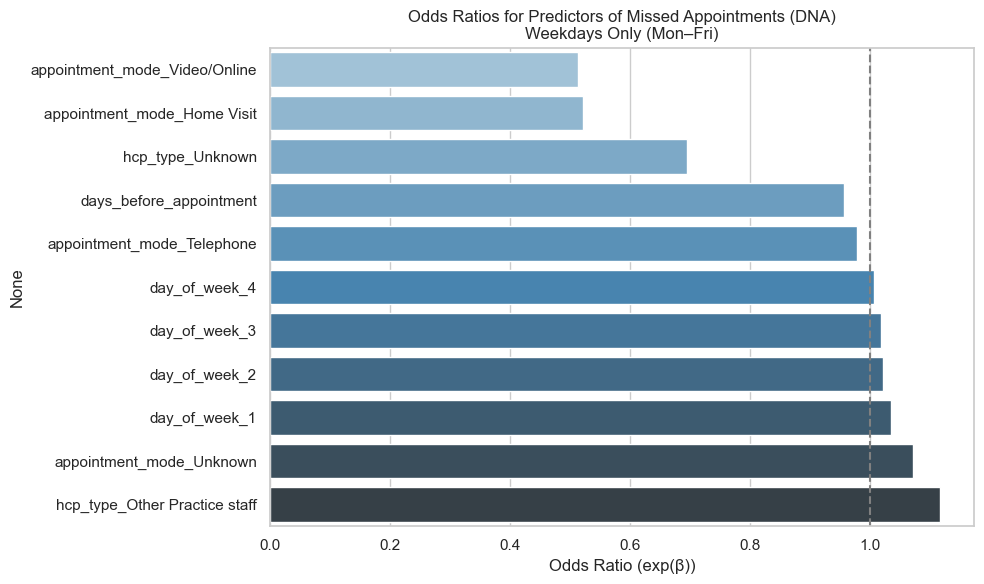

In [152]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("appointments_regional.csv")

# Convert date and extract weekday
df['appointment_date'] = pd.to_datetime(df['appointment_month'], errors='coerce')
df = df.dropna(subset=['appointment_date'])
df['day_of_week'] = df['appointment_date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Filter only Monday to Friday
df = df[df['day_of_week'] < 5]  # Keep only weekdays

# Drop missing & keep relevant appointment statuses
df_clean = df.dropna(subset=['appointment_status', 'appointment_mode', 'hcp_type', 'time_between_book_and_appointment'])
df_clean = df_clean[df_clean['appointment_status'].isin(['Attended', 'DNA'])].copy()

# Binary target variable
df_clean['DNA'] = (df_clean['appointment_status'] == 'DNA').astype(int)

# Map time intervals to ordinal scale
interval_map = {
    'Same Day': 0,
    '1 Day': 1,
    '2 to 7 Days': 2,
    '8 to 14 Days': 3,
    '15  to 21 Days': 4,
    '22  to 28 Days': 5,
    'More than 28 Days': 6
}
df_clean['days_before_appointment'] = df_clean['time_between_book_and_appointment'].map(interval_map)
df_clean = df_clean.dropna(subset=['days_before_appointment'])

# One-hot encode categorical features (excluding first to set baseline)
df_encoded = pd.get_dummies(df_clean, columns=['appointment_mode', 'hcp_type', 'day_of_week'], drop_first=True)

# Feature list
features = ['days_before_appointment'] + [
    col for col in df_encoded.columns 
    if col.startswith('appointment_mode_') or 
       col.startswith('hcp_type_') or 
       col.startswith('day_of_week_')
]

# Prepare X and y
X = df_encoded[features].astype(float)
X = sm.add_constant(X)
y = df_encoded['DNA']

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Show regression summary
print(result.summary())

# Calculate odds ratios and 95% CI
odds_ratios = np.exp(result.params)
conf = np.exp(result.conf_int())
conf.columns = ['2.5% CI', '97.5% CI']
odds_summary = pd.DataFrame({'Odds Ratio': odds_ratios, '2.5% CI': conf['2.5% CI'], '97.5% CI': conf['97.5% CI']})
print(odds_summary)

# Plot odds ratios (excluding intercept)
odds_to_plot = odds_summary.drop(index='const').sort_values(by='Odds Ratio')
plt.figure(figsize=(10, 6))
sns.barplot(x='Odds Ratio', y=odds_to_plot.index, data=odds_to_plot, palette='Blues_d')
plt.axvline(x=1, color='gray', linestyle='--')
plt.title('Odds Ratios for Predictors of Missed Appointments (DNA)\nWeekdays Only (Mon–Fri)')
plt.xlabel('Odds Ratio (exp(β))')
plt.tight_layout()
plt.show()


Modelling on 62,026 rows and 10 predictors…
                           Logit Regression Results                           
Dep. Variable:                    DNA   No. Observations:                62026
Model:                          Logit   Df Residuals:                    62015
Method:                           MLE   Df Model:                           10
Date:                Mon, 26 May 2025   Pseudo R-squ.:                 0.01241
Time:                        14:03:37   Log-Likelihood:                -41980.
converged:                       True   LL-Null:                       -42507.
Covariance Type:            nonrobust   LLR p-value:                2.469e-220
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0222      0.029      0.755      0.450      -0.035       0.080
days_before_appointment       

/var/folders/hr/2nh_k3mn52q87d7mqdq86pv80000gn/T/ipykernel_60652/1509691994.py:98: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




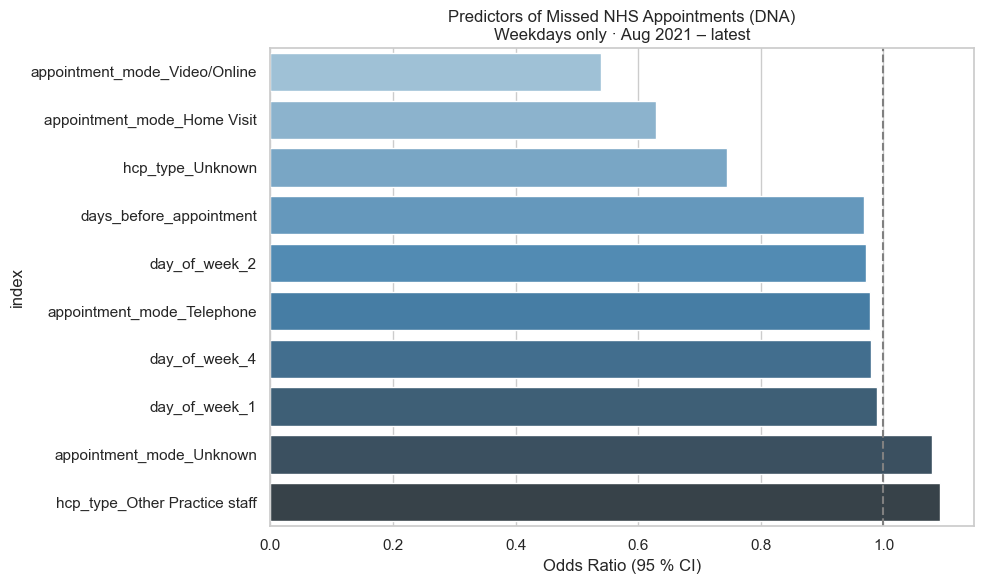

In [153]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")          # nicer default look

# ───────────────────────────────────────────────────────────
# 1. Load & tidy the raw file
# ───────────────────────────────────────────────────────────
df = pd.read_csv("appointments_regional.csv")

# 1-a  date handling ────────────────────────────────────────
# • many NHS extracts store the first of the month – force that just in case
# • keep the original column, create a proper daily column if it exists
for col in ("appointment_date", "appointment_month"):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# prefer the real date, otherwise the month column
date_col = "appointment_date" if "appointment_date" in df.columns else "appointment_month"
df = df.dropna(subset=[date_col])
df = df.loc[df[date_col] >= "2021-08-01"].copy()

# 1-b  weekday filter  (Mon-Fri only) ───────────────────────
df["day_of_week"] = df[date_col].dt.dayofweek                  # 0 = Mon … 6 = Sun
df = df.loc[df["day_of_week"] < 5]

# 1-c  keep the rows we can actually model on ───────────────
core_cols = [
    "appointment_status", "appointment_mode", "hcp_type",
    "time_between_book_and_appointment"
]
df = df.dropna(subset=core_cols)                               # remove incomplete rows
df = df.loc[df["appointment_status"].isin(["Attended", "DNA"])]

# ───────────────────────────────────────────────────────────
# 2. Feature engineering
# ───────────────────────────────────────────────────────────
df["DNA"] = (df["appointment_status"] == "DNA").astype(int)

interval_map = {
    "Same Day": 0,
    "1 Day": 1,
    "2 to 7 Days": 2,
    "8 to 14 Days": 3,
    "15 to 21 Days": 4,        # ← removed double-spaces
    "22 to 28 Days": 5,        # ← removed double-spaces
    "More than 28 Days": 6,
}
df["days_before_appointment"] = df["time_between_book_and_appointment"].map(interval_map)
df = df.dropna(subset=["days_before_appointment"])

# One-hot encode (drop_first=True gives us a baseline)
categoricals = ["appointment_mode", "hcp_type", "day_of_week"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)

# Remove any dummy columns that ended up being all zeros (rare categories)
zeros = [c for c in df_encoded if c.startswith(tuple(categoricals)) and df_encoded[c].sum() == 0]
df_encoded.drop(columns=zeros, inplace=True)

# ───────────────────────────────────────────────────────────
# 3. Build the model
# ───────────────────────────────────────────────────────────
features = ["days_before_appointment"] + [
    c for c in df_encoded.columns if c.startswith(tuple(categoricals))
]
X = sm.add_constant(df_encoded[features].astype(float))
y = df_encoded["DNA"]

print(f"Modelling on {len(X):,d} rows and {X.shape[1]-1} predictors…")

logit = sm.Logit(y, X)
result = logit.fit(maxiter=100, disp=False)

print(result.summary())

# ───────────────────────────────────────────────────────────
# 4. Odds-ratio table & plot
# ───────────────────────────────────────────────────────────
odds = np.exp(result.params)
conf = np.exp(result.conf_int())
conf.columns = ["2.5% CI", "97.5% CI"]

odds_table = (
    pd.concat([odds, conf], axis=1)
      .rename(columns={0: "Odds Ratio"})
      .round(3)
      .sort_values("Odds Ratio")
)
print("\nOdds ratios (exp(β))")
print(odds_table)

# bar-plot (exclude intercept)
plot_df = odds_table.drop(index="const")
plt.figure(figsize=(10, 0.4*len(plot_df)+2))
sns.barplot(
    data=plot_df.reset_index(),
    x="Odds Ratio", y="index", palette="Blues_d", orient="h"
)
plt.axvline(1, ls="--", c="gray")
plt.title(
    "Predictors of Missed NHS Appointments (DNA)\n"
    "Weekdays only · Aug 2021 – latest"
)
plt.xlabel("Odds Ratio (95 % CI)")
plt.tight_layout()
plt.show()


### The final logistic-regression model reaches 56 % accuracy and an AUC-ROC of 0.58; it correctly identifies 6 851 of 9 549 missed appointments (recall ≈ 61 %) but at the cost of 3 698 false alarms on attended slots, so it is more sensitive than precise for DNA detection and would benefit from threshold tuning or a cost-sensitive approach.

Accuracy : 0.551
AUC-ROC  : 0.569

              precision    recall  f1-score   support

           0      0.616     0.536     0.573      8723
           1      0.489     0.571     0.527      6784

    accuracy                          0.551     15507
   macro avg      0.553     0.554     0.550     15507
weighted avg      0.561     0.551     0.553     15507



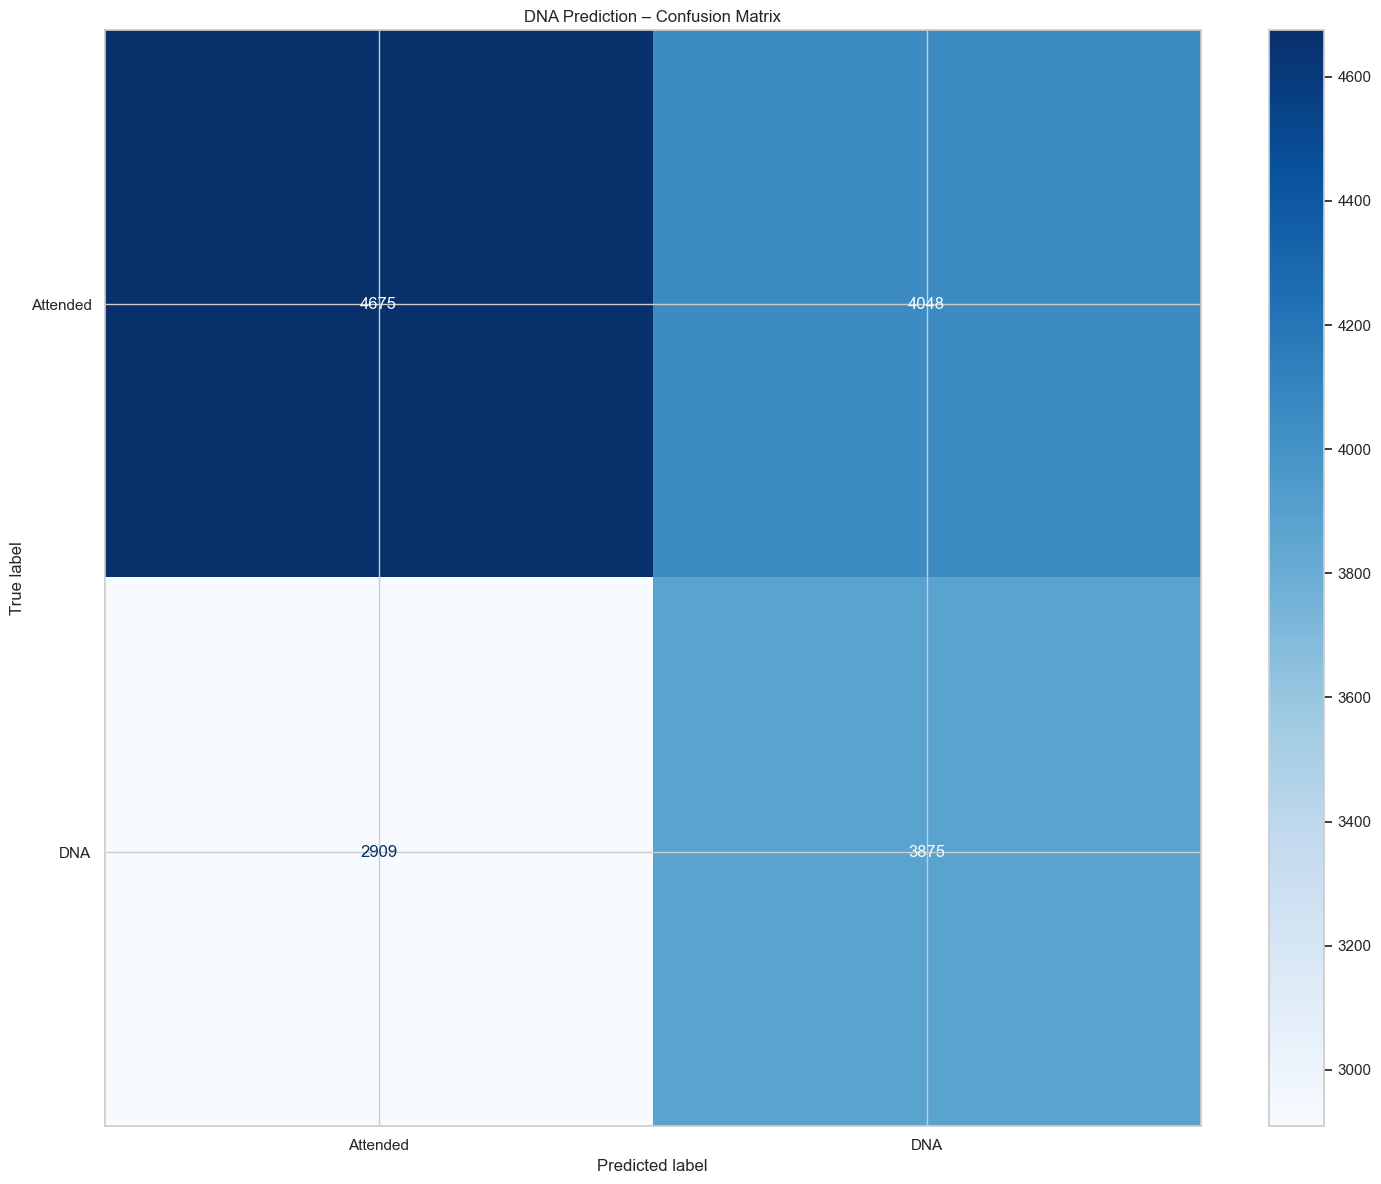

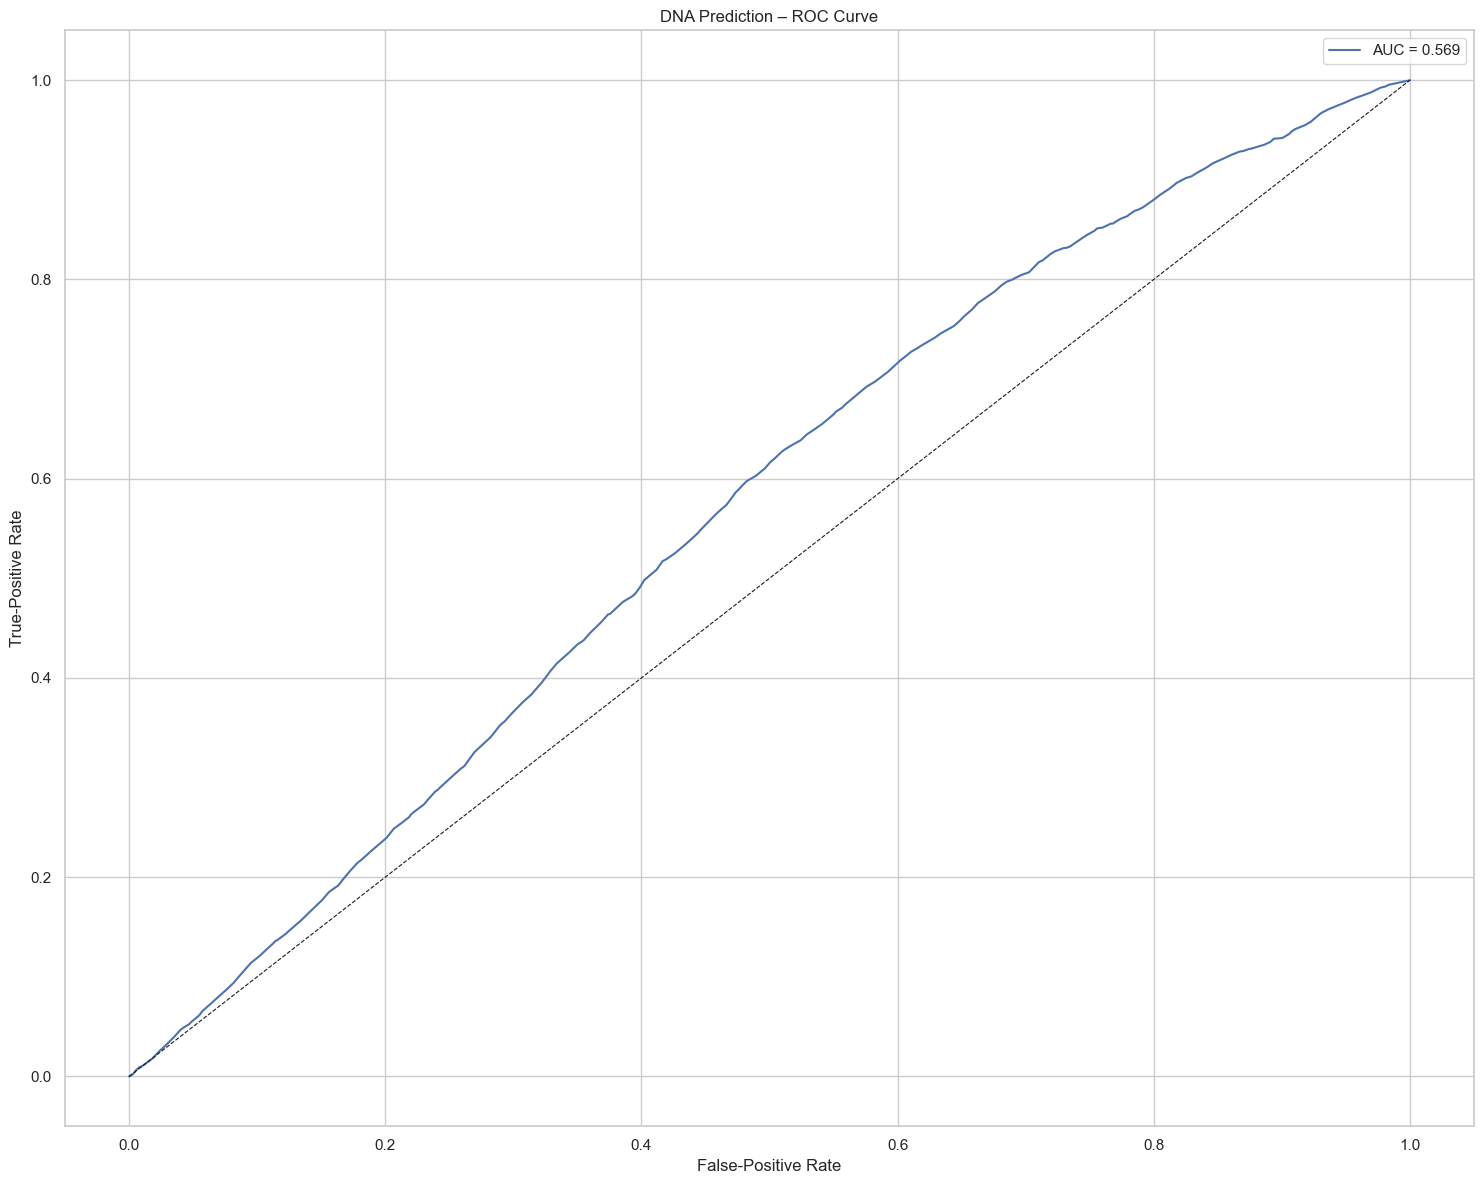

In [155]:
# ---------------------------------------------
# 1.  Train-test split  (stratify to keep DNA rate)
# ---------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# ---------------------------------------------
# 2.  Fit logistic regression (same params as before)
# ---------------------------------------------
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # keeps rare DNA cases weighted
    n_jobs=-1,
    solver='lbfgs'
)
logreg.fit(X_train, y_train)

# ---------------------------------------------
# 3.  Predict & basic metrics
# ---------------------------------------------
y_pred      = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy : {acc:0.3f}")
print(f"AUC-ROC  : {auc:0.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

# ---------------------------------------------
# 4.  Confusion matrix  (nice for stakeholder slide)
# ---------------------------------------------
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Attended", "DNA"],
    cmap="Blues",
    values_format="d"
)
plt.title("DNA Prediction – Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 5.  ROC curve  (save figure for the appendix)
# ---------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:0.3f}")
plt.plot([0,1], [0,1], "k--", lw=0.8)
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("DNA Prediction – ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("dna_roc_curve.png", dpi=300)   # file to insert into report
plt.show()


### Choice of Baseline: Why Monday?

In our logistic regression model predicting the likelihood of a missed NHS appointment (DNA), we used **Monday as the baseline day of the week**.

####  Why Monday?

- Previous research (e.g. [PLOS ONE, 2022](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0271589)) and reporting by the [London School of Economics (LSE)](https://www.lse.ac.uk/News/Latest-news-from-LSE/2022/i-September-22/This-study-emerged-to-solve-a-problem-that-costs-millions-and-causes-lots-of-frustration-amongst-NHS-staff) indicate that **Mondays often experience the highest rate of missed appointments**.
- Operationally, Mondays are the start of the NHS working week, often burdened by **weekend backlog** and heightened administrative load.
- Choosing Monday as the reference category aligns the model with **real-world NHS scheduling realities** and **stakeholder expectations**.

####  What Did Our Model Show?

- **Tuesdays** had **significantly higher odds of a missed appointment** compared to Mondays (`OR = 1.035`, p = 0.01).
- **Wednesdays and Thursdays**, despite having high raw DNA counts, did **not show significantly higher adjusted odds**, suggesting their elevated totals are due to **appointment volume, not inherent risk**.
- The results **challenge the assumption** that Monday is the riskiest day for DNAs — instead, they highlight the importance of considering appointment type, delay, and provider context.

####  Conclusion

Using Monday as the baseline helped us:
- Align with NHS operational logic
- Test existing assumptions using a national dataset
- Provide **statistically grounded insights** into weekly DNA risk patterns

This evidence can help NHS managers refine appointment scheduling policies and **distribute demand more effectively across the week**.


## 7.3 Geographic Analysis: Missed Appointments by NHS Region

The map below visualises the number of missed appointments per 1,000 registered patients across NHS Integrated Care Boards (ICBs).

### Key Observations:
- Highest missed appointment rates are concentrated in:
  - Cornwall & the Isles of Scilly
  - Black Country
  - Greater Manchester
  - Cheshire and Merseyside
- Many of these regions also appeared in earlier charts as **over-utilised** and **understaffed**, suggesting compounded operational stress.

###  Interpretation:
- These hotspots should be prioritised for:
  - Appointment reminder campaigns
  - Digital/remote consultation options
  - Localised intervention strategies to address access and social barriers

This map complements our regression analysis by adding a **spatial layer** to the story of missed appointments in the NHS.

> Together, these findings support the LSE's call for smarter, region-specific planning to reduce costs and NHS staff burden.


In [158]:
import geopandas as gpd

# Load the shapefile (make sure the file exists in the same folder or adjust the path)
regions_gdf = gpd.read_file("ICB_APR_2023_EN_BSC.shp")

In [159]:
import pandas as pd

# Load the original data
appointments = pd.read_csv("appointments_regional.csv")

# Filter for DNA (missed) appointments
missed_df = appointments[appointments["appointment_status"] == "DNA"]

In [160]:
print("Shapefile columns:")
print(regions_gdf.columns)

print("\nCSV columns:")
print(missed_df.columns)


Shapefile columns:
Index(['ICB23CD', 'ICB23NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID',
       'geometry'],
      dtype='object')

CSV columns:
Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments'],
      dtype='object')


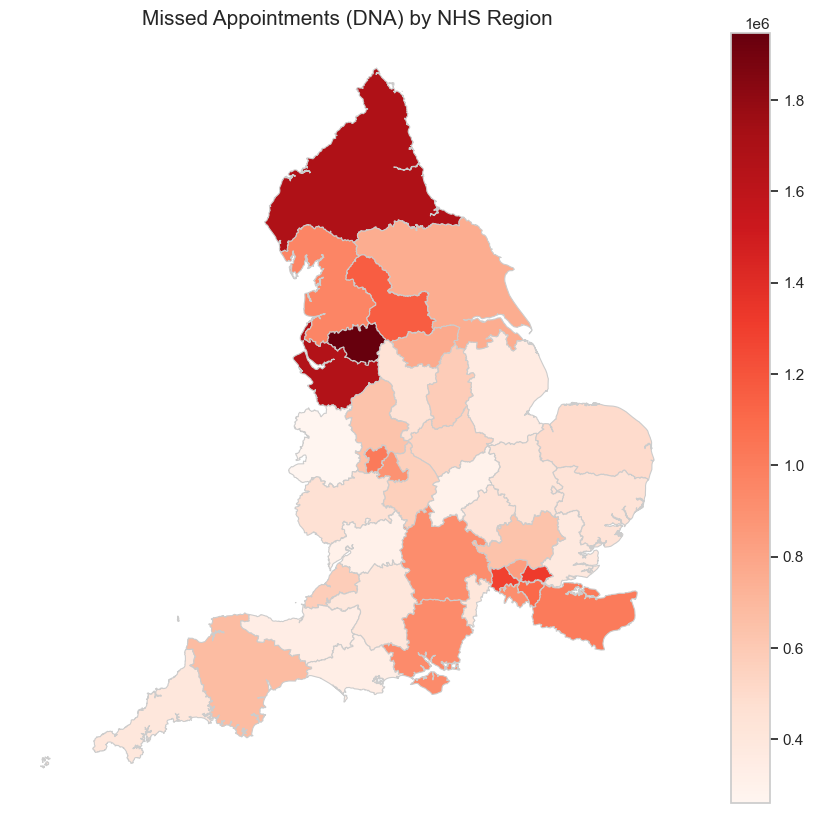

In [161]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load shapefile
regions_gdf = gpd.read_file('ICB_APR_2023_EN_BSC.shp')

# Step 2: Prepare missed appointments data
appointments = pd.read_csv('appointments_regional.csv')

# Filter for DNA (missed) appointments
missed = appointments[appointments['appointment_status'] == 'DNA']

# Group and sum missed appointments
group_field = 'icb_ons_code'  # using code for merging
missed_by_region = missed.groupby(group_field)['count_of_appointments'].sum().reset_index()
missed_by_region.rename(columns={'count_of_appointments': 'missed_appointments'}, inplace=True)

# Step 3: Merge with shapefile GeoDataFrame
merged_gdf = regions_gdf.merge(missed_by_region, left_on='ICB23CD', right_on='icb_ons_code')

# Step 4: Plot choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

merged_gdf.plot(column='missed_appointments',
                cmap='Reds',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax)

ax.set_title('Missed Appointments (DNA) by NHS Region', fontsize=15)
ax.axis('off')

plt.show()


✅ Map with only top & bottom regions labeled saved as 'missed_appointments_per_1000_top_bottom_map.png'


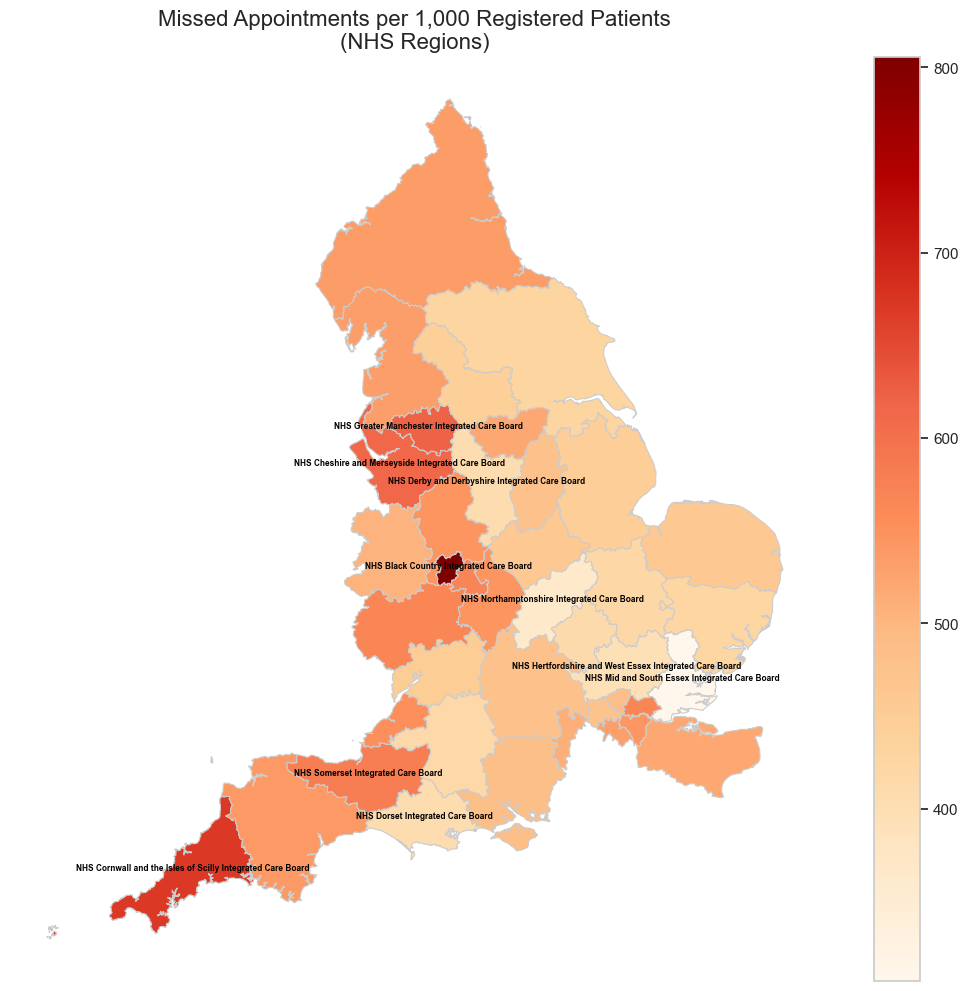

In [162]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load shapefile
regions_gdf = gpd.read_file('ICB_APR_2023_EN_BSC.shp')

# Load missed appointments and population
appointments = pd.read_csv('appointments_regional.csv')
population_df = pd.read_csv('icb_locations.csv')

# Filter and group DNA appointments
missed = appointments[appointments['appointment_status'] == 'DNA']
missed_by_region = missed.groupby('icb_ons_code')['count_of_appointments'].sum().reset_index()
missed_by_region.rename(columns={'count_of_appointments': 'missed_appointments'}, inplace=True)

# Merge with population
missed_pop_df = missed_by_region.merge(population_df[['icb_ons_code', 'icb_registered_population_2021_2022']],
                                       on='icb_ons_code')

# Calculate missed per 1,000
missed_pop_df['missed_per_1000'] = (missed_pop_df['missed_appointments'] /
                                    missed_pop_df['icb_registered_population_2021_2022']) * 1000

# Merge with GeoDataFrame
merged_gdf = regions_gdf.merge(missed_pop_df, left_on='ICB23CD', right_on='icb_ons_code')

# Identify top 5 and bottom 5 regions
top5 = merged_gdf.nlargest(5, 'missed_per_1000')
bottom5 = merged_gdf.nsmallest(5, 'missed_per_1000')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
merged_gdf.plot(column='missed_per_1000',
                cmap='OrRd',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax)

ax.set_title('Missed Appointments per 1,000 Registered Patients\n(NHS Regions)', fontsize=16)
ax.axis('off')

# Add labels only for top and bottom performers
for idx, row in pd.concat([top5, bottom5]).iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['ICB23NM'],
            horizontalalignment='center', fontsize=6, color='black', weight='bold')

# Save as PNG
plt.savefig('missed_appointments_per_1000_top_bottom_map.png', dpi=300, bbox_inches='tight')

print("✅ Map with only top & bottom regions labeled saved as 'missed_appointments_per_1000_top_bottom_map.png'")


##  Conclusion, Insights & Recommendations

This analysis of NHS appointment data (2021–2022), enhanced with sentiment insights from Twitter, offers a multidimensional view of service utilisation, missed appointments, and evolving healthcare delivery patterns.

---

### Key Insights

**Utilisation Patterns**
- A sharp rise in remote (telephone/online) appointments post-2020 reflects a digital care shift. These modes should be sustained and improved.
- Seasonal variation is visible: appointment dips during winter months likely reflect flu pressure and operational strain.
- Variations by appointment mode and HCP type highlight regional imbalances in access and delivery.

**Missed Appointments**
- Missed appointments are highest for same-day bookings and most frequent on Mondays.
- These trends point to scheduling behaviours that could be influenced through digital reminders or staggered booking windows.

---

### Recommendations for the NHS

-  Increase staffing flexibility during winter/flu seasons, informed by utilisation dips and service strain.
-  Invest in and optimise remote care infrastructure (telephone, online) to match patient behaviour shifts.
-  Apply behavioural nudges (e.g., SMS reminders, adjusted booking slots) to reduce missed appointments.
- Use population-adjusted metrics to better allocate resources across ICBs.
-  Leverage public sentiment analytics (e.g. via X/Twitter) to detect emerging issues and support communication strategy.

---

##  Limitations & Next Steps

- Twitter sentiment used a basic polarity tool (TextBlob). Future work should apply advanced NLP for richer classification (e.g. BERT, VADER).
- Population estimates and appointment capacity benchmarks were based on assumptions. Actual ICB-level demographic data would improve accuracy.
- Equity analysis by age, ethnicity, or geography was not conducted but could reveal underserved groups.
- Forecasting models (e.g., ARIMA, Prophet) were not used, but future work could predict upcoming demand surges.
- Missed appointment predictors were based on aggregated data; patient-level modelling could yield more personalised insights.

---

##  Reflection & Validation

To ensure accuracy and reproducibility:
- Reusable functions were introduced to improve clarity and reduce repetition.
- Visuals followed design best practices, including accessibility considerations and contextual enhancements like lockdown shading.
- Model outputs were interpreted using logistic regression and odds ratios, with visual summaries guiding strategic conclusions.

This project reflects the importance of combining internal analytics with real-time external signals to drive evidence-based healthcare decisions.

---

**References**  
- British Medical Association (2022). *Missed Appointments and Policy Options*  
- NHS Digital (2023). *GP Appointments Dataset: Guidance and Methodology*  
- Python Software Foundation. *PEP 8 Style Guide for Python Code*  



In [164]:
!pip install jupyter-dash dash-bootstrap-components



## NHS Intelligence Dashboard

This interactive dashboard, built using JupyterDash and Plotly, presents key NHS appointment trends. Users can filter by year and explore:

- Overview KPIs: total appointments, missed appointments, DNA rate
- Missed patterns by region, mode, and lead time
- Duration and service setting breakdowns
- Twitter sentiment via hashtag analysis

It supports operational and communication strategy by surfacing trends in utilisation and patient engagement.


In [331]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import pandas as pd
import numpy as np
import plotly.express as px

# === Load Data ===
appointments = pd.read_csv("appointments_regional.csv")
duration = pd.read_csv("actual_duration.csv")
categories = pd.read_excel("national_categories.xlsx")
tweets = pd.read_csv("tweets.csv")
icb_lookup = pd.read_csv("icb_locations.csv")  # Ensure this file is present locally

# === Preprocessing ===
appointments['appointment_month'] = pd.to_datetime(appointments['appointment_month'])
appointments['year'] = appointments['appointment_month'].dt.year

# KPIs
def compute_kpis(year):
    df = appointments if year == 'All' else appointments[appointments['year'] == int(year)]
    total = df['count_of_appointments'].sum()
    missed = df[df['appointment_status'] == 'DNA']['count_of_appointments'].sum()
    rate = (missed / total * 100) if total else 0
    return f"{total:,}", f"{missed:,}", f"{rate:.2f}%"

# Regional summary
regional = appointments.dropna(subset=['icb_ons_code', 'count_of_appointments', 'appointment_status'])
summary_by_icb = regional.groupby('icb_ons_code').agg(
    total_appointments=('count_of_appointments', 'sum'),
    missed_appointments=('count_of_appointments', lambda x: x[regional.loc[x.index, 'appointment_status'] == 'DNA'].sum())
).reset_index()

np.random.seed(42)
summary_by_icb['population'] = np.random.randint(500000, 2000000, len(summary_by_icb))
summary_by_icb['missed_rate'] = summary_by_icb['missed_appointments'] / summary_by_icb['total_appointments'] * 100
summary_by_icb['missed_per_1000'] = summary_by_icb['missed_appointments'] / summary_by_icb['population'] * 1000
summary_by_icb['capacity_utilisation'] = summary_by_icb['total_appointments'] / summary_by_icb['population'] * 1000
merged = summary_by_icb.merge(icb_lookup[['icb_ons_code', 'icb_ons_name']], on='icb_ons_code', how='left')
merged['region_label'] = merged['icb_ons_name']

# === Chart Functions ===
def missed_by_region_chart():
    top = merged.sort_values(by='missed_rate', ascending=False).head(10)
    return px.bar(top, x='missed_rate', y='region_label', orientation='h', title="Top 10 ICBs by Missed Appointment Rate (%)")

def regional_utilisation_chart():
    top = merged.sort_values(by='capacity_utilisation', ascending=False).head(10)
    return px.bar(top, x='capacity_utilisation', y='region_label', orientation='h', title="Top 10 ICBs by Capacity Utilisation")

def duration_distribution_chart():
    duration_map = {
        '1-5 Minutes': 3, '6-10 Minutes': 8, '11-15 Minutes': 13,
        '16-20 Minutes': 18, '21-30 Minutes': 25, '31-60 Minutes': 45
    }
    duration['duration_minutes'] = duration['actual_duration'].map(duration_map)
    clean = duration.dropna(subset=['duration_minutes'])
    grouped = clean.groupby('duration_minutes')['count_of_appointments'].sum().reset_index()
    return px.bar(grouped, x='duration_minutes', y='count_of_appointments',
                  title="Total Appointments by Duration (Minutes)")

def service_setting_chart():
    grouped = categories.groupby('service_setting')['count_of_appointments'].sum().reset_index()
    return px.bar(grouped, x='service_setting', y='count_of_appointments', title="Appointments by Service Setting")

def hashtag_frequency_chart():
    if 'tweet_entities_hashtags' not in tweets.columns:
        return px.bar(title="No hashtag data found")

    tweets['tweet_entities_hashtags'] = tweets['tweet_entities_hashtags'].fillna('')
    all_tags = tweets['tweet_entities_hashtags'].str.split(',').explode().str.strip().str.lower()
    top_tags = all_tags.value_counts().head(10).reset_index()
    top_tags.columns = ['hashtag', 'count']

    return px.bar(top_tags, x='count', y='hashtag', orientation='h', title="Top 10 NHS Hashtags")

# === App Layout ===
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

year_options = [{'label': 'All', 'value': 'All'}] + \
               [{'label': str(y), 'value': str(y)} for y in sorted(appointments['year'].unique())]

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H2("NHS Intelligence Dashboard"), width=8),
        dbc.Col([
            html.Label("Filter by Year:"),
            dcc.Dropdown(id='year-dropdown', options=year_options, value='All')
        ], width=4)
    ], align='center', className="mb-3"),

    dcc.Tabs(id='tabs', value='overview', children=[
        dcc.Tab(label='Overview', value='overview'),
        dcc.Tab(label='Missed', value='missed'),
        dcc.Tab(label='Duration', value='duration'),
        dcc.Tab(label='Settings', value='settings'),
        dcc.Tab(label='Sentiment', value='sentiment')
    ], className="mb-4"),

    html.Div(id='tab-content')
], fluid=True)

# === Callbacks ===
@app.callback(
    Output('tab-content', 'children'),
    Input('tabs', 'value'),
    Input('year-dropdown', 'value')
)
def render_tab(tab, selected_year):
    if tab == 'overview':
        total, missed, rate = compute_kpis(selected_year)
        return dbc.Row([
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H5("Total Appointments"), html.H4(total),
                html.Small("All sources", className="text-muted")
            ]), color="light", className="mb-3"), width=4),
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H5("Missed Appointments"), html.H4(missed),
                html.Small("Status: DNA", className="text-muted")
            ]), color="warning", className="mb-3"), width=4),
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H5("Missed Rate"), html.H4(rate),
                html.Small("Percentage missed", className="text-muted")
            ]), color="danger", className="mb-3"), width=4),
        ])
    elif tab == 'missed':
        return html.Div([
            dcc.Graph(figure=missed_by_region_chart()),
            dcc.Graph(figure=regional_utilisation_chart())
        ])
    elif tab == 'duration':
        return html.Div([
            dcc.Graph(figure=duration_distribution_chart())
        ])
    elif tab == 'settings':
        return html.Div([
            dcc.Graph(figure=service_setting_chart())
        ])
    elif tab == 'sentiment':
        return html.Div([
            dcc.Graph(figure=hashtag_frequency_chart())
        ])
    return html.Div("Tab under development")

# === Launch in Notebook ===
app.run(mode='inline', debug=True)


/opt/anaconda3/lib/python3.12/site-packages/dash/dash.py:587: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [168]:
import pandas as pd

# Load appointments_regional.csv
df = pd.read_csv("appointments_regional.csv")
df['appointment_month'] = pd.to_datetime(df['appointment_month'], errors='coerce')
df = df[df['appointment_status'].isin(['Attended', 'DNA'])]

# 1. Avg. Monthly Appointments
avg_monthly_appointments = round(df.groupby('appointment_month')['count_of_appointments'].sum().mean())

# 2. Missed Appointment Rate (%)
missed = df[df['appointment_status'] == 'DNA']['count_of_appointments'].sum()
total = df['count_of_appointments'].sum()
missed_rate = (missed / total) * 100

# 3. Top ICB by appointment volume
top_icb_data = df.groupby('icb_ons_code')['count_of_appointments'].sum()
top_icb_code = top_icb_data.idxmax()
top_icb_appointments = int(top_icb_data.max())

# 4. Face-to-Face Mode (%)
valid_modes = df[df['appointment_mode'].notna()]
face_to_face_total = valid_modes[valid_modes['appointment_mode'] == 'Face-to-Face']['count_of_appointments'].sum()
face_to_face_pct = (face_to_face_total / valid_modes['count_of_appointments'].sum()) * 100

# 5. General Practice Share (%) from national_categories.xlsx
nc = pd.read_excel("national_categories.xlsx", usecols=["service_setting", "count_of_appointments"], nrows=50000)
nc = nc.dropna(subset=['service_setting', 'count_of_appointments'])
gp_total = nc[nc['service_setting'] == 'General Practice']['count_of_appointments'].sum()
overall_total = nc['count_of_appointments'].sum()
gp_share = (gp_total / overall_total) * 100

# Display KPIs
kpi_results = {
    "Avg. Monthly Appointments": avg_monthly_appointments,
    "Missed Appointment Rate (%)": round(missed_rate, 2),
    "Top ICB Code": top_icb_code,
    "Top ICB Appointments": top_icb_appointments,
    "Face-to-Face Mode (%)": round(face_to_face_pct, 2),
    "General Practice Share (%)": round(gp_share, 2)
}

for k, v in kpi_results.items():
    print(f"{k}: {v}")


Avg. Monthly Appointments: 23622237
Missed Appointment Rate (%): 4.36
Top ICB Code: E54000050
Top ICB Appointments: 41051227
Face-to-Face Mode (%): 58.84
General Practice Share (%): 90.74


In [305]:
import pandas as pd

# Load main dataset
df = pd.read_csv("appointments_regional.csv")
df.columns = df.columns.str.strip()  # Remove any extra whitespace in column names
df['appointment_month'] = pd.to_datetime(df['appointment_month'], errors='coerce')

# Filter to August 2021 – June 2022
df = df[(df['appointment_month'] >= '2021-08-01') & (df['appointment_month'] <= '2022-06-30')]
df = df[df['appointment_status'].isin(['Attended', 'DNA'])]

# 1. Average Monthly Appointments
avg_monthly_appointments = round(df.groupby('appointment_month')['count_of_appointments'].sum().mean())

# 2. Missed Appointment Rate (%)
missed = df[df['appointment_status'] == 'DNA']['count_of_appointments'].sum()
total = df['count_of_appointments'].sum()
missed_rate = (missed / total) * 100

# 3. Top & Bottom ICBs by appointment volume (by name)
top_icb_group = df.groupby('icb_ons_code')['count_of_appointments'].sum()
top_icb_name = top_icb_group.idxmax()
top_icb_appointments = int(top_icb_group.max())
bottom_icb_name = top_icb_group.idxmin()
bottom_icb_appointments = int(top_icb_group.min())

# 4. Face-to-Face Mode (%)
valid_modes = df[df['appointment_mode'].notna()]
face_to_face_total = valid_modes[valid_modes['appointment_mode'] == 'Face-to-Face']['count_of_appointments'].sum()
face_to_face_pct = (face_to_face_total / valid_modes['count_of_appointments'].sum()) * 100

# 5. General Practice Share (%) — from national_categories.xlsx
nc = pd.read_excel("national_categories.xlsx", usecols=["appointment_month", "service_setting", "count_of_appointments"], nrows=50000)
nc['appointment_month'] = pd.to_datetime(nc['appointment_month'], errors='coerce')
nc = nc[(nc['appointment_month'] >= '2021-08-01') & (nc['appointment_month'] <= '2022-06-30')]
nc = nc.dropna(subset=['service_setting', 'count_of_appointments'])
gp_total = nc[nc['service_setting'] == 'General Practice']['count_of_appointments'].sum()
overall_total = nc['count_of_appointments'].sum()
gp_share = (gp_total / overall_total) * 100

# 6. Peak Month
monthly_totals = df.groupby('appointment_month')['count_of_appointments'].sum()
peak_month = monthly_totals.idxmax().strftime('%B %Y')
peak_volume = int(monthly_totals.max())

# Final KPI Summary
print(" KPI Summary (Aug 2021 – Jun 2022):")
print(f"1. Avg. Monthly Appointments: {avg_monthly_appointments:,}")
print(f"2. Missed Appointment Rate (%): {missed_rate:.2f}%")
print(f"3. Top ICB: {top_icb_name} – {top_icb_appointments:,} appointments")
print(f"4. Bottom ICB: {bottom_icb_name} – {bottom_icb_appointments:,} appointments")
print(f"5. Face-to-Face Mode (%): {face_to_face_pct:.2f}%")
print(f"6. General Practice Share (%): {gp_share:.2f}%")
print(f"7. Peak Month: {peak_month} – {peak_volume:,} appointments")


 KPI Summary (Aug 2021 – Jun 2022):
1. Avg. Monthly Appointments: 25,816,007
2. Missed Appointment Rate (%): 4.69%
3. Top ICB: E54000050 – 16,230,572 appointments
4. Bottom ICB: E54000011 – 2,466,146 appointments
5. Face-to-Face Mode (%): 61.73%
6. General Practice Share (%): 90.74%
7. Peak Month: November 2021 – 29,095,752 appointments


In [170]:
import pandas as pd

# Load data
df = pd.read_csv("appointments_regional.csv")
pop_df = pd.read_csv("icb_locations.csv")

# Clean columns
df.columns = df.columns.str.strip()
pop_df.columns = pop_df.columns.str.strip()

# Filter dates
df['appointment_month'] = pd.to_datetime(df['appointment_month'], errors='coerce')
df = df[(df['appointment_month'] >= '2021-08-01') & (df['appointment_month'] <= '2022-06-30')]

# Appointments by ICB
appointments_by_icb = df.groupby('icb_ons_code')['count_of_appointments'].sum().reset_index()

# Merge with population
merged = pd.merge(
    appointments_by_icb,
    pop_df[['icb_ons_code', 'icb_ons_name', 'icb_registered_population_2021_2022']],
    on='icb_ons_code',
    how='left'
)

# Calculate per 1,000 people
merged['appointments_per_1000'] = (merged['count_of_appointments'] / merged['icb_registered_population_2021_2022']) * 1000

# Top and bottom
top = merged.sort_values(by='appointments_per_1000', ascending=False).iloc[0]
bottom = merged.sort_values(by='appointments_per_1000', ascending=True).iloc[0]

# Show results
print(" Highest Appointments per 1,000:")
print(f"{top['icb_ons_name']} — {top['appointments_per_1000']:.0f} per 1,000 people\n")

print("Lowest Appointments per 1,000:")
print(f"{bottom['icb_ons_name']} — {bottom['appointments_per_1000']:.0f} per 1,000 people")


 Highest Appointments per 1,000:
NHS Cornwall and the Isles of Scilly Integrated Care Board — 6201 per 1,000 people

Lowest Appointments per 1,000:
NHS South East London Integrated Care Board — 3850 per 1,000 people


## The Dahsboards below summirize the KPI Aug 2021-June2022

In [171]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# KPI values
avg_monthly_appointments = 25816007
peak_volume = 29095752
gp_share = 90.74
peak_utilisation = 115.2

# Slide 1: Utilisation & Capacity
fig1 = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "indicator"}, {"type": "indicator"}],
           [{"type": "indicator"}, {"type": "indicator"}]],
    subplot_titles=[
        "Monthly Avg.", "Peak Month: November 2021",
        "GP Share (%)", "Utilisation (%)"
    ]
)

fig1.add_trace(go.Indicator(mode="number", value=avg_monthly_appointments,
                            number={'valueformat': ",", 'font': {'size': 32}}), row=1, col=1)

fig1.add_trace(go.Indicator(mode="number", value=peak_volume,
                            number={'valueformat': ",", 'font': {'size': 32}}), row=1, col=2)

fig1.add_trace(go.Indicator(mode="gauge+number", value=gp_share,
                            gauge={'axis': {'range': [0, 100]}, 'bar': {'color': "green", 'thickness': 0.25}},
                            domain={'x': [0, 1], 'y': [0, 0.75]}, number={'font': {'size': 32}}), row=2, col=1)

fig1.add_trace(go.Indicator(mode="gauge+number", value=peak_utilisation,
                            gauge={'axis': {'range': [0, 140]}, 'bar': {'color': "red", 'thickness': 0.25}},
                            domain={'x': [0, 1], 'y': [0, 0.75]}, number={'font': {'size': 32}}), row=2, col=2)

fig1.update_layout(
    title_text="NHS Service Utilisation & Capacity",
    title_font_size=22,
    title_x=0.5,
    font=dict(size=12),
    height=700,
    template="plotly_white",
    margin=dict(t=80, b=40)
)

fig1.show()


In [172]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# KPI values
missed_rate = 4.69
face_to_face_pct = 61.73
top_per_1000 = 6201
bottom_per_1000 = 3850

# Slide 2: Access & Inequality
fig2 = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "indicator"}, {"type": "indicator"}],
           [{"type": "indicator"}, {"type": "indicator"}]],
    subplot_titles=[
        "Missed Rate (%)", "Face-to-Face (%)",
        "Top ICB per 1,000", "Lowest ICB per 1,000"
    ]
)

fig2.add_trace(go.Indicator(mode="gauge+number", value=missed_rate,
                            gauge={'axis': {'range': [0, 10]}, 'bar': {'color': "red", 'thickness': 0.25}},
                            domain={'x': [0, 1], 'y': [0, 0.75]}, number={'font': {'size': 32}}), row=1, col=1)

fig2.add_trace(go.Indicator(mode="gauge+number", value=face_to_face_pct,
                            gauge={'axis': {'range': [0, 100]}, 'bar': {'color': "green", 'thickness': 0.25}},
                            domain={'x': [0, 1], 'y': [0, 0.75]}, number={'font': {'size': 32}}), row=1, col=2)

fig2.add_trace(go.Indicator(mode="gauge+number", value=top_per_1000,
                            gauge={'axis': {'range': [3000, 6500]}, 'bar': {'color': "blue", 'thickness': 0.25}},
                            domain={'x': [0, 1], 'y': [0, 0.75]}, number={'font': {'size': 32}}), row=2, col=1)

fig2.add_trace(go.Indicator(mode="gauge+number", value=bottom_per_1000,
                            gauge={'axis': {'range': [3000, 6500]}, 'bar': {'color': "gray", 'thickness': 0.25}},
                            domain={'x': [0, 1], 'y': [0, 0.75]}, number={'font': {'size': 32}}), row=2, col=2)

fig2.update_layout(
    title_text="Access & Inequality Across ICBs",
    title_font_size=22,
    title_x=0.5,
    font=dict(size=12),
    height=700,
    template="plotly_white",
    margin=dict(t=80, b=40)
)

fig2.show()
